In [1]:
# Install the XGBoost library, which provides an optimized gradient boosting framework
! pip install xgboost

import numpy as np  # Importing NumPy for numerical operations and array handling
import pandas as pd  # Importing  Pandas for data manipulation and analysis
import os  # Importing  OS module for interacting with the operating system
import logging  # Importing  Logging module for event tracking and debugging
import warnings  # Importing Warnings module to control warning messages
import sys  # Importing Sys module to interact with the Python runtime environment

import matplotlib.pyplot as plt  # Importing Matplotlib for creating static, animated, and interactive visualizations
from matplotlib.backends.backend_pdf import PdfPages  # Importing PdfPages for saving multiple plots to a PDF file

from sklearn.tree import DecisionTreeRegressor
# Importing scikit-learn modules for machine learning models and utilities
from sklearn.ensemble import (
    RandomForestRegressor,  # RandomForestRegressor for regression tasks
    GradientBoostingRegressor,  # GradientBoostingRegressor for boosting
    AdaBoostRegressor  # AdaBoostRegressor for boosting
)
from sklearn.linear_model import (
    Ridge,  # Ridge regression for regularization
    LinearRegression,  # Linear regression model
    Lasso  # Lasso regression for regularization
)
from sklearn.metrics import (
    mean_absolute_error,  # Metric for assessing regression model performance
    mean_squared_error,  # Metric for assessing regression model performance
    r2_score  # Metric for assessing regression model performance
)
from sklearn.model_selection import (
    train_test_split,  # Split data into training and testing sets
    cross_val_score,  # Cross-validation score for model evaluation
    learning_curve,  # Learning curve for visualizing model performance
    KFold  # K-Fold cross-validator
)
from sklearn.feature_selection import RFE  # Importing Recursive Feature Elimination for feature selection
from sklearn.impute import SimpleImputer  # Importing SimpleImputer to handle missing values
from sklearn.preprocessing import (
    OneHotEncoder,  # Encoding categorical features
    RobustScaler,  # Scaling features robust to outliers
    StandardScaler,  # Standardizing features
    OrdinalEncoder,  # Encoding categorical features with ordinal relationships
    FunctionTransformer  # Custom transformations on features
)
from sklearn.compose import ColumnTransformer   # Importing ColumnTransformer for applying transformers to specific columns
from sklearn.pipeline import Pipeline, FeatureUnion  # Importing Pipeline and FeatureUnion for creating machine learning workflows
from sklearn.base import BaseEstimator, TransformerMixin  # Importing Base classes for custom Transformers
from sklearn.inspection import permutation_importance  # Importing Permutation importance for feature importance analysis

import xgboost as xgb  # Importing XGBoost for gradient boosting
import joblib  # Importing Joblib for saving and loading models efficiently
import seaborn as sns  # Importing Seaborn for statistical data visualization

# Suppress all warnings
warnings.filterwarnings("ignore")

# Adding the directory containing .py modules to the system path
sys.path.append('../Scripts/')


In [2]:

notebook_name = 'Data Preprocessing, Feature Selection, Predicted Price' 

# Paths for the log directories
info_log_path = f'../Logs/info/{notebook_name}_info.log'

# Creating directories if they don't exist
os.makedirs(os.path.dirname(info_log_path), exist_ok=True)

# Clearing any previous handlers if re-running this setup
logger = logging.getLogger()
while logger.handlers:
    logger.handlers.pop()

# Configuring logging
info_logger = logging.getLogger('info_logger')

info_handler = logging.FileHandler(info_log_path, mode='a')  # Append mode

info_handler.setLevel(logging.INFO)

# Consistent formatter for both handlers
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
info_handler.setFormatter(formatter)

# Adding handlers to the loggers
info_logger.addHandler(info_handler)

info_logger.setLevel(logging.INFO)


### Initial Preprocessing steps 

In [3]:
%%writefile ../Scripts/data_transformations_1.py

import pandas as pd

def print_header(header):
    """Prints a bold header for each section."""
    print(f"\n\033[1m{header}\033[0m")

def drop_unnecessary_columns(df):
    """Drops column that are no longer needed."""
    df = df.drop(columns=['extraction_timestamp'])
    print_header("Dropping Unnecessary column:")
    print("Dropped 'extraction_timestamp' column.")
    return df

def check_duplicates(df):
    """Checks for duplicate rows in the DataFrame."""
    print_header("Duplicate check:")
    duplicate_rows = df.duplicated().any()
    if duplicate_rows:
        print("There are duplicate rows in the DataFrame.")
    else:
        print("No duplicate rows found in the DataFrame.")

def rename_columns(df):
    """Renames column according to the specified mapping."""
    print_header("Column Renaming:")
    df.rename(columns={
        'HGV - \nMotorways': 'HGV - Motorways',
        'Freight transport (HGV and LGV)\n[Note 5]': 'Freight transport (HGV and LGV)',
        'Headcount of Pupils': 'Headcount of Pupils(school)',
        'No qualifications (number)': 'No qualifications',
        'Level 1 and entry level qualifications (number)': 'Level 1 and entry level qualifications',
        'Level 2 qualifications (number)': 'Level 2 qualifications',
        'Apprenticeship (number)': 'Apprenticeship',
        'Level 3 qualifications (number)': 'Level 3 qualifications',
        'Level 4 qualifications and above (number)': 'Level 4 qualifications and above',
        'Other (number)': 'Other qualifications',
        'Qualification index rank \n(lowest = 1, highest = 331)': 'Qualification index rank (1 to 331)',
        'Region code_x': 'Region code',
        'Region name_x': 'Region name',
        'Local authority code ': 'Local authority code',
        'One Bedroom': 'One Bedroom Rent',
        'Two Bedrooms': 'Two Bedrooms Rent',
        'Three Bedrooms': 'Three Bedrooms Rent',
        'Four or more Bedrooms': 'Four or more Bedrooms Rent',
        'All categories': 'All categories Rent'
    }, inplace=True)
    print("Renamed columns.")
    return df

def check_null_records(df):
    """Checks for null record and print the number of null records per column."""
    print_header("Null values in Each record:")
    null_counts = df.isnull().sum()
    for col, count in null_counts.items():
        print(f"Column: {col}, Number of Null Records: {count}")
    total_null_records = null_counts.sum()
    print(f"Total Number of Null Records in DataFrame: {total_null_records}")

def clean_data(df):
    """Removes record with empty values for key attributes and display record count."""
    print_header("Drop records with Null values on Key attributes:")
    initial_count = len(df)
    df = df.dropna(subset=['AveragePrice', 'Local authority code', 'Town/City'])
    cleaned_count = len(df)
    print(f"Number of records before cleaning: {initial_count}")
    print(f"Number of records after cleaning: {cleaned_count}")
    return df

def save_to_excel(df, filepath):
    """Saves the cleaned DataFrame to an Excel file."""
    print_header("Data export:")
    df.to_excel(filepath, index=False)
    print(f"Data saved to '{filepath}'")

def main_processing_pipeline(file_path):
    """Main processing pipeline that runs all steps in sequence."""
    df = pd.read_excel(file_path)
    df = drop_unnecessary_columns(df)
    check_duplicates(df)
    df = rename_columns(df)
    check_null_records(df)
    df = clean_data(df)
    save_to_excel(df, "../Data/Output/original_cleaned_df.xlsx")
    return df


Writing ../Scripts/data_transformations_1.py


In [4]:
from data_transformations_1 import main_processing_pipeline  # Importing the specific function

# Path to the excel file from Extraction phase data
extracted_data_path = '../Data/Output/Data_Extraction_combined_df.xlsx'
# Calling the processing pipeline on the extracted data
original_cleaned_df = main_processing_pipeline(extracted_data_path)
info_logger.info("Applied Data processing")


Dropping Unnecessary column:
Dropped 'extraction_timestamp' column.

Duplicate check:
No duplicate rows found in the DataFrame.

Column Renaming:
Renamed columns.

Null values in Each record:
Column: District, Number of Null Records: 996
Column: Transfer Month-Year, Number of Null Records: 996
Column: Town/City, Number of Null Records: 1656
Column: County, Number of Null Records: 1656
Column: Price, Number of Null Records: 1656
Column: Property Type, Number of Null Records: 1656
Column: Old/New, Number of Null Records: 1656
Column: Duration, Number of Null Records: 1656
Column: PPD Category Type, Number of Null Records: 1656
Column: Record Status, Number of Null Records: 1656
Column: Region code, Number of Null Records: 2208
Column: Region name, Number of Null Records: 2208
Column: Local authority code, Number of Null Records: 2208
Column: Local authority name, Number of Null Records: 2208
Column: Date, Number of Null Records: 1568
Column: RegionName, Number of Null Records: 1568
Colu

Data saved to '../Data/Output/original_cleaned_df.xlsx'


### Reservation of unseen data validation

In [5]:
def perform_train_test_split(df, column_name, test_size=0.2, random_state=42):
    """
    Splits the DataFrame into training and testing sets based on a specified column for stratification.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame to split.
    - column_name (str): The column name to use for stratification.
    - test_size (float): The proportion of the dataset to include in the test split.
    - random_state (int): Controls the shuffling applied to the data before applying the split for reproducibility.
    
    Returns:
    - train_df (pd.DataFrame): Training subset of the DataFrame.
    - test_df (pd.DataFrame): Testing subset of the DataFrame.
    """
    if column_name in df.columns:
        train_df, test_df = train_test_split(
            df, 
            test_size=test_size, 
            random_state=random_state, 
            stratify=df[column_name]
        )
        print("Training set shape:", train_df.shape)
        print("Testing set shape:", test_df.shape)
        return train_df, test_df
    else:
        print(f"The column '{column_name}' was not found in the DataFrame.")
        return None, None

train_df, test_df = perform_train_test_split(original_cleaned_df, 'Local authority code')
info_logger.info("Test Train split completed")

Training set shape: (2803, 77)
Testing set shape: (701, 77)


### Execution of Complete preprocessing pipeline 

In [6]:
%%writefile ../Scripts/data_transformations_2.py

import pandas as pd
import numpy as np 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

def drop_columns1(X):
    """
    Drops specified column from the DataFrame.
    
    Parameters:
    X (pd.DataFrame): The input DataFrame.
    
    Returns:
    pd.DataFrame: The DataFrame with specified columns dropped.
    """
    return X.drop(columns=['Number of Schools', 'Headcount of Pupils(school)', 'NewSalesVolume'])

class GroupMeanImputer(BaseEstimator, TransformerMixin):
    """
    A custom transformer that imputes missing values in specified target columns
    by calculating the mean within groups defined by specified columns.
    """
    def __init__(self, group_cols, target_cols):
        self.group_cols = group_cols
        self.target_cols = target_cols

    def fit(self, X, y=None):
        """
        Compute the mean values for the groups in the target columns during fitting.
        
        """
        self.group_means_ = X.groupby(self.group_cols)[self.target_cols].transform('mean')
        return self

    def transform(self, X):
        """
        Impute missing values in the target columns by replacing NaNs with the mean
        values computed during the fitting process.
        """
        for col in self.target_cols:
            if X[col].isnull().any():  # Proceed only if there are missing values
                X[col] = X[col].fillna(X.groupby(self.group_cols)[col].transform('mean'))
        return X

class FeatureCreator(BaseEstimator, TransformerMixin):
    """
    Custom transformer for creating new features from existing columns in a DataFrame.
    This includes extracting time-based features and calculating specific ratios and percentage changes.
    """
    def fit(self, X, y=None):
        """
        Fits the transformer, ensuring that the input is a pandas DataFrame and capturing the column names.
        
        Parameters:
        X (pd.DataFrame): The input DataFrame.
        y: Ignored, present for compatibility.
        
        Returns:
        self: Returns the instance itself.
        """
        if isinstance(X, pd.DataFrame):
            self.columns_ = X.columns.tolist()
        else:
            raise ValueError("Input must be a pandas DataFrame during fitting.")
        return self

    def transform(self, X):
        """
        Transforms the input DataFrame by adding new features such as date-based components, 
        price ratios, and percentage changes, as well as applying logarithmic transformations.
        
        Parameters:
        X (pd.DataFrame): The input DataFrame.
        
        Returns:
        X (pd.DataFrame): The transformed DataFrame with new features.
        """
        
        X['Date'] = pd.to_datetime(X['Date'])
        
        # Extracting month, quarter, and year from 'Date'
        X['Month'] = X['Date'].dt.month
        X['Quarter'] = X['Date'].dt.quarter
        X['Year'] = X['Date'].dt.year

        # Creating specific price ratios as per manual steps
        X['Detached_SemiDetached_Ratio'] = X['DetachedPrice'] / X['SemiDetachedPrice']
        X['Detached_Terraced_Ratio'] = X['DetachedPrice'] / X['TerracedPrice']
        X['Detached_Flat_Ratio'] = X['DetachedPrice'] / X['FlatPrice']
        
        # Defining specific price columns for percentage changes and ratios
        price_columns = ['AveragePrice', 'DetachedPrice', 'SemiDetachedPrice', 'TerracedPrice', 'FlatPrice']
        
        # Calculating percentage changes for price-related columns
        for col in price_columns:
            X[col + '_PctChange'] = X[col].pct_change()
        
        # Applying log transformation to the same price columns
        log_transform_cols = ['SalesVolume', 'DetachedPrice', 'SemiDetachedPrice', 'TerracedPrice', 'FlatPrice', 'AveragePrice']
        for col in log_transform_cols:
            X[col + '_log'] = np.log1p(X[col])
        
        return X

def cap_floor(df, lower_quantile=0.05, upper_quantile=0.95):
    """
    Apply capping and flooring to numerical features in the DataFrame based on specified quantiles.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to apply capping and flooring.
    lower_quantile (float): The quantile value below which data will be floored.
    upper_quantile (float): The quantile value above which data will be capped.
    
    Returns:
    pd.DataFrame: The DataFrame with capped and floored values.
    """
    df_capped = df.copy() 
    for col in df_capped.select_dtypes(include=[np.number]).columns:
        lower_bound = df_capped[col].quantile(lower_quantile)
        upper_bound = df_capped[col].quantile(upper_quantile)
        
        df_capped[col] = df_capped[col].clip(lower=lower_bound, upper=upper_bound)
    
    return df_capped

def cap_floor_func(X):
    """
    Wrapper function for applying capping and flooring within a pipeline.
    
    Parameters:
    X (pd.DataFrame): The input DataFrame.
    
    Returns:
    pd.DataFrame: The DataFrame with capped and floored values.
    """
    return cap_floor(X, lower_quantile=0.05, upper_quantile=0.95)

class EncodingWithNames(BaseEstimator, TransformerMixin):
    """
    A custom transformer that performs ordinal encoding on specified columns while
    preserving column names and handling passthrough columns.
    """
    def __init__(self, columns, remainder='passthrough'):
        self.columns = columns
        self.remainder = remainder
        self.encoder = ColumnTransformer(
            transformers=[
                ('ordinal_encoder', OrdinalEncoder(), columns)
            ],
            remainder=remainder,
            verbose_feature_names_out=False  # Prevent auto-renaming
        )

    def fit(self, X, y=None):
        """
        Fit the internal ColumnTransformer on the input data.
        """
        self.encoder.fit(X, y)
        return self

    def transform(self, X):
        """
        Transform the data, encoding specified columns and combining them with passthrough data.
        """
        transformed = self.encoder.transform(X)
        if isinstance(transformed, np.ndarray):
            if self.remainder == 'passthrough':
                all_columns = self.columns + [col for col in X.columns if col not in self.columns]
            else:
                all_columns = self.columns
            return pd.DataFrame(transformed, index=X.index, columns=all_columns)
        return transformed

class ColumnTransformerDf(ColumnTransformer, TransformerMixin):
    """
    A custom ColumnTransformer that ensures the output is a DataFrame with appropriate
    column names and index, maintaining the structure of the original DataFrame.
    """
    def transform(self, X):
        """
        Transform the data and ensure that the result is returned as a DataFrame.
        """
        result = super().transform(X)
        if not isinstance(result, pd.DataFrame):
            result = pd.DataFrame(result, index=X.index, columns=self.get_feature_names_out())
        return result

    def fit_transform(self, X, y=None):
        """
        Fit to data, then transform it, ensuring the output is a DataFrame.
        """
        result = super().fit_transform(X, y=y)
        if not isinstance(result, pd.DataFrame):
            result = pd.DataFrame(result, index=X.index, columns=self.get_feature_names_out())
        return result

class ColumnOrderTransformer(BaseEstimator, TransformerMixin):
    """
    A custom transformer that reorders columns in a DataFrame according to original order to maintain consistency after different pipeline process.
    """
    def __init__(self, column_order):
        self.column_order = column_order

    def fit(self, X, y=None):
        """
        No fitting necessary; return self.
        """
        return self

    def transform(self, X):
        """
        Reorder the DataFrame columns based on the specified column order.
        """
        return X[self.column_order]

# Custom function to drop specified columns from the DataFrame
def drop_columns2(X):
    """
    Drops column that are unnecessary for the analysis and model training.
    
    Parameters:
    X (pd.DataFrame): The input DataFrame.
    
    Returns:
    X (pd.DataFrame): The DataFrame with specified columns removed.
    """
    return X.drop(columns=['District', 'Transfer Month-Year', 'Town/City', 'County', 'Old/New',
                           'Record Status', 'Region name', 'Local authority name', 'RegionName', 'AreaCode', 'Date'])

# Custom function for manipulating specific feature values for removing prefixes from strings
def feature_manipulation(X):
    """
    Performs specific feature manipulation to remove the prefix 'E' from the region and local authority codes and convert data types.
    
    Parameters:
    X (pd.DataFrame): The input DataFrame.
    
    Returns:
    X (pd.DataFrame): The DataFrame with manipulated feature values.
    """
    X = X.copy()
    for col in ['Region code', 'Local authority code']:
        X[col] = X[col].str.replace('E', '').astype(str)
    return X

# Custom function to handle infinite values by replacing them with NaNs
def handle_infinite_values(X):
    """
    Replaces infinite value in the DataFrame with NaNs to handle them appropriately in subsequent steps.
    
    Parameters:
    X (pd.DataFrame): The input DataFrame.
    
    Returns:
    X (pd.DataFrame): The DataFrame with infinite values replaced by NaNs.
    """
    return X.replace([np.inf, -np.inf], np.nan)


# Defining multiple group mean imputers for different sets of group-by columns and target columns

# GroupMeanImputer for imputing missing values based on region and local authority
group_mean_imputer1 = GroupMeanImputer(
    group_cols=['Region code', 'Region name', 'Local authority code', 'Local authority name'],
    target_cols=['SalesVolume', 'DetachedPrice', 'SemiDetachedPrice', 'TerracedPrice', 'NewPrice', 'OldPrice', 
                 'OldSalesVolume', 'Annual change (%)', 'Rental price (£)', 'One Bedroom Rent', 'Two Bedrooms Rent', 
                 'Three Bedrooms Rent', 'Four or more Bedrooms Rent', 'All categories Rent', 
                 'Qualification index score', 'Qualification index rank (1 to 331)', 'No qualifications', 
                 'Level 1 and entry level qualifications', 'Level 2 qualifications', 'Apprenticeship', 
                 'Level 3 qualifications', 'Level 4 qualifications and above', 'Other qualifications', 
                 'Estimated number of households with at least 1 early-years or school age child', 
                 'Deprivation Average Score', 'Number of those aged 16+ who are unemployed', 
                 'Number of those aged 16+ in employment who are employees',
                 'Number of those aged 16+ in employment who are self-employed','GDHI'])

# GroupMeanImputer for imputing missing values based on broader region grouping
group_mean_imputer2 = GroupMeanImputer(
    group_cols=['Region code', 'Region name'],
    target_cols=['DetachedPrice', 'SemiDetachedPrice', 'TerracedPrice', 'NewPrice', 
                'Annual change (%)', 'Rental price (£)', 'One Bedroom Rent', 'Two Bedrooms Rent', 
                'Three Bedrooms Rent', 'Four or more Bedrooms Rent', 'All categories Rent', 
                'Qualification index score', 'Qualification index rank (1 to 331)', 'No qualifications', 
                'Level 1 and entry level qualifications', 'Level 2 qualifications', 'Apprenticeship', 
                'Level 3 qualifications', 'Level 4 qualifications and above', 'Other qualifications', 
                'Estimated number of households with at least 1 early-years or school age child', 
                'Deprivation Average Score', 'Number of those aged 16+ who are unemployed', 
                'Number of those aged 16+ in employment who are employees', 
                'Number of those aged 16+ in employment who are self-employed', 'GDHI' ])

# Instantiating the custom FeatureCreator transformer    
feature_creation = FeatureCreator()

# Creating a FunctionTransformer that wraps the cap_floor function for capping and flooring values
cap_floor_transformer = FunctionTransformer(func=cap_floor_func, validate=False)

# Initializing the EncodingWithNames transformer to handle categorical encoding within the pipeline
encoding_transformer = EncodingWithNames(
    columns=['Property Type', 'Duration', 'PPD Category Type'],
    remainder='passthrough'
)

# Defining scalers for different groups of features
robust_scaler_price = RobustScaler()
standard_scaler = StandardScaler()

# Combining different transformations into a single ColumnTransformer for scaling and normalizing numerical features
# This applies RobustScaler to price-related columns (handling outliers) and StandardScaler to other columns for standard normalization.

scaling_normalizing_transformer = ColumnTransformerDf(transformers=[
    ('robust_scaler_price', RobustScaler(), ['Price']),
    ('robust_scaler_others', RobustScaler(), [    'SalesVolume', 'DetachedPrice', 'SemiDetachedPrice', 'TerracedPrice', 
                                                'FlatPrice', 'OldSalesVolume', 'Annual change (%)', 'All ages', 'Area (sq km)', 
                                                'Number of those aged 16+ in employment who are self-employed', 'Buses total', 
                                                'Diesel cars total', 'Petrol cars total', 'Freight transport (HGV and LGV)', 
                                                'Fuel consumption by all vehicles']),
    ('standard_scaler', StandardScaler(), [
        'AveragePrice', 'Index', '1m%Change', 'CashPrice', 'MortgagePrice', 'MortgageIndex', 
    'FTBPrice', 'FOOPrice', 'NewPrice', 'OldPrice', 'Rental price (£)', 'One Bedroom Rent', 
    'Two Bedrooms Rent', 'Three Bedrooms Rent', 'Four or more Bedrooms Rent', 'All categories Rent', 
    '0-20', '20-40', '40-60', '60+', 'Female population', 'Male population',
    'Qualification index rank (1 to 331)',
    'Qualification index score', 'No qualifications', 'Level 1 and entry level qualifications', 
    'Level 2 qualifications', 'Apprenticeship', 'Level 3 qualifications', 'Level 4 qualifications and above', 
    'Other qualifications', 'Estimated number of households with at least 1 early-years or school age child', 
    'Deprivation Average Score', 'Number of those aged 16+ who are unemployed', 
    'Number of those aged 16+ in employment who are employees', 'GDHI', 'Diesel LGV total', 
    'Petrol LGV total', 'LPG LGV total', 'Personal transport (buses, cars and motorcycles)'
    ]),
    ], remainder='passthrough', verbose_feature_names_out=False)

# List of columns in the desired order
desired_column_order = ['District', 'Transfer Month-Year', 'Town/City', 'County', 'Price',
       'Property Type', 'Old/New', 'Duration', 'PPD Category Type',
       'Record Status', 'Region code', 'Region name', 'Local authority code',
       'Local authority name', 'Date', 'RegionName', 'AreaCode',
       'AveragePrice', 'Index', '1m%Change', 'SalesVolume', 'DetachedPrice',
       'SemiDetachedPrice', 'TerracedPrice', 'FlatPrice', 'CashPrice',
       'MortgagePrice', 'MortgageIndex', 'FTBPrice', 'FOOPrice', 'NewPrice',
       'OldPrice', 'OldSalesVolume', 'Annual change (%)', 'Rental price (£)',
       'One Bedroom Rent', 'Two Bedrooms Rent', 'Three Bedrooms Rent',
       'Four or more Bedrooms Rent', 'All categories Rent', 'All ages', '0-20',
       '20-40', '40-60', '60+', 'Female population', 'Male population',
       'Area (sq km)', 'Qualification index score',
       'Qualification index rank (1 to 331)', 'No qualifications',
       'Level 1 and entry level qualifications', 'Level 2 qualifications',
       'Apprenticeship', 'Level 3 qualifications',
       'Level 4 qualifications and above', 'Other qualifications',
       'Estimated number of households with at least 1 early-years or school age child',
       'Deprivation Average Score',
       'Number of those aged 16+ who are unemployed',
       'Number of those aged 16+ in employment who are employees',
       'Number of those aged 16+ in employment who are self-employed', 'GDHI',
       'Buses total', 'Diesel cars total', 'Petrol cars total',
       'HGV - Motorways', 'HGV total', 'Diesel LGV total', 'Petrol LGV total',
       'LPG LGV total', 'Personal transport (buses, cars and motorcycles)',
       'Freight transport (HGV and LGV)', 'Fuel consumption by all vehicles',
       'Month', 'Quarter', 'Year', 'Detached_SemiDetached_Ratio',
       'Detached_Terraced_Ratio', 'Detached_Flat_Ratio',
       'AveragePrice_PctChange', 'DetachedPrice_PctChange',
       'SemiDetachedPrice_PctChange', 'TerracedPrice_PctChange',
       'FlatPrice_PctChange', 'SalesVolume_log', 'DetachedPrice_log',
       'SemiDetachedPrice_log', 'TerracedPrice_log', 'FlatPrice_log',
       'AveragePrice_log']


Writing ../Scripts/data_transformations_2.py


In [7]:
# Full pipeline definition and execution
from data_transformations_2 import group_mean_imputer1, group_mean_imputer2, feature_creation, cap_floor_transformer, encoding_transformer, robust_scaler_price, standard_scaler, scaling_normalizing_transformer, desired_column_order, GroupMeanImputer, FeatureCreator, EncodingWithNames, ColumnTransformerDf, ColumnOrderTransformer, drop_columns1, cap_floor, cap_floor_func, drop_columns2, feature_manipulation, handle_infinite_values
# Defining the first stage of the pipeline
first_stage_pipeline = Pipeline(steps=[
    ('drop_columns', FunctionTransformer(drop_columns1)),  # Drop unnecessary columns
    ('group_mean_imputation1', group_mean_imputer1),       # Impute missing values using first group mean strategy
    ('group_mean_imputation2', group_mean_imputer2),       # Impute missing values using second group mean strategy
    ('feature_creation', feature_creation)                 # Create new features from existing columns
])

# Defining the second stage of the pipeline
second_stage_pipeline = Pipeline(steps=[
    ('cap_floor', cap_floor_transformer),                  # Cap and floor extreme values based on quantiles
    ('encode', encoding_transformer),                      # Encode categorical features using ordinal encoding
    ('scale_normalize', scaling_normalizing_transformer),  # Scale and normalize numerical features
    ('reorder_columns', ColumnOrderTransformer(desired_column_order)),  # Reorder columns to a specific order
    ('drop_unwanted_fields', FunctionTransformer(drop_columns2)),       # Drop additional unwanted columns
    ('feature_manipulation', FunctionTransformer(feature_manipulation)), # Manipulate features
    ('handle_infinite_values', FunctionTransformer(handle_infinite_values)) # Replace infinite values with NaNs
])

# Preparing the data frame for pipeline processing
pipeline_train_df = train_df.copy()

# Fit and transform the first stage on the training data
first_stage_output = first_stage_pipeline.fit_transform(pipeline_train_df)

# Saving the first stage pipeline to a file for later use 
joblib.dump(first_stage_pipeline, '../Models/first_stage_pipeline.pkl')

# Fit and transform the second stage on the output of the first stage
second_stage_output = second_stage_pipeline.fit_transform(first_stage_output)

# Saving the second stage pipeline to a file for later use 
joblib.dump(second_stage_pipeline, '../Models/second_stage_pipeline.pkl')

# Combining both stages into a full pipeline for end-to-end processing
full_pipeline = Pipeline(steps=[
    ('first_stage', first_stage_pipeline),  # Include the first stage pipeline
    ('second_stage', second_stage_pipeline) # Follow with the second stage pipeline
])

# Saving the full pipeline to a file for end-to-end model application
joblib.dump(full_pipeline, '../Models/full_pipeline.pkl')
info_logger.info("Applied Full pipeline stage")

In [8]:
# Checking for null records and print the results with the number of null records per column
null_counts = second_stage_output.isnull().sum()

for col, count in null_counts.items():
    print(f"Column: {col}, Number of Null Records: {count}")

total_null_records = second_stage_output.isnull().sum().sum()
print(f"Total Number of Null Records in DataFrame: {total_null_records}")


Column: Price, Number of Null Records: 0
Column: Property Type, Number of Null Records: 0
Column: Duration, Number of Null Records: 0
Column: PPD Category Type, Number of Null Records: 0
Column: Region code, Number of Null Records: 0
Column: Local authority code, Number of Null Records: 0
Column: AveragePrice, Number of Null Records: 0
Column: Index, Number of Null Records: 0
Column: 1m%Change, Number of Null Records: 0
Column: SalesVolume, Number of Null Records: 0
Column: DetachedPrice, Number of Null Records: 0
Column: SemiDetachedPrice, Number of Null Records: 0
Column: TerracedPrice, Number of Null Records: 0
Column: FlatPrice, Number of Null Records: 0
Column: CashPrice, Number of Null Records: 0
Column: MortgagePrice, Number of Null Records: 0
Column: MortgageIndex, Number of Null Records: 0
Column: FTBPrice, Number of Null Records: 0
Column: FOOPrice, Number of Null Records: 0
Column: NewPrice, Number of Null Records: 0
Column: OldPrice, Number of Null Records: 0
Column: OldSal

## Feature selection process 

In [9]:
%%writefile ../Scripts/data_transformations_3.py

import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

def impute_group_mean(dataframe, group_cols, target_col):
    """
    Impute missing values in the target column using the mean of the group defined by group_cols.
    
    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the data.
    group_cols (list): The columns used to define the groups.
    target_col (str): The target column where missing values will be imputed.
    
    Returns:
    pd.DataFrame: The DataFrame with imputed values.
    """
    dataframe[target_col] = dataframe.groupby(group_cols)[target_col].transform(
        lambda x: x.fillna(x.mean()))
    return dataframe

def apply_imputations(dataframe):
    """
    Apply imputations to the dataframe using group means and overall means.
    
    Parameters:
    dataframe (pd.DataFrame): The DataFrame to be imputed.
    
    Returns:
    pd.DataFrame: The DataFrame after imputation.
    """
    num_cols = dataframe.select_dtypes(include=['float64', 'int64']).columns
   
    for col in num_cols:
        dataframe = impute_group_mean(dataframe, ['Local authority code'], col)
        dataframe = impute_group_mean(dataframe, ['Region code'], col)

    imputer = SimpleImputer(strategy='mean')
    dataframe[num_cols] = imputer.fit_transform(dataframe[num_cols])

    return dataframe

def prepare_data(dataframe, target_column='Price'):
    """
    Prepare the data by applying final imputations and splitting into train and test sets.
    
    Parameters:
    dataframe (pd.DataFrame): The DataFrame to be processed.
    target_column (str): The name of the target variable column.
    
    Returns:
    tuple: Contains the transformed DataFrame, training and testing datasets (X_train, X_test, y_train, y_test).
    """
    X = dataframe.drop(columns=[target_column])
    y = dataframe[target_column]
    imputer = SimpleImputer(strategy='mean')
    
    # Imputing missing values in features and convert back to DataFrame to maintain column names
    X_imputed = imputer.fit_transform(X)
    dataframe = pd.DataFrame(X_imputed, columns=X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return dataframe, X, y, X_train, X_test, y_train, y_test



Writing ../Scripts/data_transformations_3.py


In [10]:
# Specific imports from the transformed script
from data_transformations_3 import apply_imputations, prepare_data

# Using the function from the script to perform imputations
second_stage_output = apply_imputations(second_stage_output)

# Preparing data by splitting into features and targets and performing a train-test split
second_stage_output, X, y, X_train, X_test, y_train, y_test = prepare_data(second_stage_output)

### First feature selection method

In [11]:


def RFE_feature_selection_process(X_train, y_train, results_folder='../Results'):
    """
    Performs feature selection using Recursive Feature Elimination (RFE) with a Random Forest model.
    
    Parameters:
    X_train (pd.DataFrame): Training data features.
    y_train (pd.Series): Training data target variable.
    
    Returns:
    selected_features (pd.Index): The final set of features selected by RFE.
    """
    # Initializing and training a Random Forest model
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)

    # Extracting feature importances from the trained model and sort them
    feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

    # Printing initial feature importance
    print("Initial Feature Importances:")
    for feature, importance in feature_importances.items():
        print(f"{feature}: {importance:.4f}")

    # Calculating cumulative importance
    cumulative_importance = np.cumsum(feature_importances)
    threshold = 0.95 # Setting the cumulative importance threshold to 95%
    initial_feature_count = np.where(cumulative_importance >= threshold)[0][0] + 1

    # Identifying the top features based on cumulative importance
    top_features = feature_importances.index[:initial_feature_count]

    print("\nTop Features based on Cumulative Importance Threshold:")
    print(top_features)
    print("\nCumulative Importances:")
    print(cumulative_importance[top_features])

    # Evaluating model performance using different subsets of top features
    feature_counts = [
        initial_feature_count // 4, 
        initial_feature_count // 2, 
        3 * initial_feature_count // 4,
        initial_feature_count
    ]

    best_score = 0
    optimal_features_count = 0
    
    # Looping through the selected subset sizes and evaluate their performance
    for count in feature_counts:
        # Selecting the top 'count' features
        subset_features = top_features[:count]
        X_subset = X_train[subset_features]
        
        # Performing cross-validation with the subset of features
        scores = cross_val_score(rf_model, X_subset, y_train, cv=5, scoring='r2')
        mean_score = np.mean(scores)
        
        print(f"\nEvaluating top {count} features:")
        print(f"Selected Features: {subset_features}")
        print(f"Cross-Validation R2 Score: {mean_score}")
        
        # Updating the best score and optimal feature count if the current subset performs better
        if mean_score > best_score:
            best_score = mean_score
            optimal_features_count = count

    # To Output the optimal number of features based on cross-validation performance
    print(f"\nOptimal number of features: {optimal_features_count} with R^2 score: {best_score}")

    # Applying Recursive Feature Elimination (RFE) using the optimal number of features
    X_top_features = X_train[top_features[:optimal_features_count]]
    rfe = RFE(estimator=rf_model, n_features_to_select=optimal_features_count, step=1)
    rfe.fit(X_top_features, y_train)

    # Geting the features selected by RFE and print them
    selected_features = X_top_features.columns[rfe.support_]
    print(f"\nSelected features using RFE: {selected_features}")
    print(f"\nFeature Importances for selected features:\n {pd.Series(rfe.estimator_.feature_importances_, index=selected_features)}")

    # Collecting the selected features and their importance scores
    feature_importance_df = pd.Series(rfe.estimator_.feature_importances_, index=selected_features).reset_index()
    feature_importance_df.columns = ['Feature', 'Importance']

    os.makedirs(results_folder, exist_ok=True)
    feature_importance_df.to_csv(os.path.join(results_folder, 'RFE_dynamic_features.csv'), index=False)

    return selected_features


In [12]:
# Executing the dynamic threshold feature selection process and storing the selected features
selected_features_dynamic = RFE_feature_selection_process(X_train, y_train)
info_logger.info("Executed First feature selection Method - dynamic subset Recursive Feature Elimination")

Initial Feature Importances:
One Bedroom Rent: 0.1863
20-40: 0.0797
Area (sq km): 0.0779
All categories Rent: 0.0583
FlatPrice: 0.0516
FlatPrice_log: 0.0489
Local authority code: 0.0439
Three Bedrooms Rent: 0.0435
HGV total: 0.0380
Rental price (£): 0.0334
Deprivation Average Score: 0.0300
Level 4 qualifications and above: 0.0280
Level 3 qualifications: 0.0127
Buses total: 0.0119
0-20: 0.0117
60+: 0.0099
40-60: 0.0099
Number of those aged 16+ who are unemployed: 0.0099
Number of those aged 16+ in employment who are self-employed: 0.0098
Detached_Flat_Ratio: 0.0092
Detached_Terraced_Ratio: 0.0092
Female population: 0.0091
Number of those aged 16+ in employment who are employees: 0.0091
GDHI: 0.0086
NewPrice: 0.0080
1m%Change: 0.0069
Detached_SemiDetached_Ratio: 0.0064
SemiDetachedPrice: 0.0061
Qualification index rank (1 to 331): 0.0061
LPG LGV total: 0.0059
Annual change (%): 0.0051
OldSalesVolume: 0.0046
SalesVolume_log: 0.0042
SemiDetachedPrice_log: 0.0041
MortgageIndex: 0.0038
Month


Evaluating top 12 features:
Selected Features: Index(['One Bedroom Rent', '20-40', 'Area (sq km)', 'All categories Rent',
       'FlatPrice', 'FlatPrice_log', 'Local authority code',
       'Three Bedrooms Rent', 'HGV total', 'Rental price (£)',
       'Deprivation Average Score', 'Level 4 qualifications and above'],
      dtype='object')
Cross-Validation R2 Score: 0.8745433727342297



Evaluating top 25 features:
Selected Features: Index(['One Bedroom Rent', '20-40', 'Area (sq km)', 'All categories Rent',
       'FlatPrice', 'FlatPrice_log', 'Local authority code',
       'Three Bedrooms Rent', 'HGV total', 'Rental price (£)',
       'Deprivation Average Score', 'Level 4 qualifications and above',
       'Level 3 qualifications', 'Buses total', '0-20', '60+', '40-60',
       'Number of those aged 16+ who are unemployed',
       'Number of those aged 16+ in employment who are self-employed',
       'Detached_Flat_Ratio', 'Detached_Terraced_Ratio', 'Female population',
       'Number of those aged 16+ in employment who are employees', 'GDHI',
       'NewPrice'],
      dtype='object')
Cross-Validation R2 Score: 0.8776766031357575



Evaluating top 37 features:
Selected Features: Index(['One Bedroom Rent', '20-40', 'Area (sq km)', 'All categories Rent',
       'FlatPrice', 'FlatPrice_log', 'Local authority code',
       'Three Bedrooms Rent', 'HGV total', 'Rental price (£)',
       'Deprivation Average Score', 'Level 4 qualifications and above',
       'Level 3 qualifications', 'Buses total', '0-20', '60+', '40-60',
       'Number of those aged 16+ who are unemployed',
       'Number of those aged 16+ in employment who are self-employed',
       'Detached_Flat_Ratio', 'Detached_Terraced_Ratio', 'Female population',
       'Number of those aged 16+ in employment who are employees', 'GDHI',
       'NewPrice', '1m%Change', 'Detached_SemiDetached_Ratio',
       'SemiDetachedPrice', 'Qualification index rank (1 to 331)',
       'LPG LGV total', 'Annual change (%)', 'OldSalesVolume',
       'SalesVolume_log', 'SemiDetachedPrice_log', 'MortgageIndex', 'Month',
       'SalesVolume'],
      dtype='object')
Cross-Validation


Evaluating top 50 features:
Selected Features: Index(['One Bedroom Rent', '20-40', 'Area (sq km)', 'All categories Rent',
       'FlatPrice', 'FlatPrice_log', 'Local authority code',
       'Three Bedrooms Rent', 'HGV total', 'Rental price (£)',
       'Deprivation Average Score', 'Level 4 qualifications and above',
       'Level 3 qualifications', 'Buses total', '0-20', '60+', '40-60',
       'Number of those aged 16+ who are unemployed',
       'Number of those aged 16+ in employment who are self-employed',
       'Detached_Flat_Ratio', 'Detached_Terraced_Ratio', 'Female population',
       'Number of those aged 16+ in employment who are employees', 'GDHI',
       'NewPrice', '1m%Change', 'Detached_SemiDetached_Ratio',
       'SemiDetachedPrice', 'Qualification index rank (1 to 331)',
       'LPG LGV total', 'Annual change (%)', 'OldSalesVolume',
       'SalesVolume_log', 'SemiDetachedPrice_log', 'MortgageIndex', 'Month',
       'SalesVolume', 'Diesel LGV total', 'Two Bedrooms Rent'


Selected features using RFE: Index(['One Bedroom Rent', '20-40', 'Area (sq km)', 'All categories Rent',
       'FlatPrice', 'FlatPrice_log', 'Local authority code',
       'Three Bedrooms Rent', 'HGV total', 'Rental price (£)',
       'Deprivation Average Score', 'Level 4 qualifications and above',
       'Level 3 qualifications', 'Buses total', '0-20', '60+', '40-60',
       'Number of those aged 16+ who are unemployed',
       'Number of those aged 16+ in employment who are self-employed',
       'Detached_Flat_Ratio', 'Detached_Terraced_Ratio', 'Female population',
       'Number of those aged 16+ in employment who are employees', 'GDHI',
       'NewPrice', '1m%Change', 'Detached_SemiDetached_Ratio',
       'SemiDetachedPrice', 'Qualification index rank (1 to 331)',
       'LPG LGV total', 'Annual change (%)', 'OldSalesVolume',
       'SalesVolume_log', 'SemiDetachedPrice_log', 'MortgageIndex', 'Month',
       'SalesVolume'],
      dtype='object')

Feature Importances for selected 

## Second feature selection

In [13]:

def fixed_threshold_feature_selection(X_train, y_train, results_folder='../Results'):
    """
    Performs feature selection using a fixed threshold based on cumulative feature importance
    with a Random Forest model and Recursive Feature Elimination (RFE).
    
    Parameters:
    X_train (pd.DataFrame): Training data features.
    y_train (pd.Series): Training data target variable.
    
    Returns:
    selected_features (pd.Index): The final set of features selected by RFE.
    """
    # Initializing and training a Random Forest model
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)

    # Extracting and sorting feature importances from the trained model
    feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

    # Printing the initial feature importances for all features
    print("Initial Feature Importances:")
    for feature, importance in feature_importances.items():
        print(f"{feature}: {importance:.4f}")

    # Calculating the cumulative importance of the sorted features
    cumulative_importance = np.cumsum(feature_importances)
    
    # Printing cumulative importance for each feature
    print("\nCumulative Importances:")
    for index, value in cumulative_importance.items():
        print(f"{index}: {value:.4f}")

    # Fixed threshold: Selecting the top features that together contribute to 95% of the total importance
    threshold = 0.95 
    optimal_feature_count = np.where(cumulative_importance >= threshold)[0][0] + 1

    # Identifying the top features that meet the threshold criteria
    top_features = feature_importances.index[:optimal_feature_count]
    print(f"\nTop {optimal_feature_count} features up to 95% cumulative importance:")
    print(top_features)

    # Applying Recursive Feature Elimination (RFE) using the selected top features
    X_top_features = X_train[top_features]
    rfe = RFE(estimator=rf_model, n_features_to_select=optimal_feature_count, step=1)
    rfe.fit(X_top_features, y_train)

    # Geting the features selected by RFE and print them
    selected_features = X_top_features.columns[rfe.support_]
    print(f"\nSelected features using RFE: {selected_features}")
    print(f"\nFeature Importances for selected features:\n {pd.Series(rfe.estimator_.feature_importances_, index=selected_features)}")

    selected_importances = pd.Series(rfe.estimator_.feature_importances_, index=selected_features)

    # Creating DataFrame for selected features and their importance
    feature_importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': selected_importances
    }).sort_values(by='Importance', ascending=False)

    os.makedirs(results_folder, exist_ok=True)
    feature_importance_df.to_csv(os.path.join(results_folder, 'fixed_threshold_features.csv'), index=False)

    return selected_features



In [14]:
# Executing the fixed threshold feature selection process and store the selected features
selected_features_fixed = fixed_threshold_feature_selection(X_train, y_train)
info_logger.info("Executed Second feature selection Method - Fixed threshold Recursive Feature Elimination")

Initial Feature Importances:
One Bedroom Rent: 0.1863
20-40: 0.0797
Area (sq km): 0.0779
All categories Rent: 0.0583
FlatPrice: 0.0516
FlatPrice_log: 0.0489
Local authority code: 0.0439
Three Bedrooms Rent: 0.0435
HGV total: 0.0380
Rental price (£): 0.0334
Deprivation Average Score: 0.0300
Level 4 qualifications and above: 0.0280
Level 3 qualifications: 0.0127
Buses total: 0.0119
0-20: 0.0117
60+: 0.0099
40-60: 0.0099
Number of those aged 16+ who are unemployed: 0.0099
Number of those aged 16+ in employment who are self-employed: 0.0098
Detached_Flat_Ratio: 0.0092
Detached_Terraced_Ratio: 0.0092
Female population: 0.0091
Number of those aged 16+ in employment who are employees: 0.0091
GDHI: 0.0086
NewPrice: 0.0080
1m%Change: 0.0069
Detached_SemiDetached_Ratio: 0.0064
SemiDetachedPrice: 0.0061
Qualification index rank (1 to 331): 0.0061
LPG LGV total: 0.0059
Annual change (%): 0.0051
OldSalesVolume: 0.0046
SalesVolume_log: 0.0042
SemiDetachedPrice_log: 0.0041
MortgageIndex: 0.0038
Month


Selected features using RFE: Index(['One Bedroom Rent', '20-40', 'Area (sq km)', 'All categories Rent',
       'FlatPrice', 'FlatPrice_log', 'Local authority code',
       'Three Bedrooms Rent', 'HGV total', 'Rental price (£)',
       'Deprivation Average Score', 'Level 4 qualifications and above',
       'Level 3 qualifications', 'Buses total', '0-20', '60+', '40-60',
       'Number of those aged 16+ who are unemployed',
       'Number of those aged 16+ in employment who are self-employed',
       'Detached_Flat_Ratio', 'Detached_Terraced_Ratio', 'Female population',
       'Number of those aged 16+ in employment who are employees', 'GDHI',
       'NewPrice', '1m%Change', 'Detached_SemiDetached_Ratio',
       'SemiDetachedPrice', 'Qualification index rank (1 to 331)',
       'LPG LGV total', 'Annual change (%)', 'OldSalesVolume',
       'SalesVolume_log', 'SemiDetachedPrice_log', 'MortgageIndex', 'Month',
       'SalesVolume', 'Diesel LGV total', 'Two Bedrooms Rent',
       'AverageP

## third feature selection

In [15]:

def correlated_features_selection(X_train, y_train, threshold=0.5, results_folder='../Results'):
    """
    Selects features that are highly correlated with the target variable ('Price') based on a specified threshold.
    
    Parameters:
    X_train (pd.DataFrame): Training data features.
    y_train (pd.Series): Training data target variable.
    threshold (float): The minimum absolute correlation value required for a feature to be selected.
    
    Returns:
    list: A list of selected feature names that have a correlation with the target variable above the threshold.
    """
    # Combining X_train and y_train into a single DataFrame for correlation computation
    combined_df = X_train.copy()
    combined_df['Price'] = y_train

    # Computing the correlation matrix for the combined DataFrame
    correlation_matrix = combined_df.corr()
    
    # Extracting the correlations of all features with the target variable 'Price'
    correlation_with_target = correlation_matrix['Price'].sort_values(ascending=False)
    
    # Excluding 'Price' itself and filter features with correlation above the specified threshold
    correlated_features = correlation_with_target.drop('Price')
    selected_features = correlated_features[correlated_features.abs() >= threshold]
    
    # Converting the selected features and their correlations to a list of tuples for easy display
    correlation_list = [(index, correlation) for index, correlation in selected_features.items()]

    # Printing the selected features along with their correlation values
    print("Selected features with their correlation to 'Price':")
    for feature, corr in correlation_list:
        print(f"{feature}: {corr}")

    # Create DataFrame for selected features and their correlation
    feature_correlation_df = pd.DataFrame({
        'Feature': selected_features.index,
        'Correlation': selected_features.values
    })

    os.makedirs(results_folder, exist_ok=True)
    feature_correlation_df.to_csv(os.path.join(results_folder, 'correlated_features.csv'), index=False)

    return selected_features.index.tolist()


In [16]:
# usage of the correlated_features_selection function with a threshold of 0.1
selected_features_correlated = correlated_features_selection(X_train, y_train, threshold=0.1)
info_logger.info("Executed Third feature selection Method - correlation method")

Selected features with their correlation to 'Price':
Level 4 qualifications and above: 0.530738021374415
20-40: 0.521151030121772
One Bedroom Rent: 0.5148268089343055
All categories Rent: 0.49415724555131263
Two Bedrooms Rent: 0.4931809762543267
FlatPrice: 0.49053239454127573
Duration: 0.48806470791873846
Rental price (£): 0.4670330923629423
Three Bedrooms Rent: 0.4638096691507966
SemiDetachedPrice: 0.46213783072885267
TerracedPrice: 0.4592958110483385
Number of those aged 16+ who are unemployed: 0.4583383831487758
Number of those aged 16+ in employment who are employees: 0.4535350979122419
Four or more Bedrooms Rent: 0.43726192180068374
FlatPrice_log: 0.4224490094761568
Number of those aged 16+ in employment who are self-employed: 0.4140495176860368
DetachedPrice: 0.4131371922917252
SemiDetachedPrice_log: 0.39085509942328855
TerracedPrice_log: 0.3812067480504357
Qualification index score: 0.36611064162208323
DetachedPrice_log: 0.3613884428784465
Estimated number of households with at 

## Fourth feature selection

In [17]:

def ada_feature_selection_process(X_train, y_train, X_test, y_test, results_folder='../Results'):
    """
    Performs feature selection using AdaBoost, Improved Garson Algorithm (IGA),
    and Gradient Boosting with permutation importance for interaction gain.
    
    Parameters:
    X_train (pd.DataFrame): Training data features.
    y_train (pd.Series): Training data target variable.
    X_test (pd.DataFrame): Testing data features for validation.
    y_test (pd.Series): Testing data target variable for validation.
    
    Returns:
    list: The final set of selected features based on interaction gain.
    """
    # Training an AdaBoost model on the training data
    ada_model = AdaBoostRegressor(random_state=42)
    ada_model.fit(X_train, y_train)

    # Extracting and sorting feature importances from the trained AdaBoost model
    ada_importances = pd.Series(ada_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

    # Printing the complete list of feature importances from the AdaBoost model
    print("\nFeature importances from AdaBoost:")
    for feature, importance in ada_importances.items():
        print(f"{feature}: {importance:.4f}")

    # Filtering out features with non-zero importance
    important_features = ada_importances[ada_importances > 0].index.tolist()
    X_train_important = X_train[important_features]
    X_test_important = X_test[important_features]

    # Re-training AdaBoost with only the important features for sensitivity analysis
    ada_model_selected = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100, random_state=42)
    ada_model_selected.fit(X_train_important, y_train)

    # Applying Improved Garson Algorithm (IGA) using the re-trained AdaBoost model
    iga_importances = pd.Series(ada_model_selected.feature_importances_, index=important_features).sort_values(ascending=False)
    print("\nSensitivity Analysis using Improved Garson Algorithm (IGA):")
    for feature, importance in iga_importances.items():
        print(f"{feature}: {importance:.4f}")

    # Selecting features based on IGA importances (those with non-zero importance)
    selected_features_iga = iga_importances[iga_importances > 0].index.tolist()
    X_train_iga = X_train_important[selected_features_iga]
    X_test_iga = X_test_important[selected_features_iga]

    # Training a Gradient Boosting model using the IGA-selected features
    gb_model = GradientBoostingRegressor(random_state=42)
    gb_model.fit(X_train_iga, y_train)

    # Calculating permutation importance to assess the interaction gain of the selected features
    perm_importance = permutation_importance(gb_model, X_test_iga, y_test, n_repeats=10, random_state=42)
    interaction_gain = pd.Series(perm_importance.importances_mean, index=selected_features_iga).sort_values(ascending=False)

    # Printing the interaction gain for the IGA-refined features
    print("\nInteraction Gain Metric for IGA-refined features:")
    for feature, gain in interaction_gain.items():
        print(f"{feature}: {gain:.4f}")

    # Final feature selection based on interaction gain (keeping those with non-zero gain)
    final_selected_features = interaction_gain[interaction_gain > 0].index.tolist()
    # Print the final selected features with their importance scores
    print("\nFinal Selected Features based on Interaction Gain:")
    for feature in final_selected_features:
        print(f"{feature}: {interaction_gain[feature]:.4f}")  # Print each feature with its corresponding importance score

    os.makedirs(results_folder, exist_ok=True)
    interaction_gain_filtered = interaction_gain[interaction_gain > 0]
    final_selected_features_df = pd.DataFrame(interaction_gain_filtered.items(), columns=['Feature', 'Importance Score'])

    final_selected_features_df.to_csv(os.path.join(results_folder, 'boosted_IGA_features.csv'), index=False)

    return final_selected_features


In [18]:
# Executing the AdaBoost-based feature selection process and store the resulting selected features.
selected_features_Boosted = ada_feature_selection_process(X_train, y_train, X_test, y_test)
info_logger.info("Executed Fourth feature selection Method - Boosted Improved Garson Algorithm (IGA) ")


Feature importances from AdaBoost:
One Bedroom Rent: 0.1420
Area (sq km): 0.1258
20-40: 0.0881
Level 4 qualifications and above: 0.0667
All categories Rent: 0.0454
Qualification index rank (1 to 331): 0.0443
Local authority code: 0.0377
Other qualifications: 0.0357
Level 3 qualifications: 0.0352
Deprivation Average Score: 0.0316
Rental price (£): 0.0312
GDHI: 0.0258
Month: 0.0256
1m%Change: 0.0249
60+: 0.0207
FOOPrice: 0.0188
Buses total: 0.0168
Number of those aged 16+ in employment who are employees: 0.0157
AveragePrice_PctChange: 0.0148
Petrol LGV total: 0.0142
No qualifications: 0.0123
Annual change (%): 0.0119
HGV total: 0.0102
Qualification index score: 0.0099
0-20: 0.0094
Detached_SemiDetached_Ratio: 0.0085
MortgagePrice: 0.0081
LPG LGV total: 0.0081
40-60: 0.0079
AveragePrice: 0.0066
Index: 0.0061
Personal transport (buses, cars and motorcycles): 0.0050
Detached_Terraced_Ratio: 0.0048
Petrol cars total: 0.0045
Property Type: 0.0035
Four or more Bedrooms Rent: 0.0032
TerracedPr


Sensitivity Analysis using Improved Garson Algorithm (IGA):
20-40: 0.1258
Area (sq km): 0.0748
One Bedroom Rent: 0.0638
Level 4 qualifications and above: 0.0548
Rental price (£): 0.0390
Local authority code: 0.0300
60+: 0.0283
HGV total: 0.0260
Deprivation Average Score: 0.0252
Detached_Flat_Ratio: 0.0249
1m%Change: 0.0236
Number of those aged 16+ in employment who are self-employed: 0.0231
Detached_Terraced_Ratio: 0.0201
AveragePrice_PctChange: 0.0199
Number of those aged 16+ in employment who are employees: 0.0199
Month: 0.0199
Detached_SemiDetached_Ratio: 0.0198
TerracedPrice_PctChange: 0.0195
0-20: 0.0190
Qualification index rank (1 to 331): 0.0184
Number of those aged 16+ who are unemployed: 0.0180
FlatPrice: 0.0177
All categories Rent: 0.0176
Index: 0.0170
Level 3 qualifications: 0.0169
NewPrice: 0.0163
40-60: 0.0158
GDHI: 0.0143
Property Type: 0.0139
Annual change (%): 0.0122
Qualification index score: 0.0106
Buses total: 0.0095
Estimated number of households with at least 1 ea


Interaction Gain Metric for IGA-refined features:
Area (sq km): 0.2011
20-40: 0.1108
All categories Rent: 0.1007
One Bedroom Rent: 0.0906
GDHI: 0.0558
Local authority code: 0.0317
Level 4 qualifications and above: 0.0295
Level 3 qualifications: 0.0249
Buses total: 0.0209
Qualification index score: 0.0183
Number of those aged 16+ who are unemployed: 0.0163
Qualification index rank (1 to 331): 0.0157
Petrol cars total: 0.0155
HGV total: 0.0154
OldPrice: 0.0146
FlatPrice: 0.0143
Petrol LGV total: 0.0115
Number of those aged 16+ in employment who are self-employed: 0.0083
Number of those aged 16+ in employment who are employees: 0.0078
AveragePrice_PctChange: 0.0066
60+: 0.0055
Deprivation Average Score: 0.0051
LPG LGV total: 0.0050
Month: 0.0045
40-60: 0.0031
Property Type: 0.0031
Annual change (%): 0.0030
0-20: 0.0026
Four or more Bedrooms Rent: 0.0025
Apprenticeship: 0.0024
Rental price (£): 0.0024
TerracedPrice_PctChange: 0.0022
Detached_SemiDetached_Ratio: 0.0022
SemiDetachedPrice_lo

## Model training and testing

In [19]:

# Splitting the complete dataset into training and testing sets (80% train, 20% test)
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating training and testing datasets based on dynamically selected features
X_train_dynamic = X_train_full[selected_features_dynamic]
X_test_dynamic = X_test_full[selected_features_dynamic]

# Creating training and testing datasets based on fixed threshold selected features
X_train_fixed = X_train_full[selected_features_fixed]
X_test_fixed = X_test_full[selected_features_fixed]

# Creating training and testing datasets based on correlated feature selection
X_train_correlated = X_train_full[selected_features_correlated]
X_test_correlated = X_test_full[selected_features_correlated]

# Creating training and testing datasets based on AdaBoost-selected features
X_train_Boosted = X_train_full[selected_features_Boosted]
X_test_Boosted = X_test_full[selected_features_Boosted]


### Random Forest, Gradient Boosting, Ridge Regression, Linear Regression

In [20]:

# Function to evaluate the model performance on the test set
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Fits the model on the training data, predicts on the test data, and calculates performance metrics.
    
    Parameters:
    model (sklearn estimator): The machine learning model to be evaluated.
    X_train (pd.DataFrame): Training data features.
    y_train (pd.Series): Training data target variable.
    X_test (pd.DataFrame): Testing data features.
    y_test (pd.Series): Testing data target variable.
    
    Returns:
    tuple: Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R² score.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'y_test': y_test, 'y_pred': y_pred}

# Function to compare different machine learning models on the same dataset
def compare_models(X_train, y_train, X_test, y_test):
    """
    Compares the performance of multiple models using cross-validation and test set evaluation.
    
    Parameters:
    X_train (pd.DataFrame): Training data features.
    y_train (pd.Series): Training data target variable.
    X_test (pd.DataFrame): Testing data features.
    y_test (pd.Series): Testing data target variable.
    
    Returns:
    dict: A dictionary containing performance metrics for each model.
    """
    models = {
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'Ridge Regression': Ridge(alpha=1.0),
        'Linear Regression': LinearRegression()
    }
    results = {}
    for model_name, model in models.items():
        # Performing cross-validation to assess model performance
        mae_cv_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
        mse_cv_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        rmse_cv_scores = np.sqrt(-cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
        r2_cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        # Evaluating the model on the test set
        eval_results = evaluate_model(model, X_train, y_train, X_test, y_test)
        results[model_name] = {
            'mean_mae_cv_score': mae_cv_scores.mean(),
            'mean_mse_cv_score': mse_cv_scores.mean(),
            'mean_rmse_cv_score': rmse_cv_scores.mean(),
            'mean_r2_cv_score': r2_cv_scores.mean(),
            'mae_cv_scores': mae_cv_scores,
            'mse_cv_scores': mse_cv_scores,
            'rmse_cv_scores': rmse_cv_scores,
            'r2_cv_scores': r2_cv_scores,
            'mae': eval_results['mae'],
            'mse': eval_results['mse'],
            'rmse': eval_results['rmse'],
            'r2': eval_results['r2'],
            'y_test': eval_results['y_test'],
            'y_pred': eval_results['y_pred']
        }
    return results

# Function to evaluate multiple feature sets using the defined models
def test_feature_sets(feature_sets, y_train, y_test):
    """
    Tests different feature sets by comparing model performance on each set.
    
    Parameters:
    feature_sets (dict): A dictionary where keys are feature set names and values are (X_train, X_test) tuples.
    y_train (pd.Series): Training data target variable.
    y_test (pd.Series): Testing data target variable.
    
    Returns:
    dict: A dictionary containing the performance results for each feature set and model.
    """
    results = {}
    for feature_set_name, feature_data in feature_sets.items():
        X_train, X_test = feature_data
        print(f"Testing feature set: {feature_set_name}")
        results[feature_set_name] = compare_models(X_train, y_train, X_test, y_test)
    return results

# Four different sets of features prepared from selection processes
feature_sets = {
    'Feature Set 1(Dynamic RFE)': (X_train_dynamic, X_test_dynamic),
    'Feature Set 2(Fixed RFE)': (X_train_fixed, X_test_fixed),
    'Feature Set 3(Correlated)': (X_train_correlated, X_test_correlated),
    'Feature Set 4(Boosted IGA)': (X_train_Boosted, X_test_Boosted)
}

# Evaluating models on each feature set and collect results
all_results = test_feature_sets(feature_sets, y_train, y_test)


# Printing the results for each feature set and model
for feature_set_name, results in all_results.items():
    print(f"Results for {feature_set_name}:")
    for model_name, result in results.items():
        print(f"{model_name} - Cross-Validation Scores:")
        print(f"  Mean MAE CV Score: {result['mean_mae_cv_score']}, CV Scores: {result['mae_cv_scores']}")
        print(f"  Mean MSE CV Score: {result['mean_mse_cv_score']}, CV Scores: {result['mse_cv_scores']}")
        print(f"  Mean RMSE CV Score: {result['mean_rmse_cv_score']}, CV Scores: {result['rmse_cv_scores']}")
        print(f"  Mean R² CV Score: {result['mean_r2_cv_score']}, CV Scores: {result['r2_cv_scores']}")
        print(f"Test Performance:")
        print(f"  MAE: {result['mae']}, MSE: {result['mse']}, RMSE: {result['rmse']}, R²: {result['r2']}\n")

info_logger.info("Tested and trained with Random Forest, Gradient Boosting, Ridge Regression, Linear Regression models")

Testing feature set: Feature Set 1(Dynamic RFE)


Testing feature set: Feature Set 2(Fixed RFE)


Testing feature set: Feature Set 3(Correlated)


Testing feature set: Feature Set 4(Boosted IGA)


Results for Feature Set 1(Dynamic RFE):
Random Forest - Cross-Validation Scores:
  Mean MAE CV Score: 0.23685117408287987, CV Scores: [0.22686099 0.24114392 0.247166   0.23264772 0.23643724]
  Mean MSE CV Score: 0.2275939610823555, CV Scores: [0.23321941 0.2191605  0.26896014 0.18404012 0.23258963]
  Mean RMSE CV Score: 0.4761923775825239, CV Scores: [0.48292796 0.46814581 0.51861367 0.42899897 0.48227547]
  Mean R² CV Score: 0.8813275153454475, CV Scores: [0.87646093 0.9004619  0.86577853 0.88652798 0.87740824]
Test Performance:
  MAE: 0.22742840338885592, MSE: 0.20260343884532303, RMSE: 0.45011491737702164, R²: 0.8823984751174418

Gradient Boosting - Cross-Validation Scores:
  Mean MAE CV Score: 0.29312078501767236, CV Scores: [0.30718852 0.28666292 0.30057538 0.283158   0.28801911]
  Mean MSE CV Score: 0.2636269746865424, CV Scores: [0.28738692 0.25857602 0.30615478 0.22155858 0.24445859]
  Mean RMSE CV Score: 0.5126057365296223, CV Scores: [0.53608481 0.5085037  0.55331255 0.470700

Plot saved to ../Results\Feature Set 1(Dynamic RFE)_Random Forest_plots.png


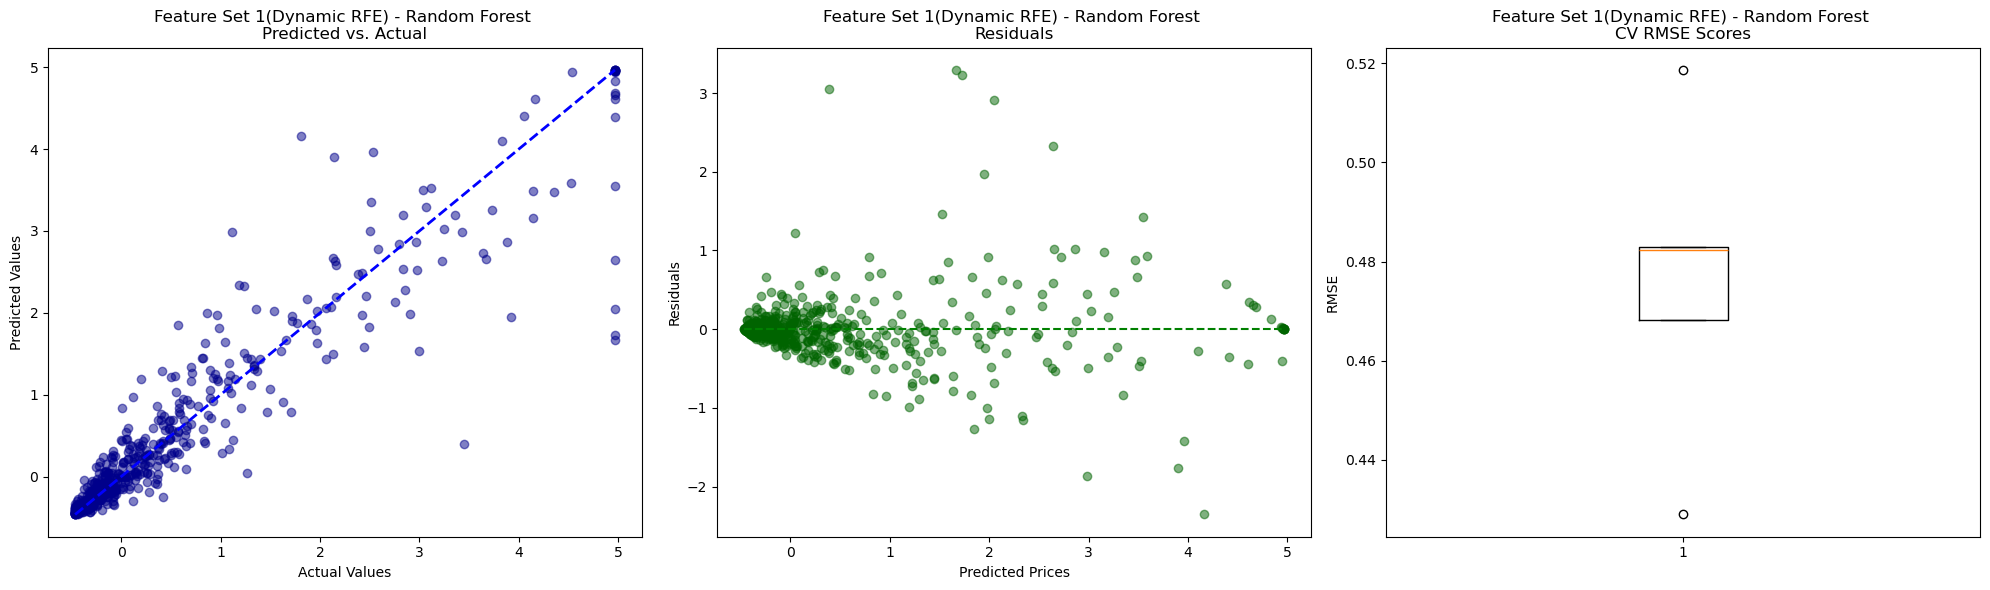

Plot saved to ../Results\Feature Set 1(Dynamic RFE)_Gradient Boosting_plots.png


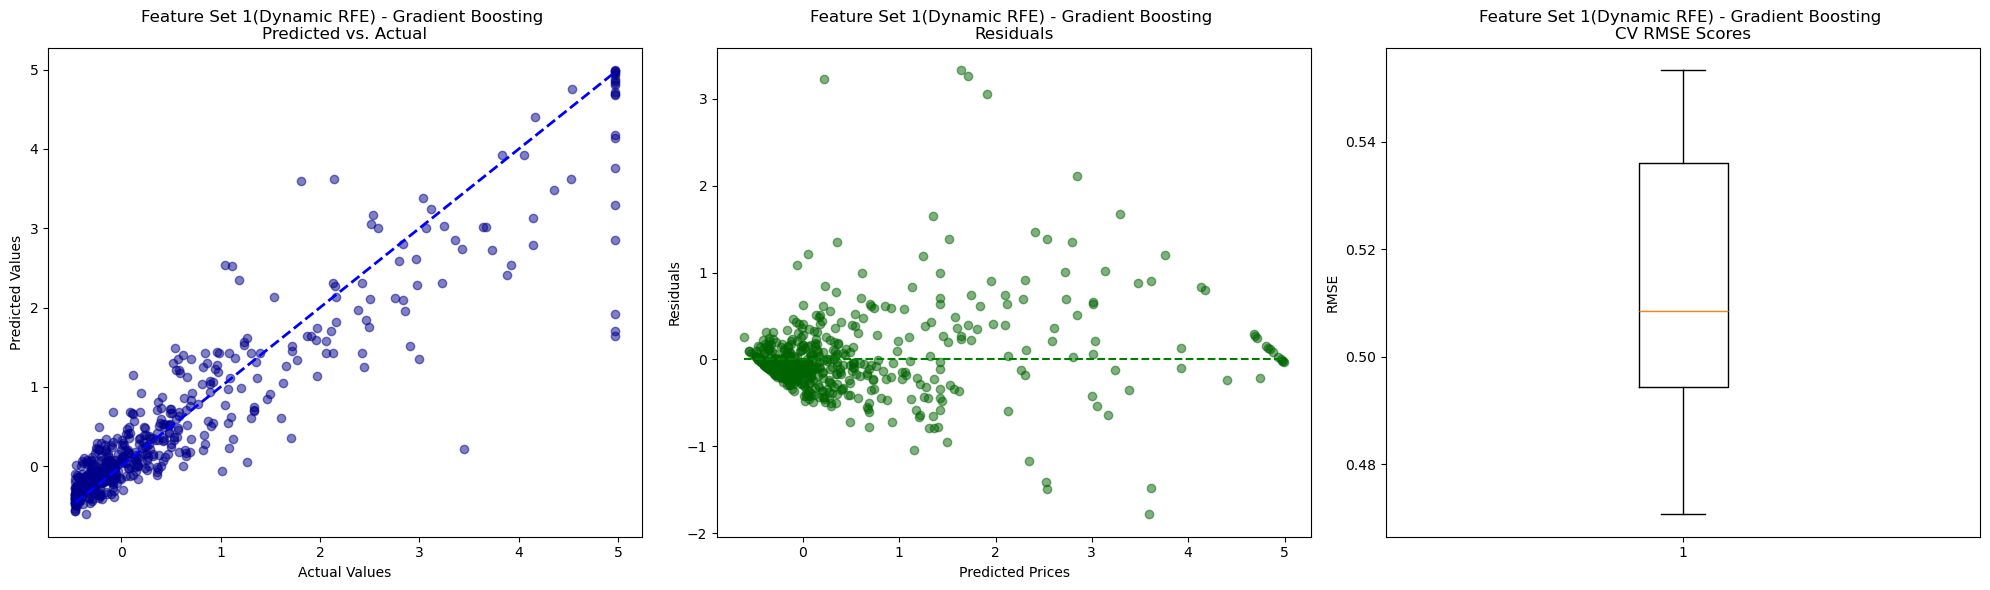

Plot saved to ../Results\Feature Set 1(Dynamic RFE)_Ridge Regression_plots.png


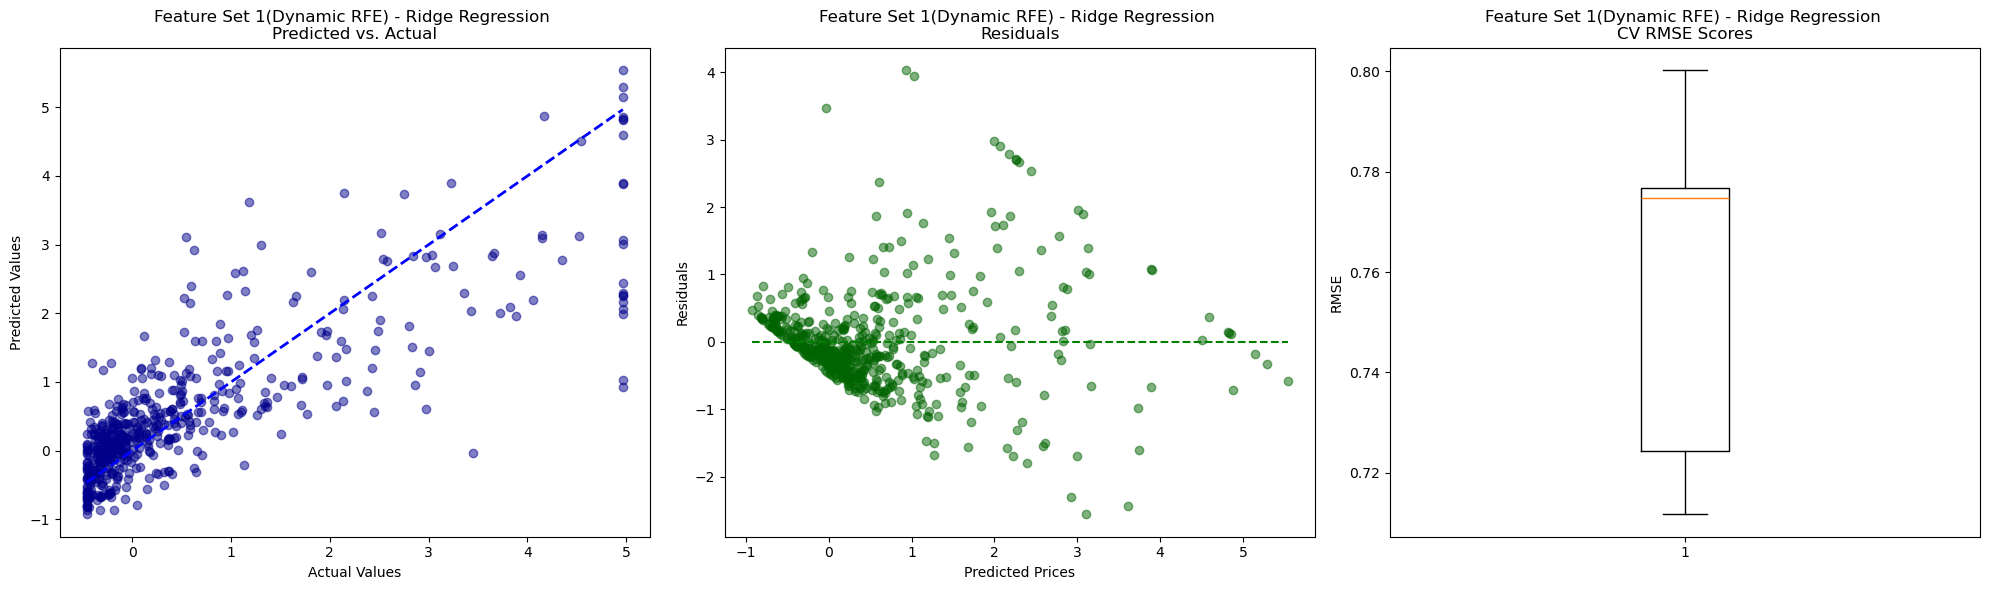

Plot saved to ../Results\Feature Set 1(Dynamic RFE)_Linear Regression_plots.png


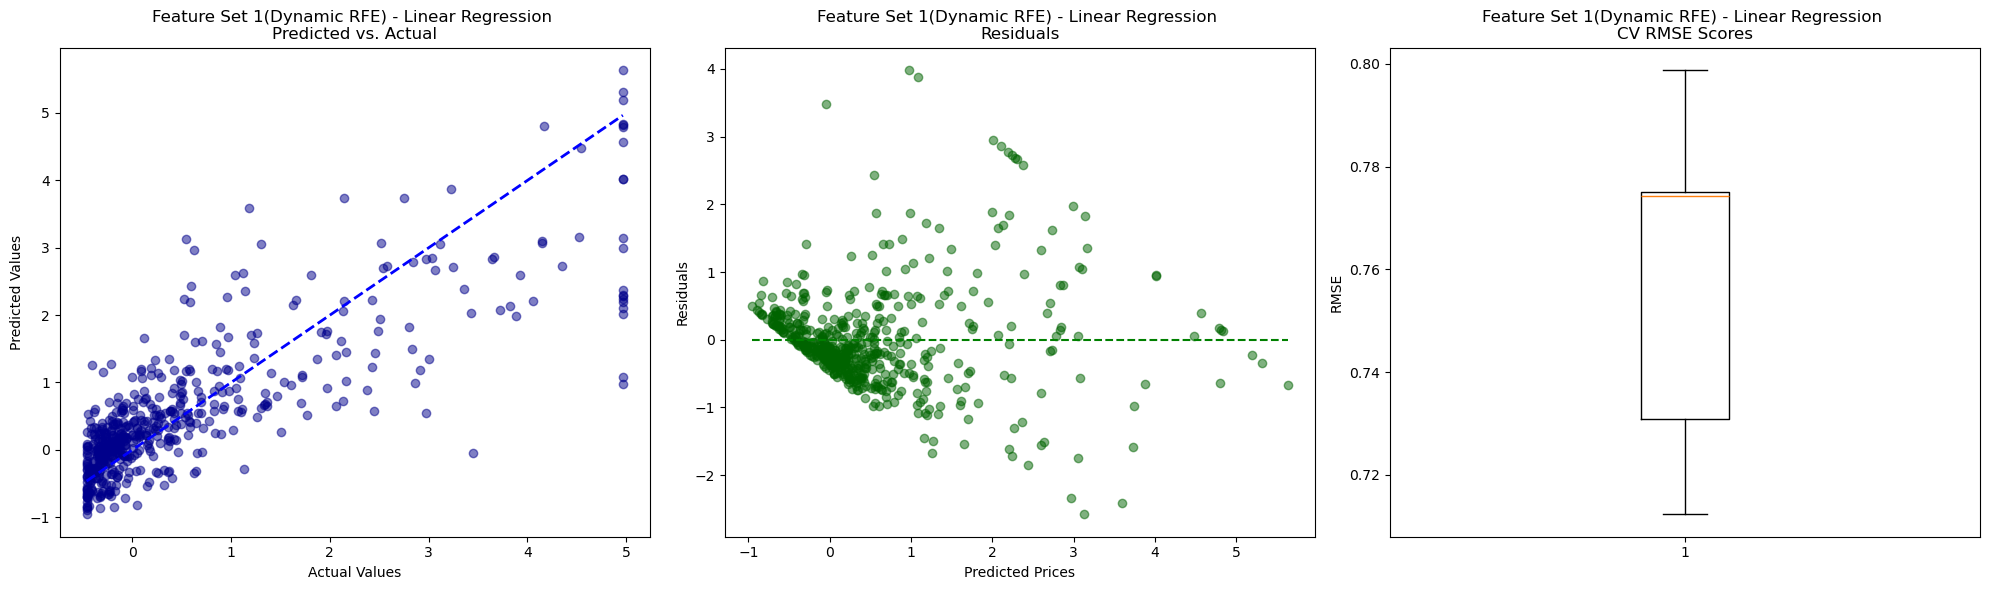

Plot saved to ../Results\Feature Set 2(Fixed RFE)_Random Forest_plots.png


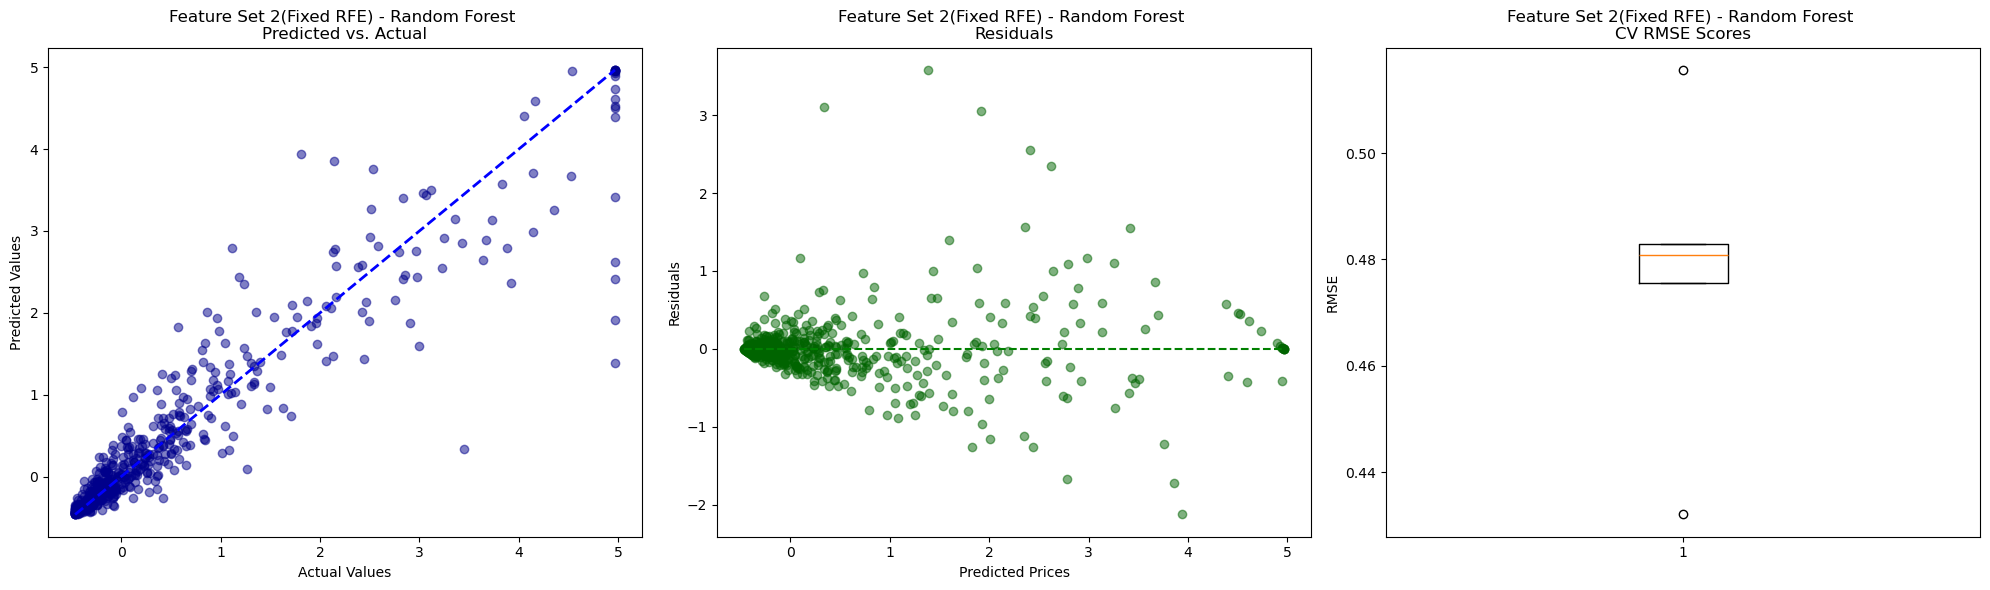

Plot saved to ../Results\Feature Set 2(Fixed RFE)_Gradient Boosting_plots.png


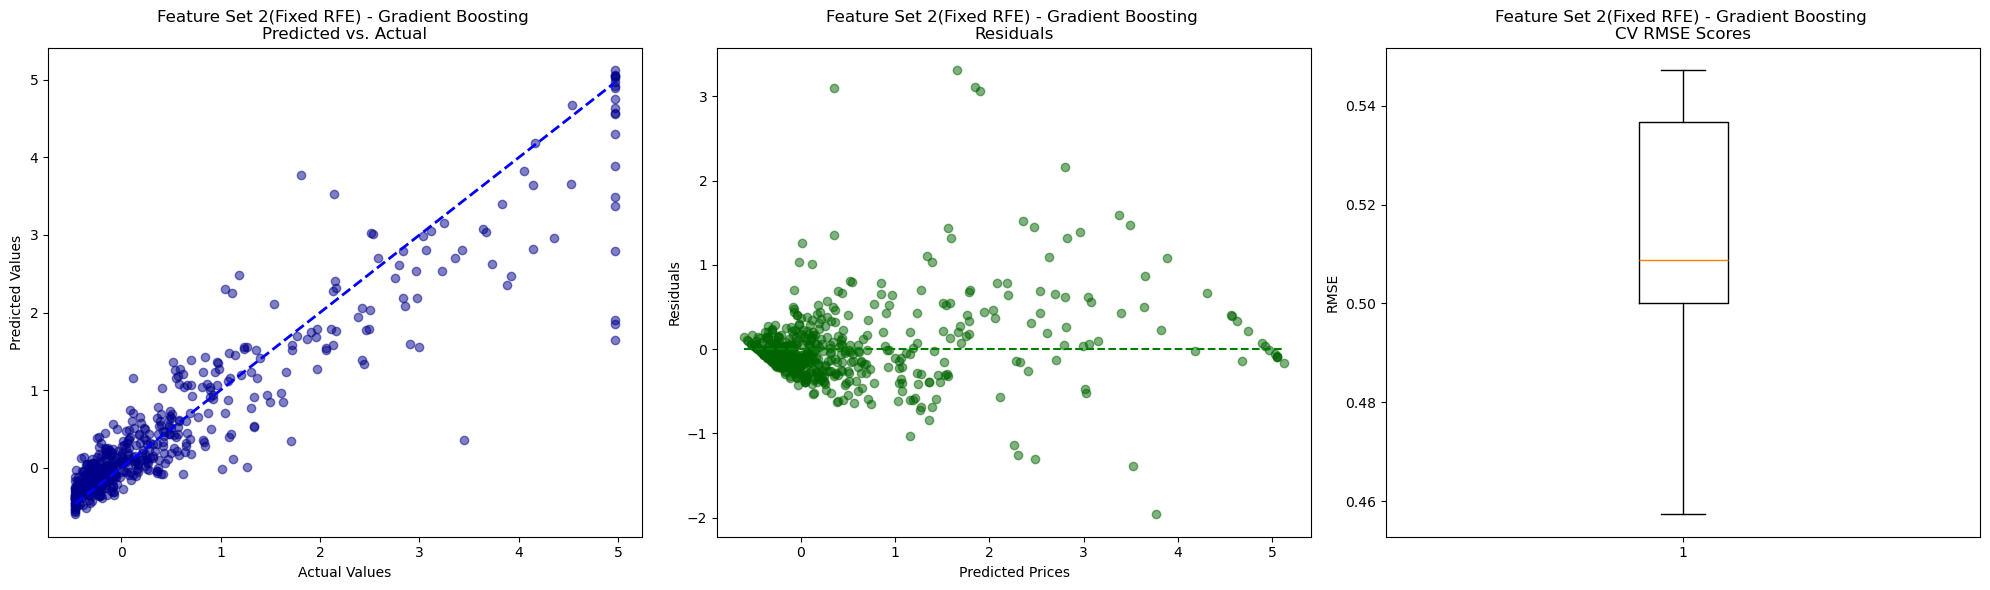

Plot saved to ../Results\Feature Set 2(Fixed RFE)_Ridge Regression_plots.png


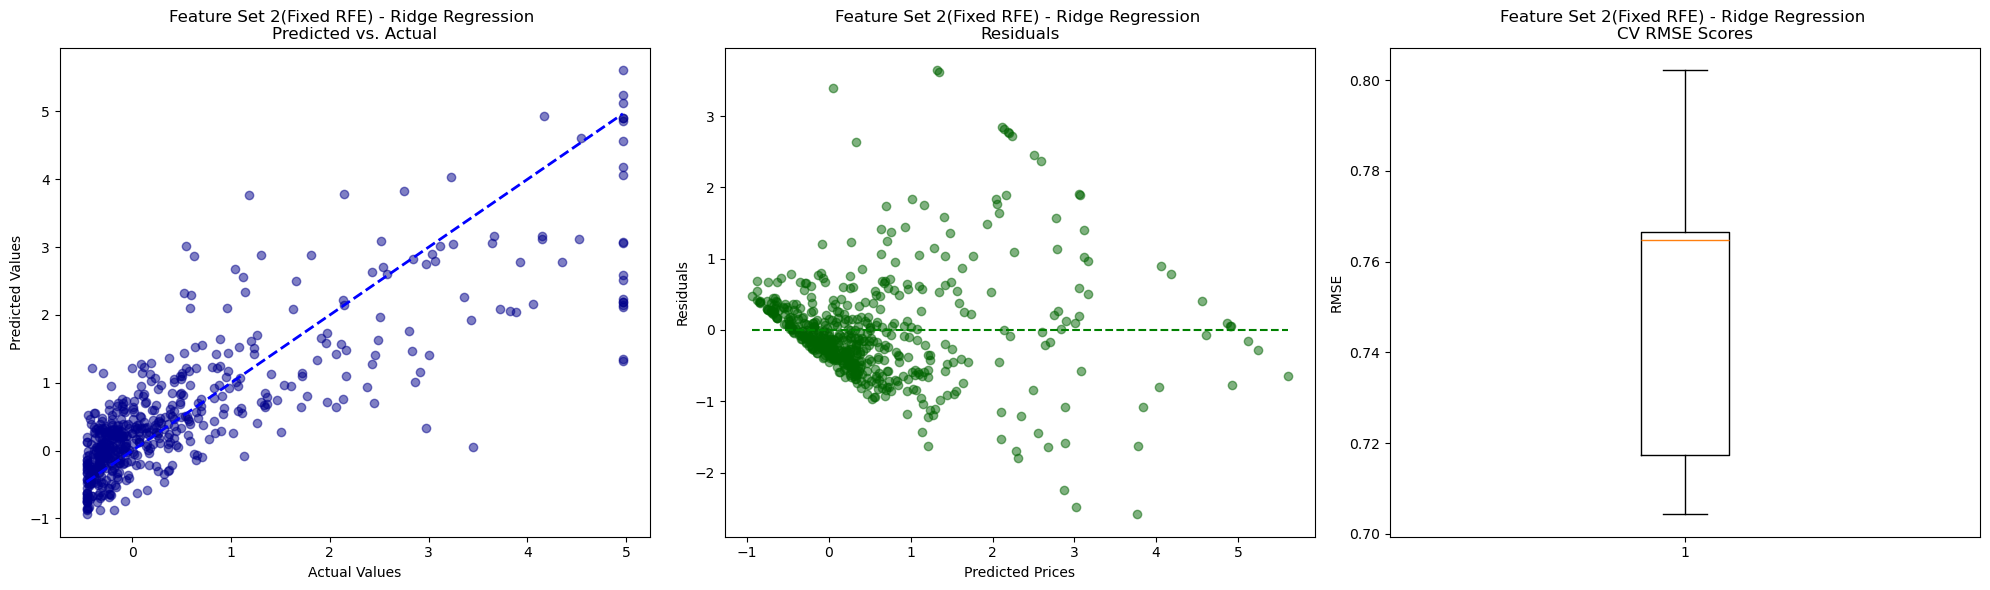

Plot saved to ../Results\Feature Set 2(Fixed RFE)_Linear Regression_plots.png


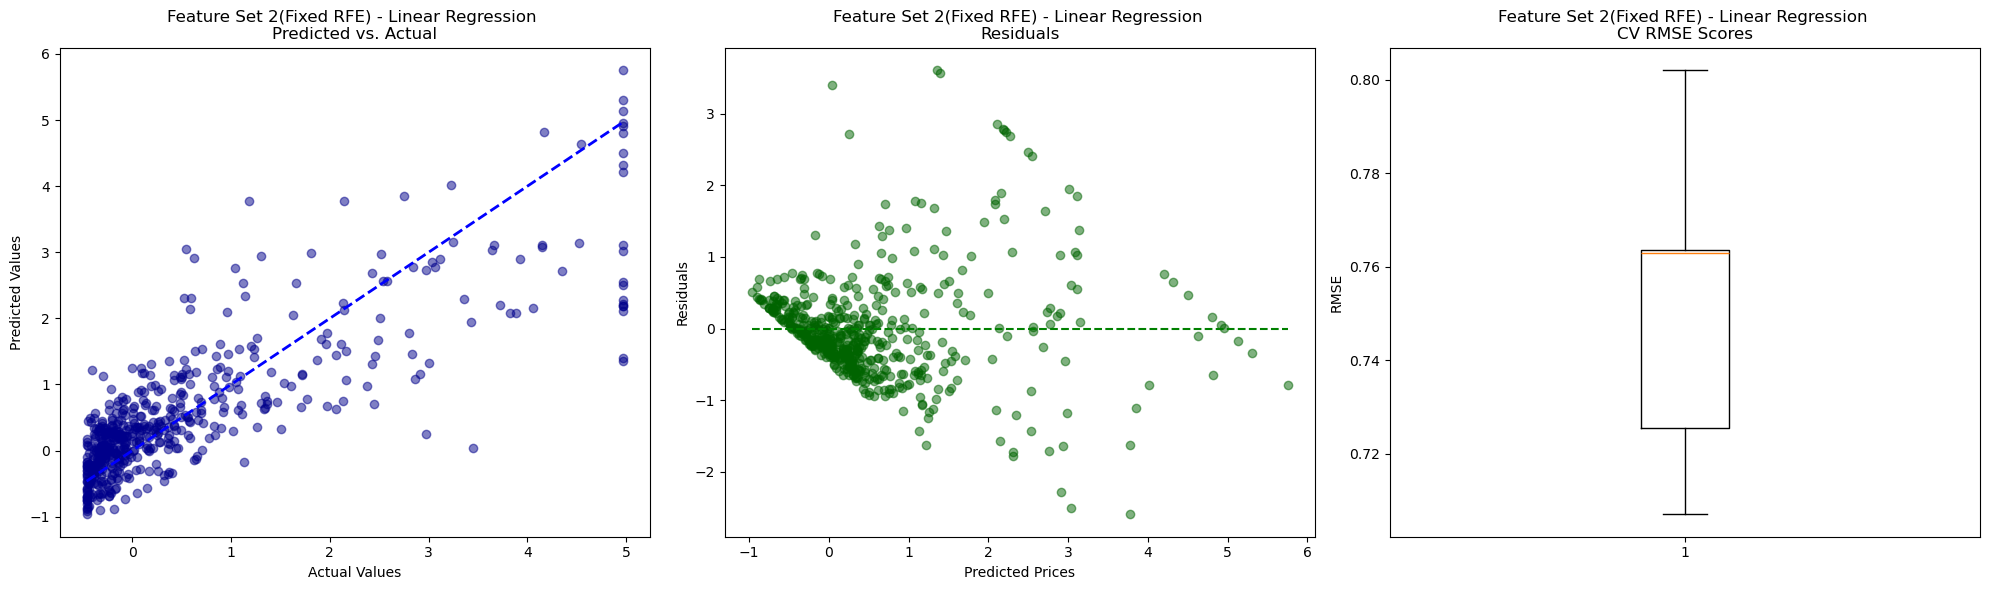

Plot saved to ../Results\Feature Set 3(Correlated)_Random Forest_plots.png


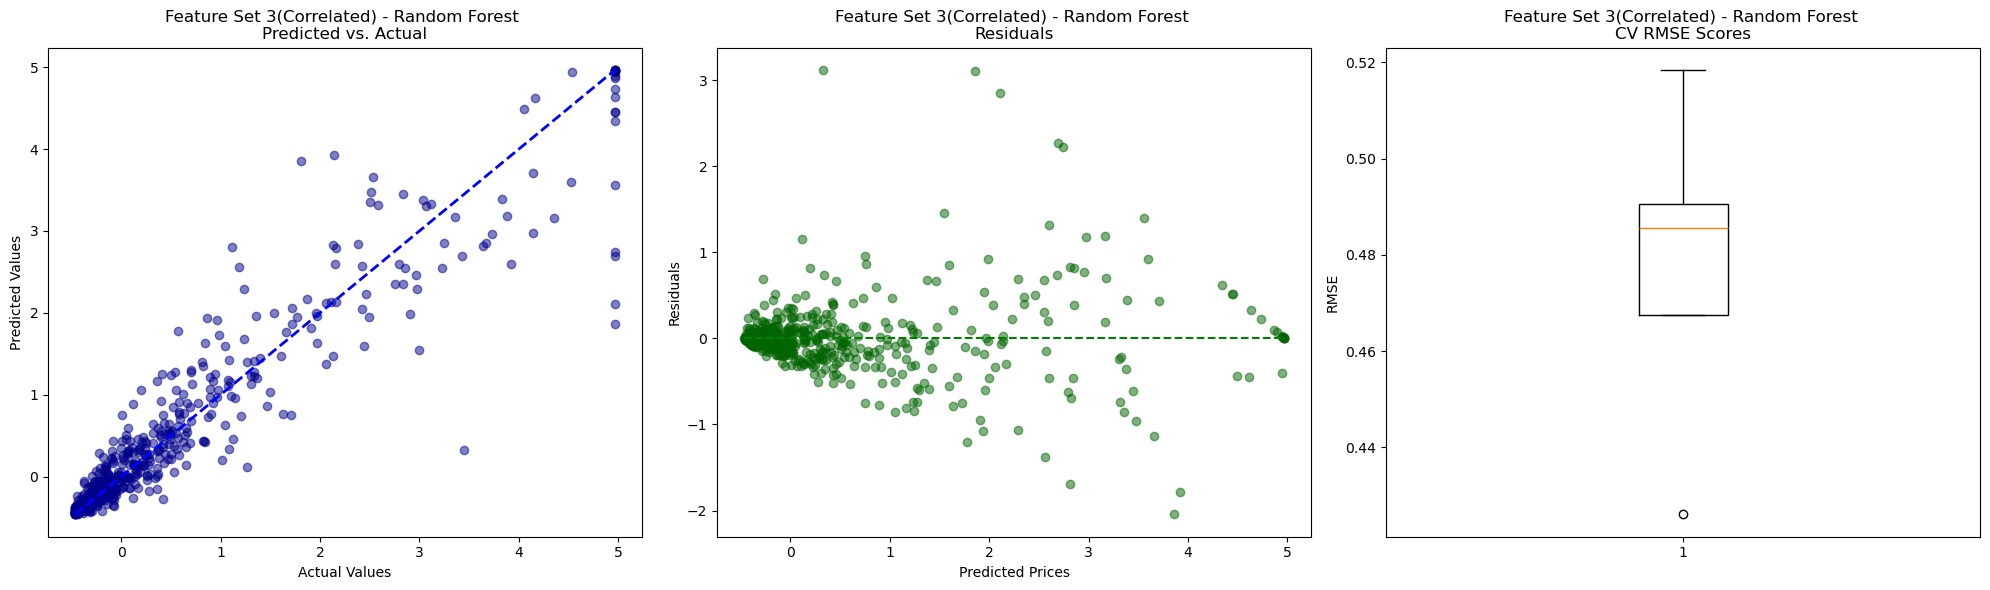

Plot saved to ../Results\Feature Set 3(Correlated)_Gradient Boosting_plots.png


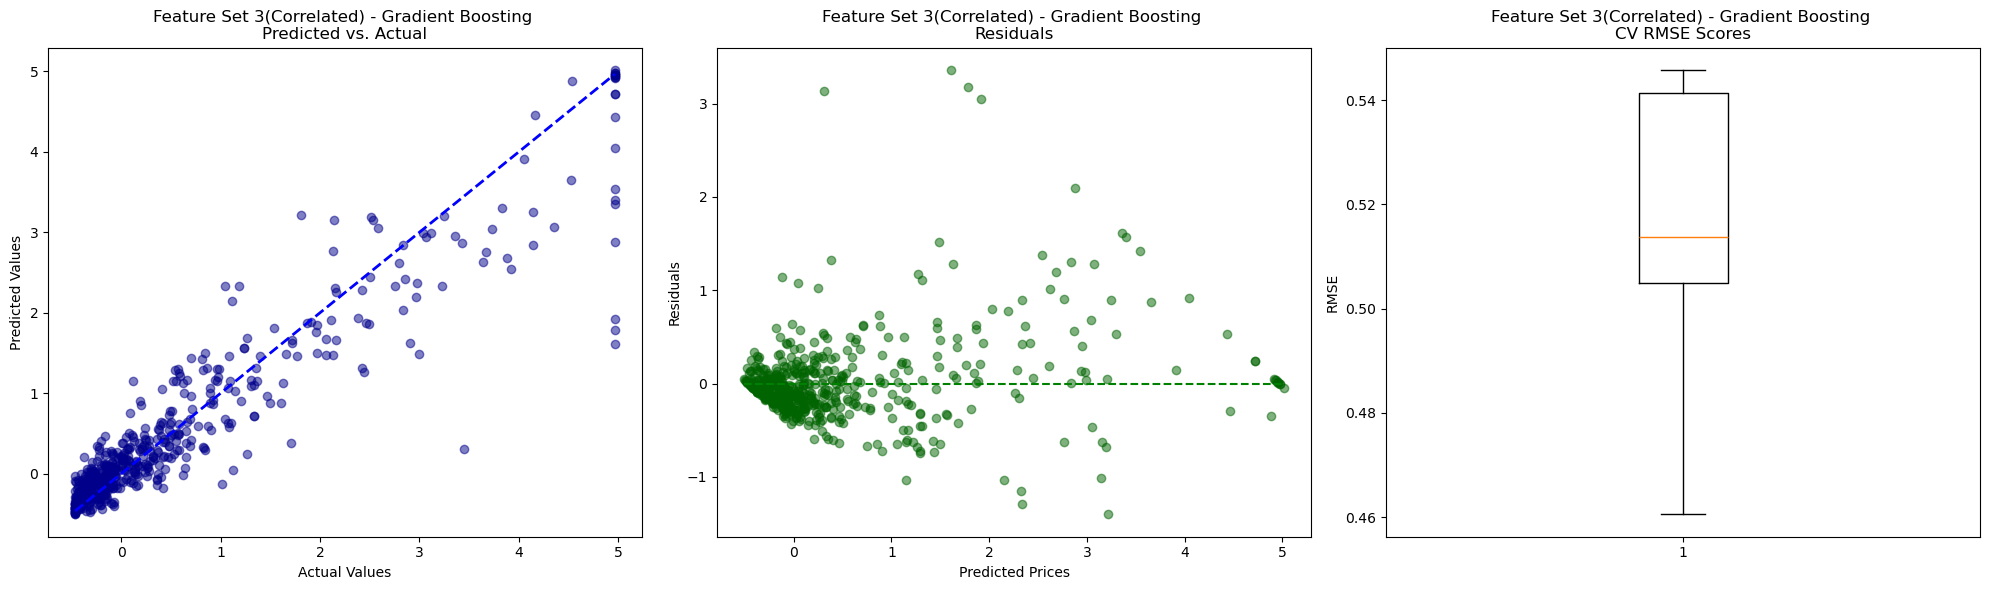

Plot saved to ../Results\Feature Set 3(Correlated)_Ridge Regression_plots.png


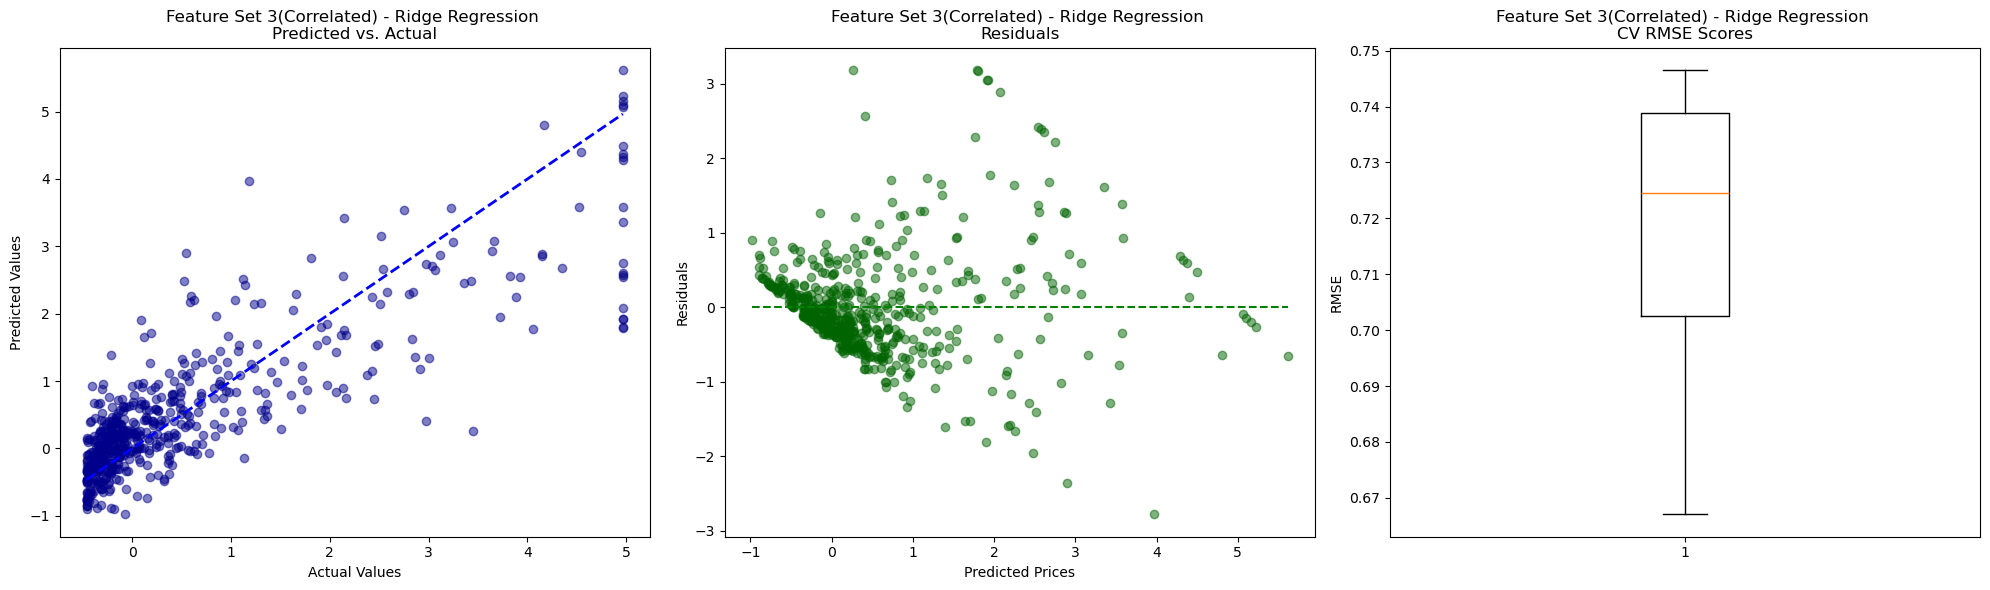

Plot saved to ../Results\Feature Set 3(Correlated)_Linear Regression_plots.png


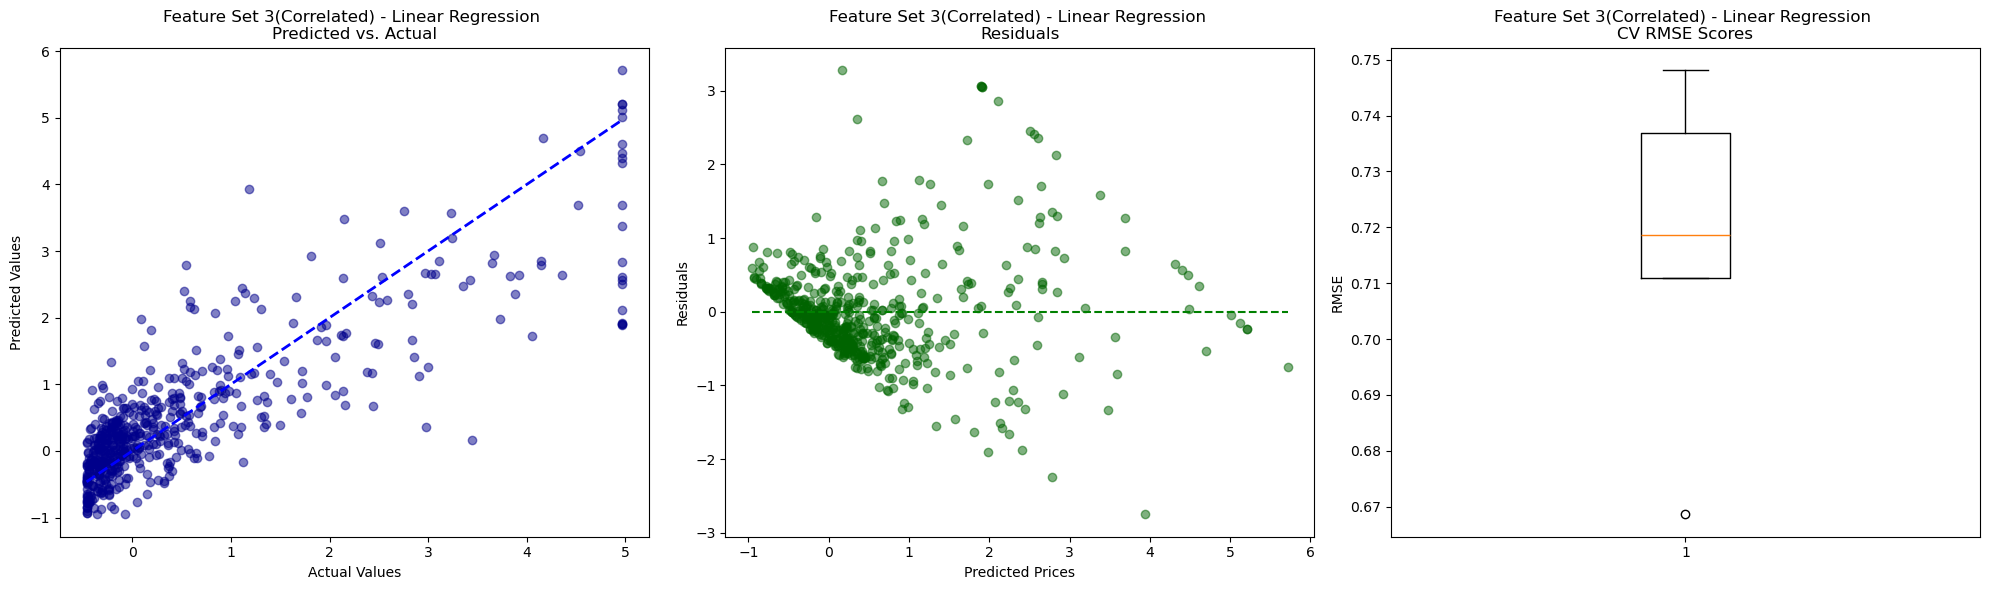

Plot saved to ../Results\Feature Set 4(Boosted IGA)_Random Forest_plots.png


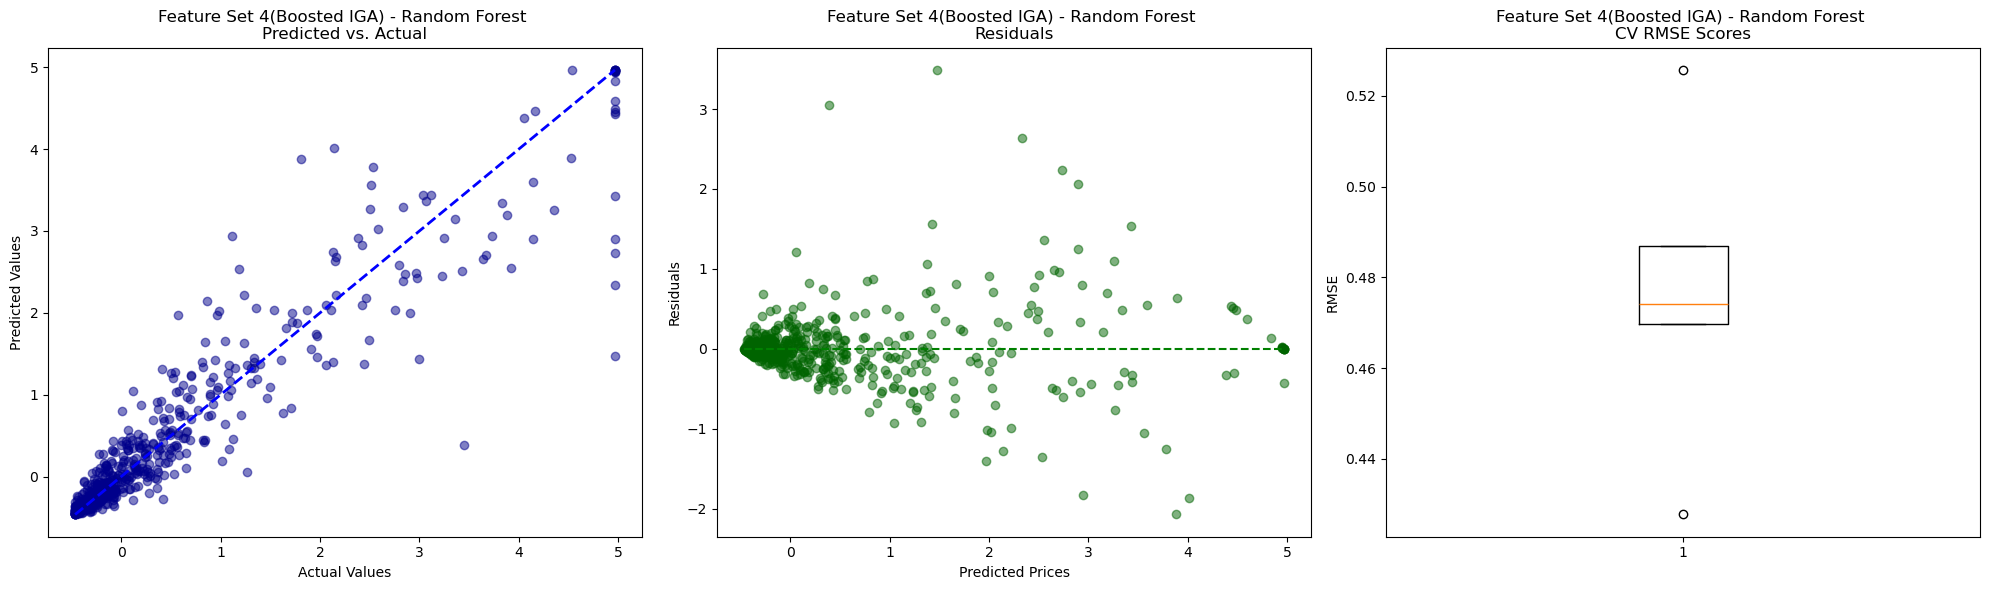

Plot saved to ../Results\Feature Set 4(Boosted IGA)_Gradient Boosting_plots.png


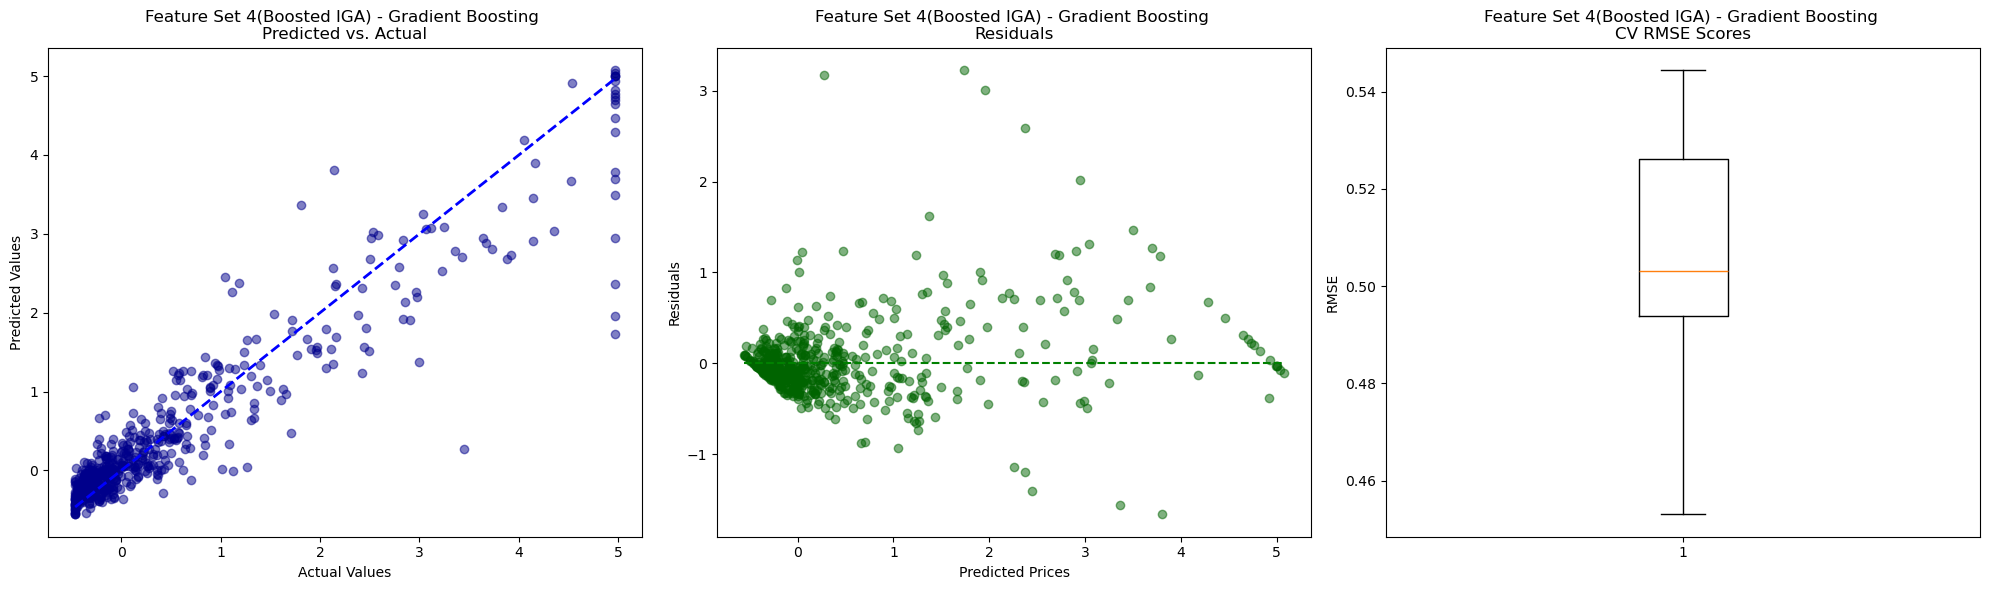

Plot saved to ../Results\Feature Set 4(Boosted IGA)_Ridge Regression_plots.png


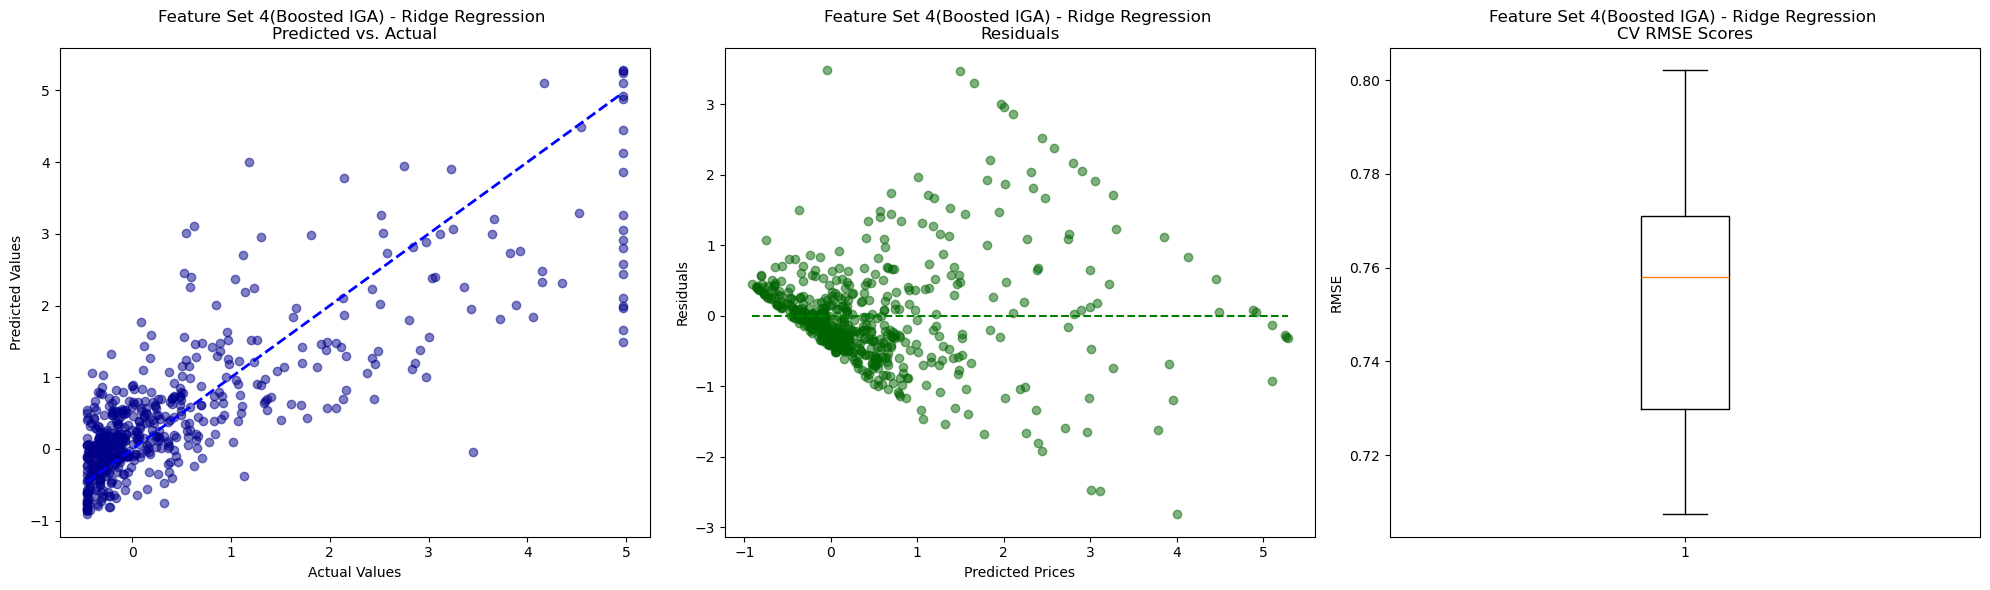

Plot saved to ../Results\Feature Set 4(Boosted IGA)_Linear Regression_plots.png


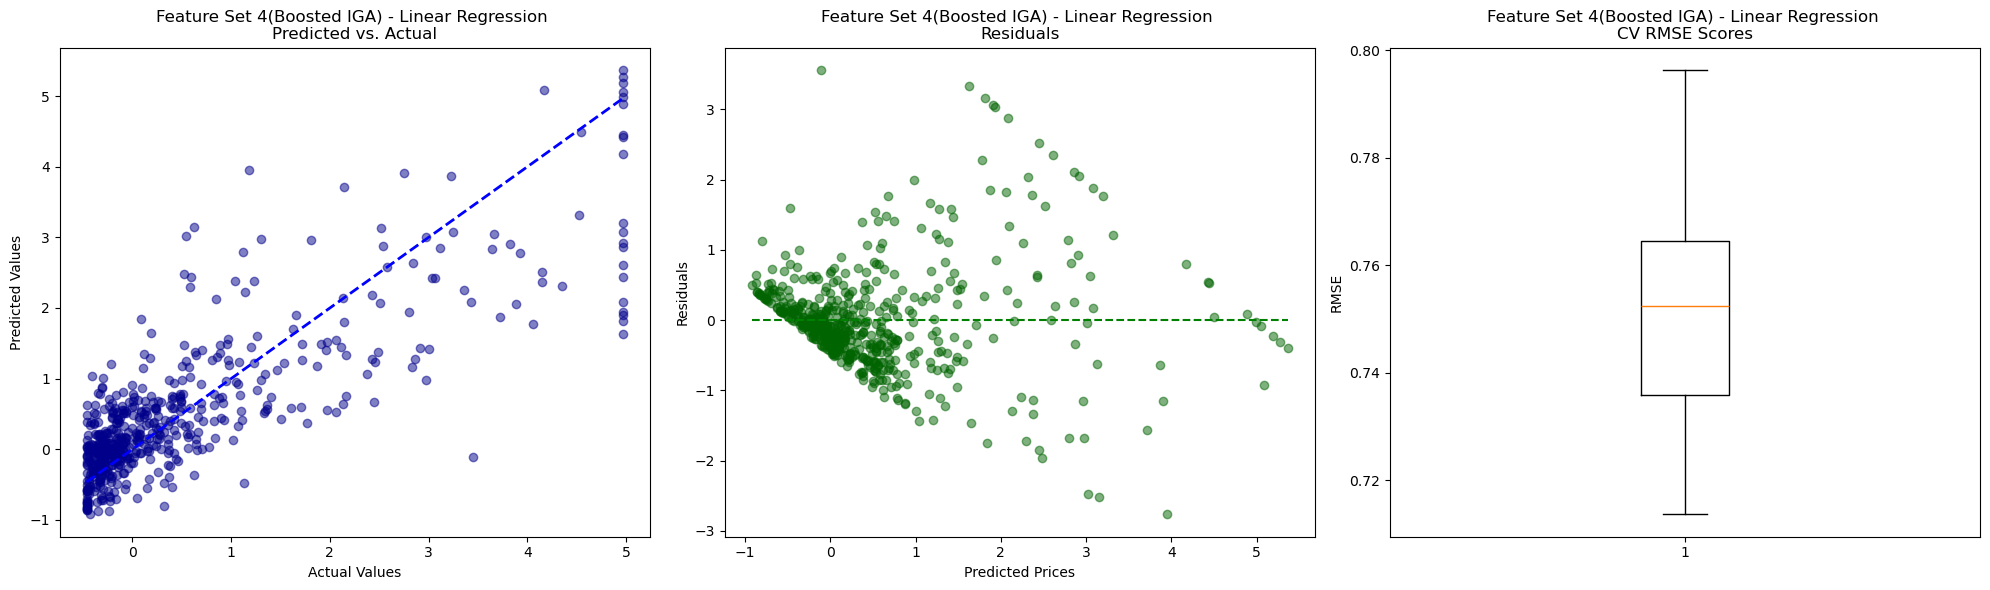

In [21]:

# Plotting and saving graphs in a specified directory
def plot_model_comparisons(all_results,  results_folder='../Results'):
    """
    The visualizations include scatter plots of predicted
    vs. actual values, residual plots, and box plots of cross-validation RMSE scores.
    """ 

    for feature_set_name, results in all_results.items():
        for model_name, result in results.items():
            fig, axs = plt.subplots(1, 3, figsize=(20, 6))
            y_test = result['y_test']
            y_pred = result['y_pred']
            font_size = 14
            title_font_size = 16

            # Plotting Predicted vs Actual
            axs[0].scatter(y_test, y_pred, alpha=0.5, color='darkblue')
            axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],'b--', lw=2)
            axs[0].set_title(f'{feature_set_name} - {model_name} \nPredicted vs. Actual')
            axs[0].set_xlabel('Actual Values')
            axs[0].set_ylabel('Predicted Values')

            # Plotting Residuals
            residuals = y_test - y_pred
            axs[1].scatter(y_pred, residuals, alpha=0.5, color='darkgreen')
            axs[1].hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), linestyles='dashed', color='green')
            axs[1].set_title(f'{feature_set_name} - {model_name} \nResiduals')
            axs[1].set_xlabel('Predicted Prices')
            axs[1].set_ylabel('Residuals')

            # Plotting CV RMSE Scores
            rmse_cv_scores = result['rmse_cv_scores']
            axs[2].boxplot(rmse_cv_scores)
            axs[2].set_title(f'{feature_set_name} - {model_name} \nCV RMSE Scores')
            axs[2].set_ylabel('RMSE')
            
            # Adjusting layout to prevent overlap
            fig.tight_layout()

            # Generating and formatting the filename for saving the plot
            plot_filename = os.path.join(results_folder, f"{feature_set_name}_{model_name}_plots.png")
            fig.savefig(plot_filename, format='png', dpi=300)
            print(f"Plot saved to {plot_filename}")
            plt.show()
            # Close the plot to free memory
            plt.close(fig)

plot_model_comparisons(all_results)

### XGBoost

In [22]:

# Identifing categorical columns for each feature set
categorical_cols_Boosted = X_train_Boosted.select_dtypes(include=['object']).columns
categorical_cols_Dynamic = X_train_dynamic.select_dtypes(include=['object']).columns
categorical_cols_Fixed = X_train_fixed.select_dtypes(include=['object']).columns
categorical_cols_Correlated = X_train_correlated.select_dtypes(include=['object']).columns

# Defining preprocessing pipelines with one-hot encoding for each feature set
preprocessor_Boosted = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_Boosted)
    ],
    remainder='passthrough'  # keep other columns unchanged
)

preprocessor_Dynamic = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_Dynamic)
    ],
    remainder='passthrough'  # keep other columns unchanged
)

preprocessor_Fixed = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_Fixed)
    ],
    remainder='passthrough'  # keep other columns unchanged
)

preprocessor_Correlated = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_Correlated)
    ],
    remainder='passthrough'  # keep other columns unchanged
)

# Preprocessing to the training and test data for each feature set
X_train_Boosted_enc = preprocessor_Boosted.fit_transform(X_train_Boosted)
X_test_Boosted_enc = preprocessor_Boosted.transform(X_test_Boosted)

X_train_fixed_enc = preprocessor_Fixed.fit_transform(X_train_fixed)
X_test_fixed_enc = preprocessor_Fixed.transform(X_test_fixed)

X_train_correlated_enc = preprocessor_Correlated.fit_transform(X_train_correlated)
X_test_correlated_enc = preprocessor_Correlated.transform(X_test_correlated)

X_train_Dynamic_enc = preprocessor_Dynamic.fit_transform(X_train_dynamic)
X_test_Dynamic_enc = preprocessor_Dynamic.transform(X_test_dynamic)

# Converting the preprocessed data to numpy arrays for model compatibility
X_train_Boosted_np = X_train_Boosted_enc.toarray() if hasattr(X_train_Boosted_enc, "toarray") else X_train_Boosted_enc
X_test_Boosted_np = X_test_Boosted_enc.toarray() if hasattr(X_test_Boosted_enc, "toarray") else X_test_Boosted_enc

X_train_Fixed_np = X_train_fixed_enc.toarray() if hasattr(X_train_fixed_enc, "toarray") else X_train_fixed_enc
X_test_Fixed_np = X_test_fixed_enc.toarray() if hasattr(X_test_fixed_enc, "toarray") else X_test_fixed_enc

X_train_Correlated_np = X_train_correlated_enc.toarray() if hasattr(X_train_correlated_enc, "toarray") else X_train_correlated_enc
X_test_Correlated_np = X_test_correlated_enc.toarray() if hasattr(X_test_correlated_enc, "toarray") else X_test_correlated_enc

X_train_Dynamic_np = X_train_Dynamic_enc.toarray() if hasattr(X_train_Dynamic_enc, "toarray") else X_train_Dynamic_enc
X_test_Dynamic_np = X_test_Dynamic_enc.toarray() if hasattr(X_test_Dynamic_enc, "toarray") else X_test_Dynamic_enc

# Defining a function to train the model, perform cross-validation, and evaluate on the test set
def train_and_evaluate(X_train_np, X_test_np, y_train_np, y_test_np, set_name):
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)
    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    # Performing cross-validation
    mae_cv = cross_val_score(xgb_model, X_train_np, y_train_np, cv=kf, scoring='neg_mean_absolute_error')
    mse_cv = cross_val_score(xgb_model, X_train_np, y_train_np, cv=kf, scoring='neg_mean_squared_error')
    rmse_cv = np.sqrt(-cross_val_score(xgb_model, X_train_np, y_train_np, cv=kf, scoring='neg_mean_squared_error'))
    r2_cv = cross_val_score(xgb_model, X_train_np, y_train_np, cv=kf, scoring='r2')

    # Training the model on the entire training set and predict on the test set
    xgb_model.fit(X_train_np, y_train_np)
    y_pred = xgb_model.predict(X_test_np)

    # Calculating evaluation metrics on the test set
    mae = mean_absolute_error(y_test_np, y_pred)
    mse = mean_squared_error(y_test_np, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_np, y_pred)

    # Returning all results in a dictionary 
    return {
        'mean_mae_cv_score': -mae_cv.mean(),
        'mean_mse_cv_score': -mse_cv.mean(),
        'mean_rmse_cv_score': np.mean(rmse_cv),
        'mean_r2_cv_score': r2_cv.mean(),
        'mae_cv_scores': -mae_cv,
        'mse_cv_scores': -mse_cv,
        'rmse_cv_scores': rmse_cv,
        'r2_cv_scores': r2_cv,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'y_test': y_test_np,  # keeping it as numpy array or converting to list if needed
        'y_pred': y_pred
    }

# function to evaluate and capture the results
feature_sets = {
    'Feature Set 1(Dynamic RFE)': (X_train_Dynamic_np, X_test_Dynamic_np),
    'Feature Set 2(Fixed RFE)': (X_train_Fixed_np, X_test_Fixed_np),
    'Feature Set 3(Correlated)': (X_train_Correlated_np, X_test_Correlated_np),
    'Feature Set 4(Boosted IGA)': (X_train_Boosted_np, X_test_Boosted_np)
}

all_xgb_results = {}
for feature_set_name, (X_train_np, X_test_np) in feature_sets.items():
    all_xgb_results[feature_set_name] = {
        'XGBoost': train_and_evaluate(X_train_np, X_test_np, y_train.values, y_test.values, feature_set_name)
    }

# Printing the results for each feature set and model
for feature_set_name, results in all_xgb_results.items():
    print(f"Results for {feature_set_name}:")
    for model_name, result in results.items():
        print(f"{model_name} - Cross-Validation Scores:")
        print(f"  Mean MAE CV Score: {result['mean_mae_cv_score']}, CV Scores: {result['mae_cv_scores']}")
        print(f"  Mean MSE CV Score: {result['mean_mse_cv_score']}, CV Scores: {result['mse_cv_scores']}")
        print(f"  Mean RMSE CV Score: {result['mean_rmse_cv_score']}, CV Scores: {result['rmse_cv_scores']}")
        print(f"  Mean R² CV Score: {result['mean_r2_cv_score']}, CV Scores: {result['r2_cv_scores']}")
        print(f"Test Performance:")
        print(f"  MAE: {result['mae']}, MSE: {result['mse']}, RMSE: {result['rmse']}, R²: {result['r2']}\n")

info_logger.info("Tested and trained with XG boost model")

Results for Feature Set 1(Dynamic RFE):
XGBoost - Cross-Validation Scores:
  Mean MAE CV Score: 0.25046514241979745, CV Scores: [0.23612281 0.24432269 0.22711598 0.2889591  0.25580512]
  Mean MSE CV Score: 0.25701254932562334, CV Scores: [0.19476962 0.25631016 0.17399127 0.38737554 0.27261616]
  Mean RMSE CV Score: 0.5018484263978651, CV Scores: [0.44132712 0.50627083 0.41712261 0.622395   0.52212657]
  Mean R² CV Score: 0.8682245188425387, CV Scores: [0.88820224 0.86272483 0.90665512 0.81903033 0.86451008]
Test Performance:
  MAE: 0.229987319524756, MSE: 0.22611440103826091, RMSE: 0.47551487993359465, R²: 0.8687514954753216

Results for Feature Set 2(Fixed RFE):
XGBoost - Cross-Validation Scores:
  Mean MAE CV Score: 0.2514774404023677, CV Scores: [0.24236463 0.24455232 0.22993736 0.28111998 0.2594129 ]
  Mean MSE CV Score: 0.2542204994183659, CV Scores: [0.20754425 0.24958091 0.18740456 0.3509857  0.27558708]
  Mean RMSE CV Score: 0.5010915613979278, CV Scores: [0.45557025 0.49958073

Plot saved to ../Results\Feature Set 1(Dynamic RFE)_Random Forest_plots.png


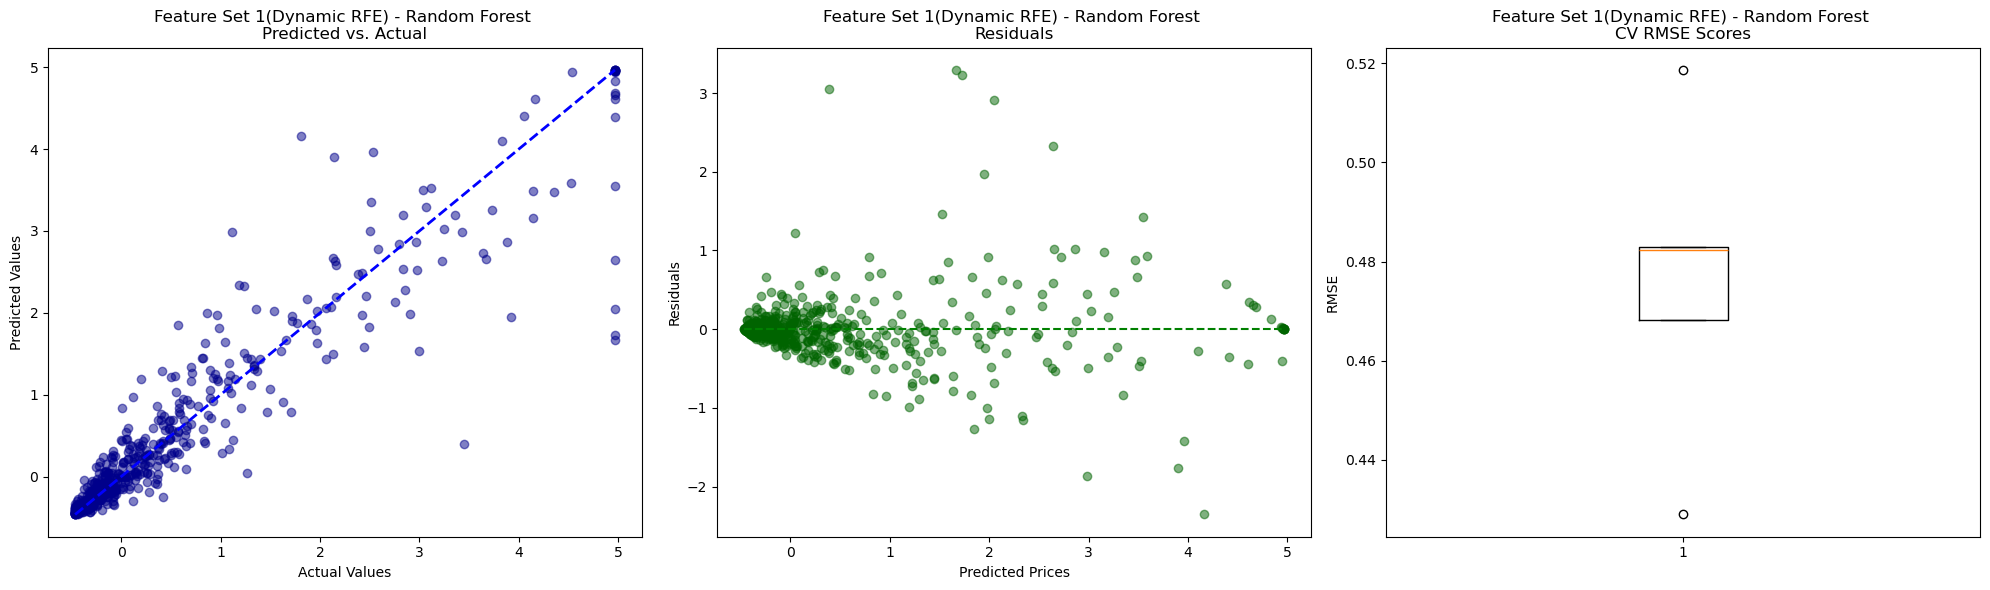

Plot saved to ../Results\Feature Set 1(Dynamic RFE)_Gradient Boosting_plots.png


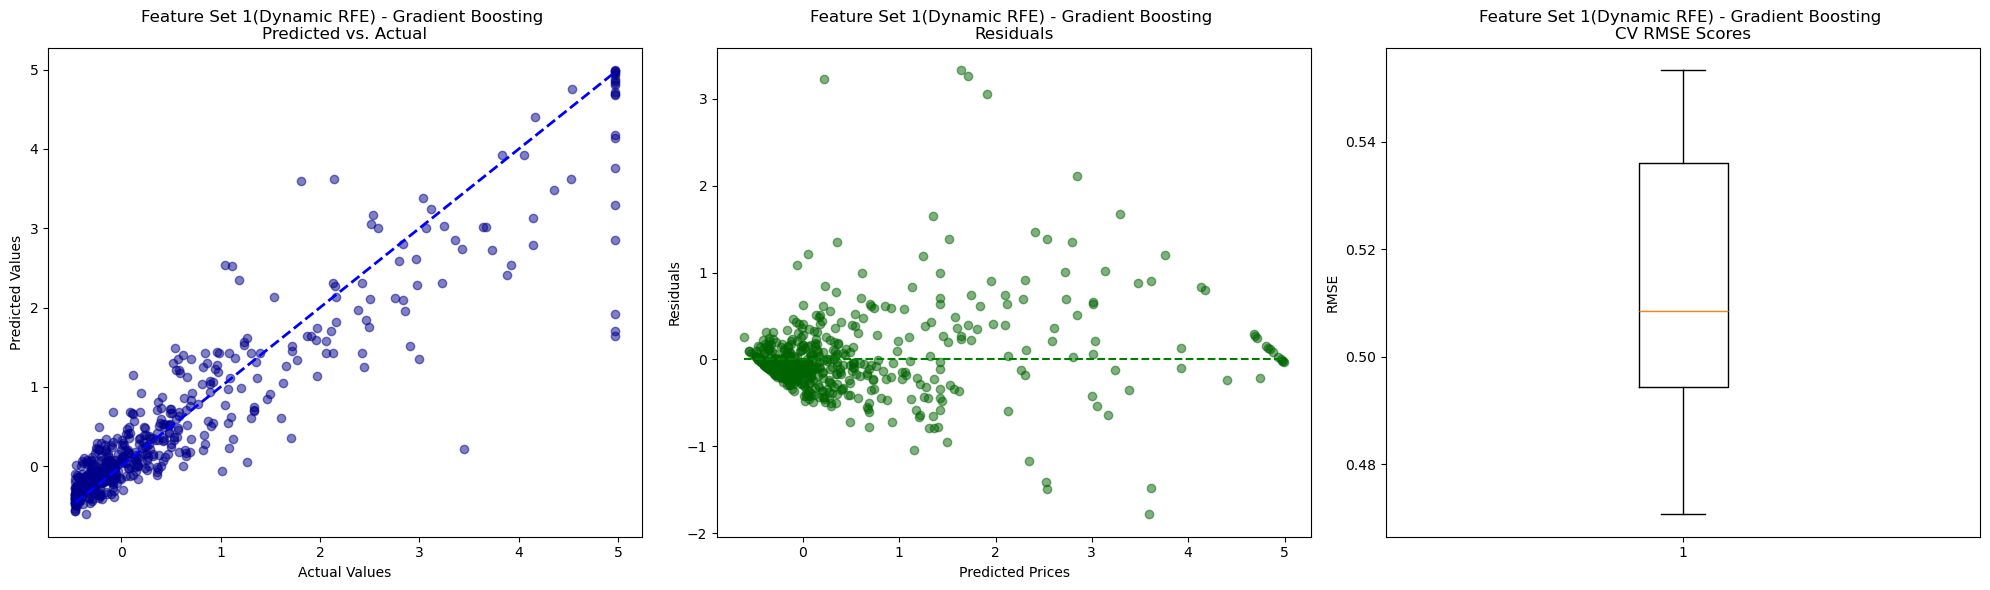

Plot saved to ../Results\Feature Set 1(Dynamic RFE)_Ridge Regression_plots.png


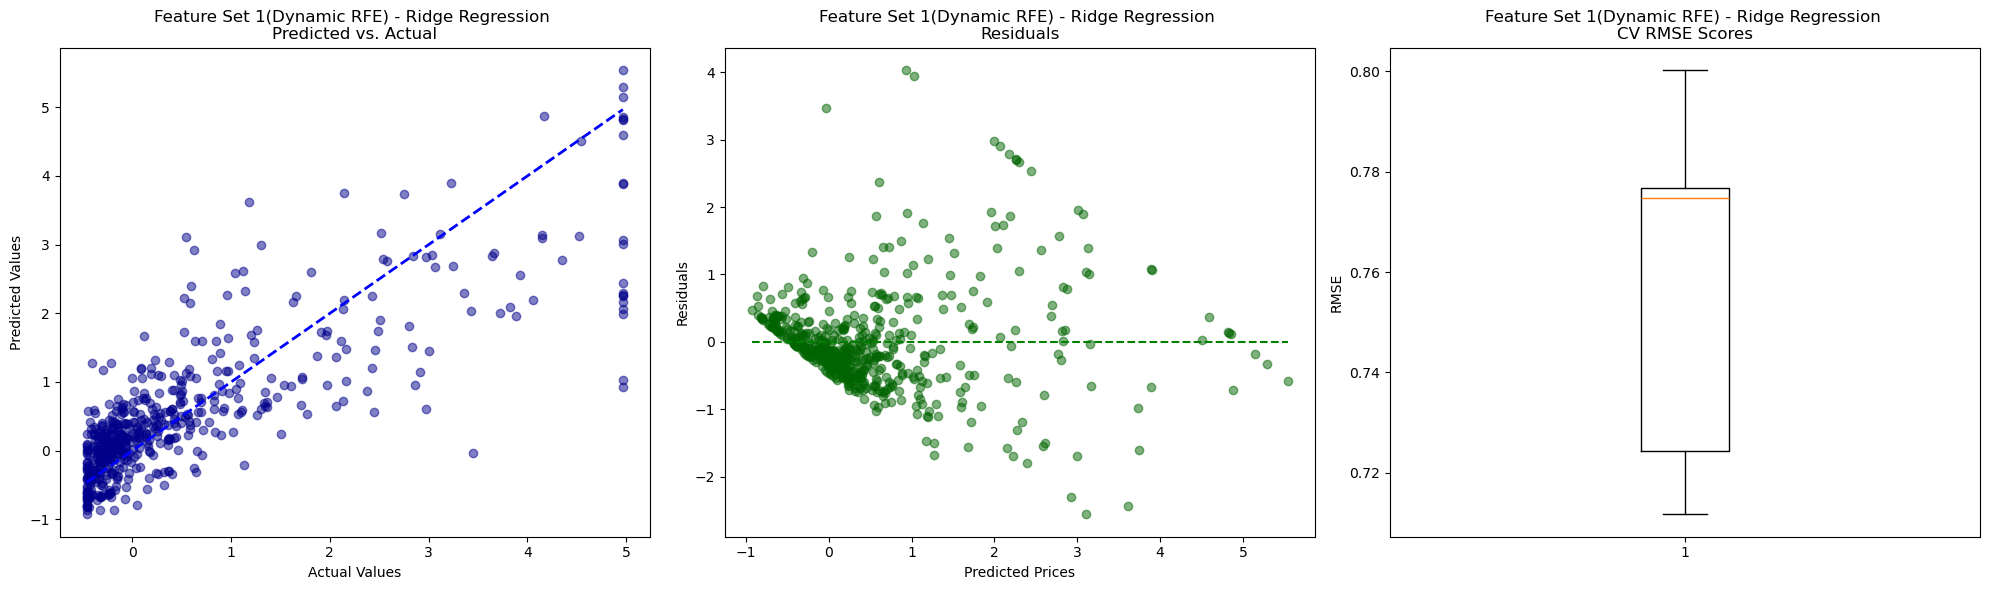

Plot saved to ../Results\Feature Set 1(Dynamic RFE)_Linear Regression_plots.png


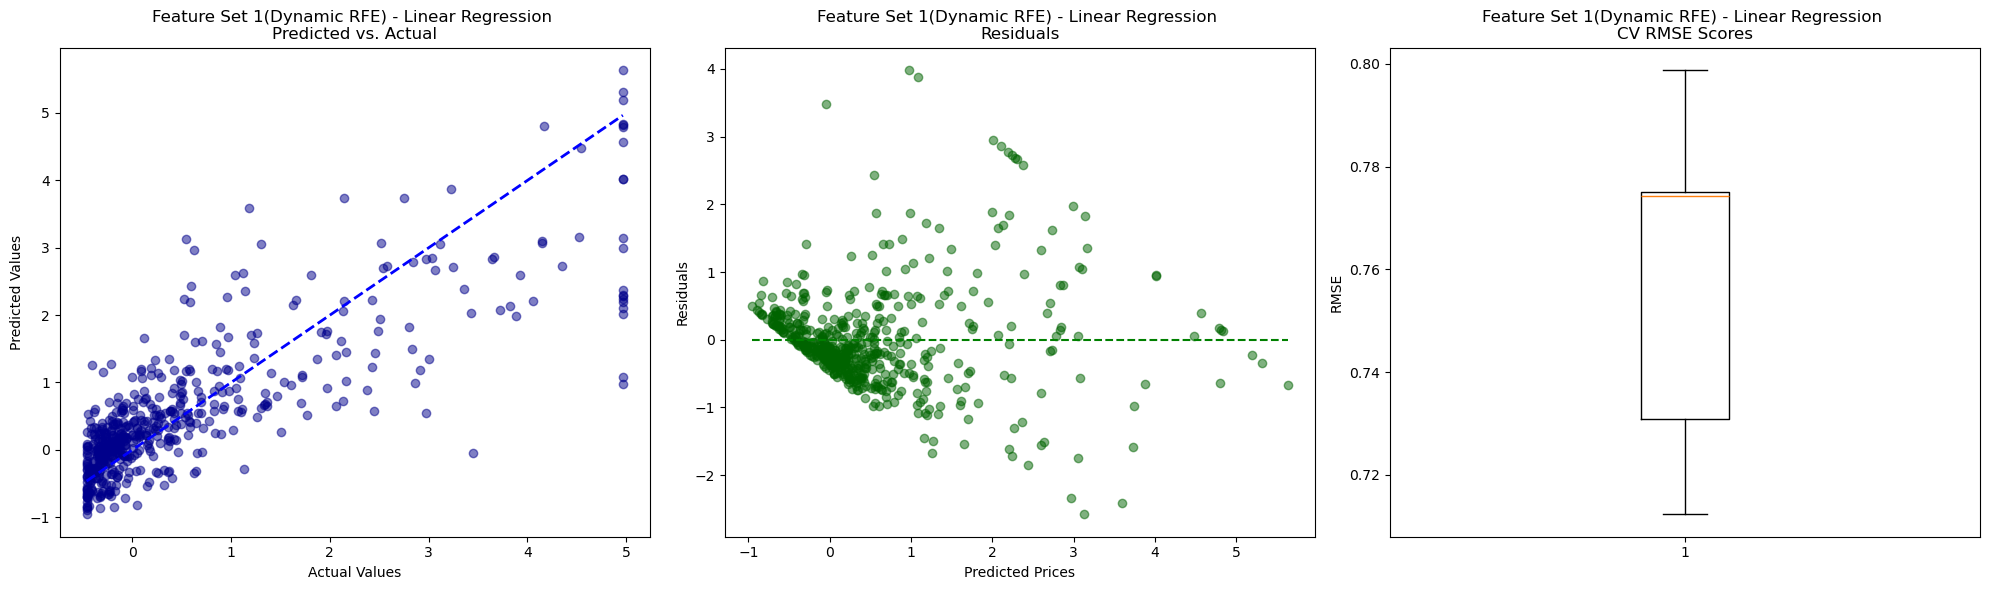

Plot saved to ../Results\Feature Set 2(Fixed RFE)_Random Forest_plots.png


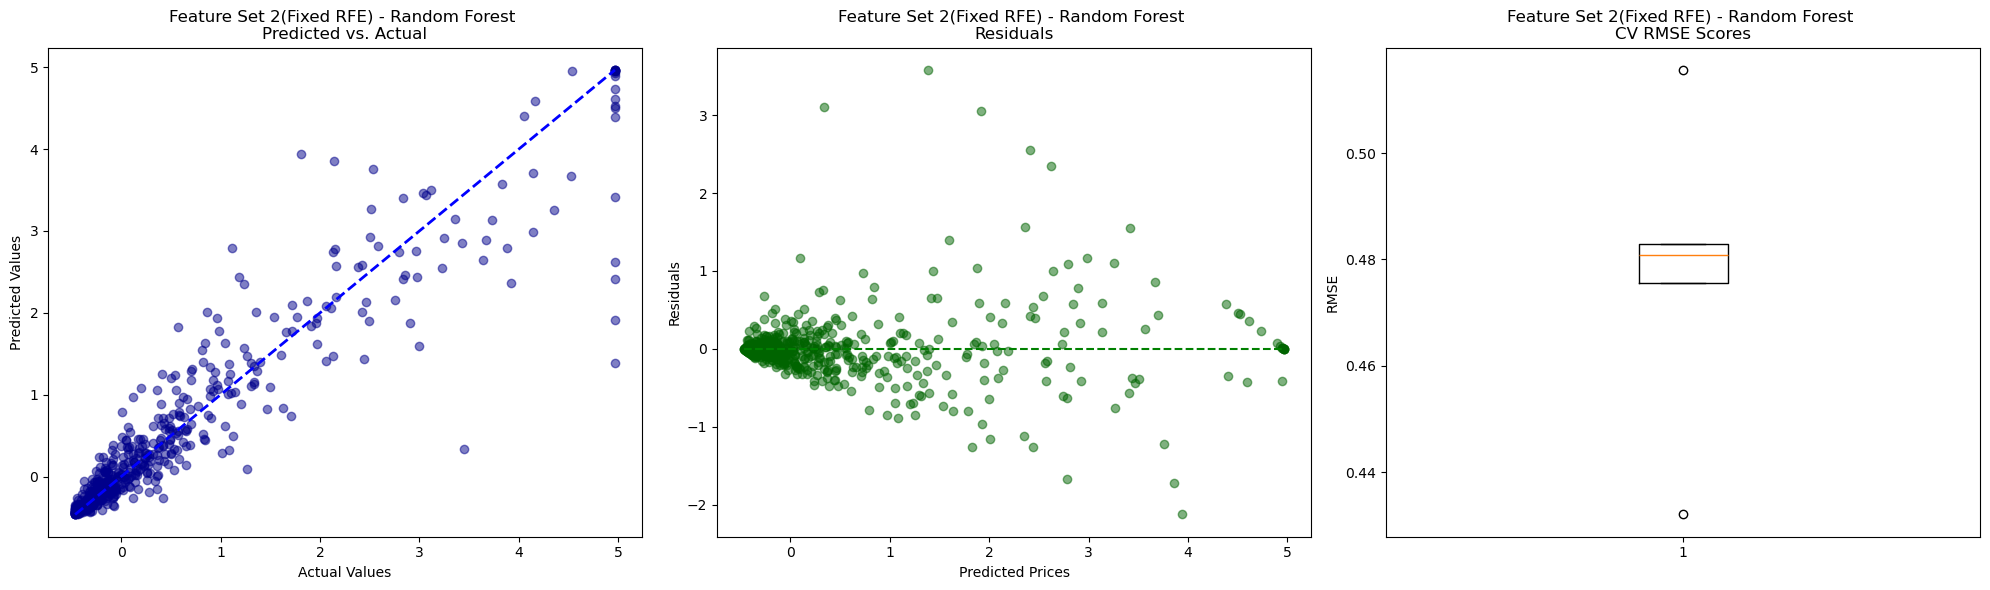

Plot saved to ../Results\Feature Set 2(Fixed RFE)_Gradient Boosting_plots.png


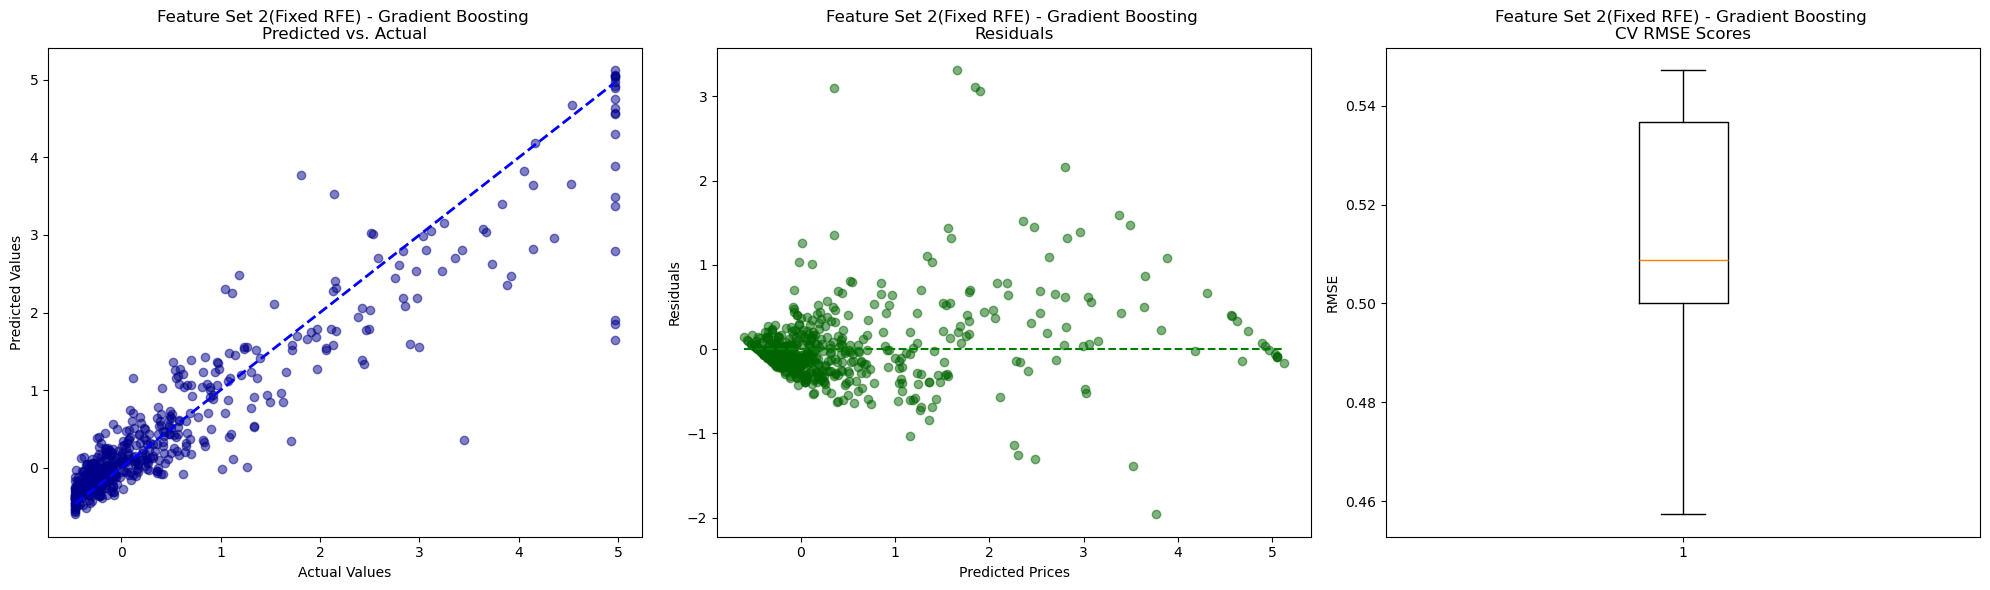

Plot saved to ../Results\Feature Set 2(Fixed RFE)_Ridge Regression_plots.png


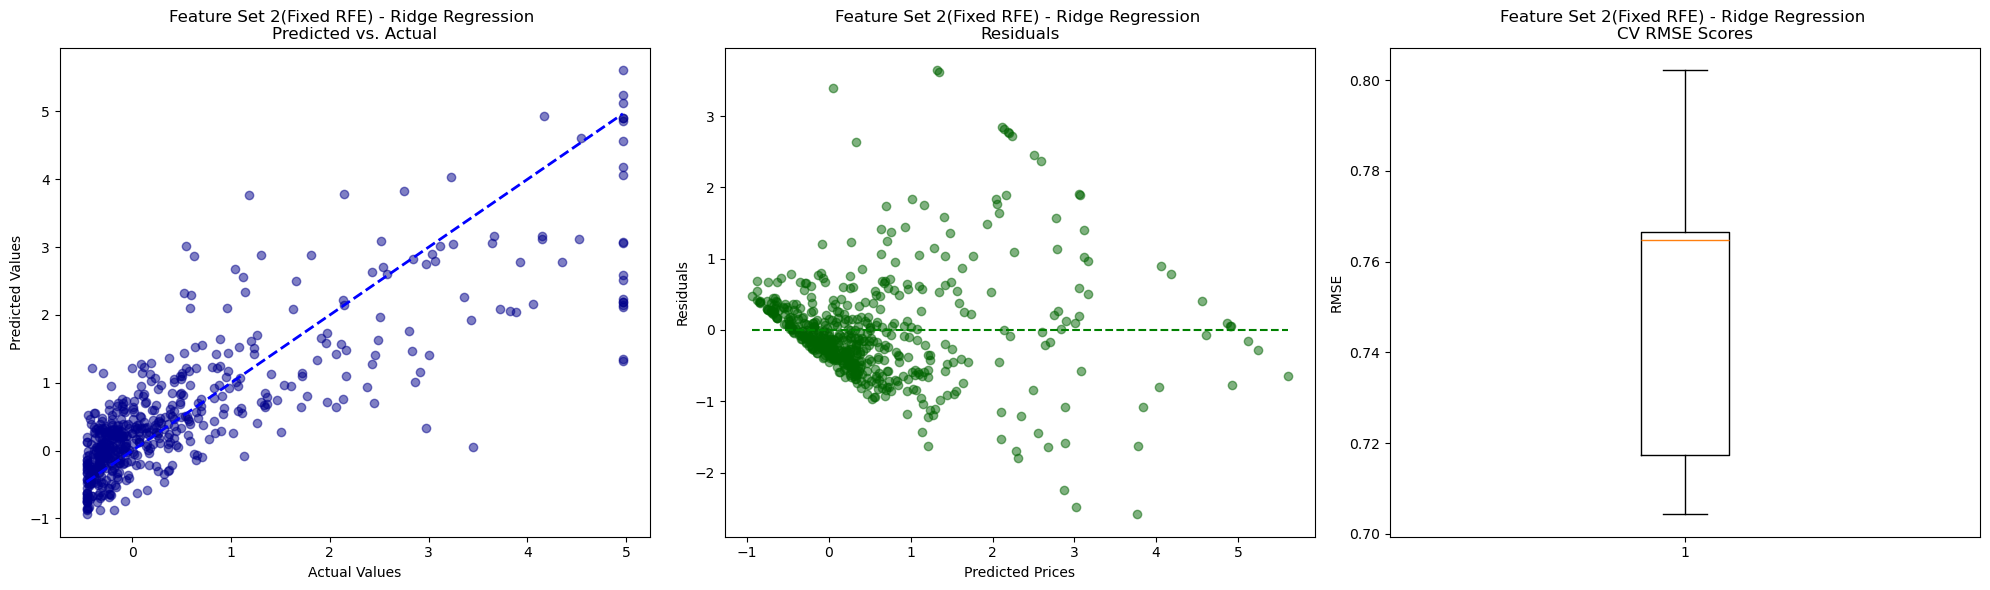

Plot saved to ../Results\Feature Set 2(Fixed RFE)_Linear Regression_plots.png


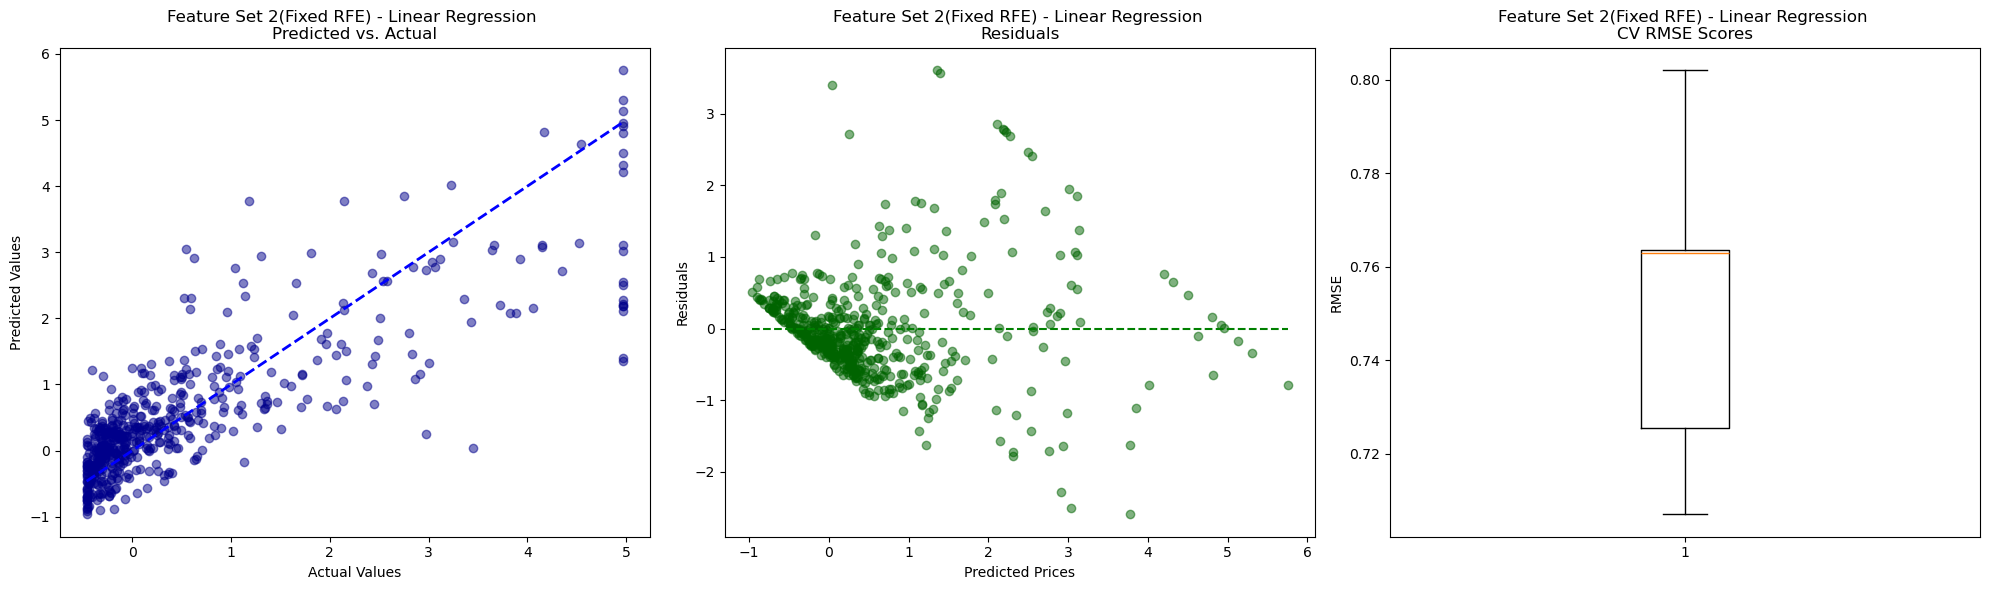

Plot saved to ../Results\Feature Set 3(Correlated)_Random Forest_plots.png


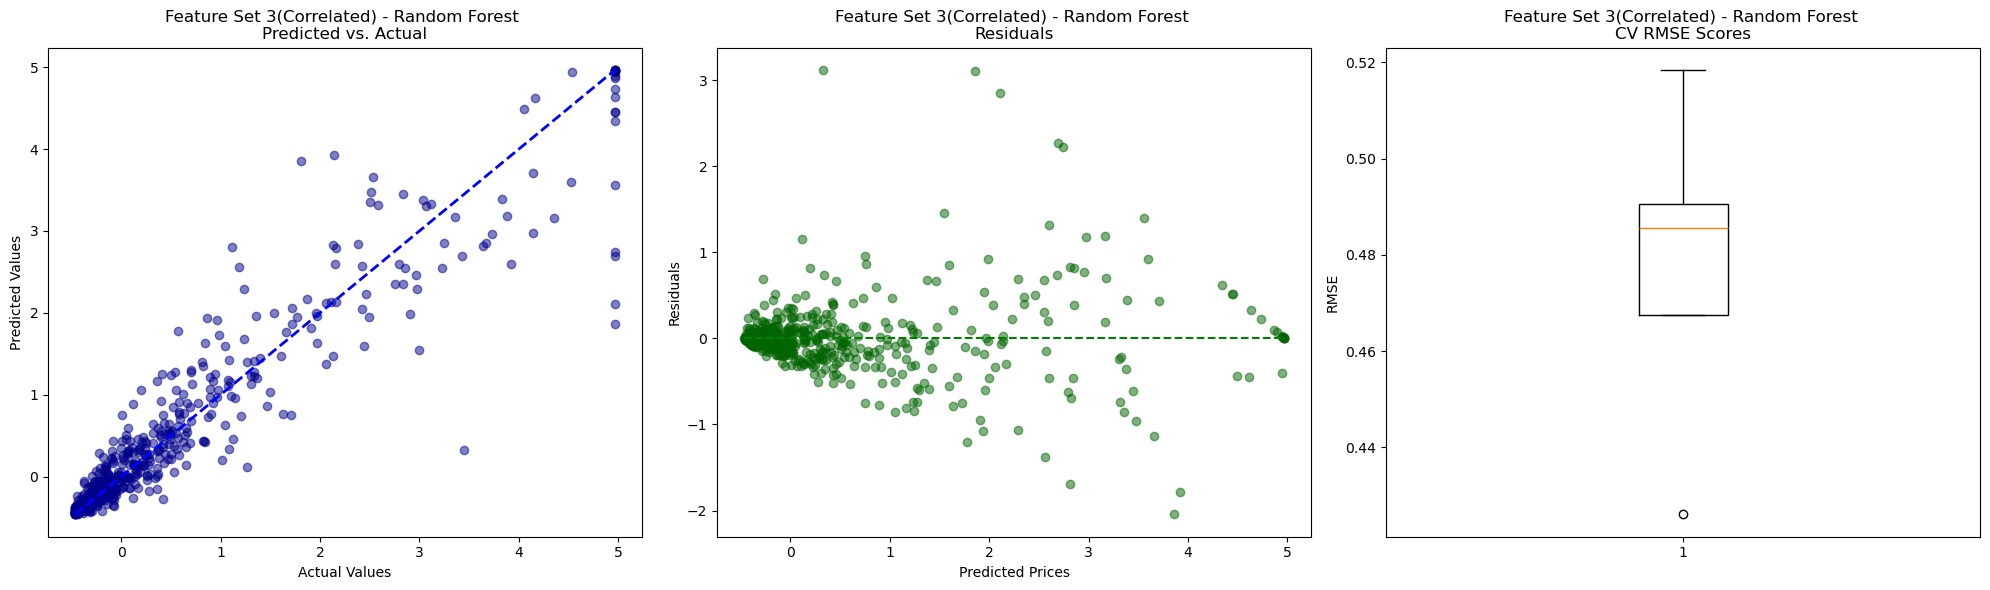

Plot saved to ../Results\Feature Set 3(Correlated)_Gradient Boosting_plots.png


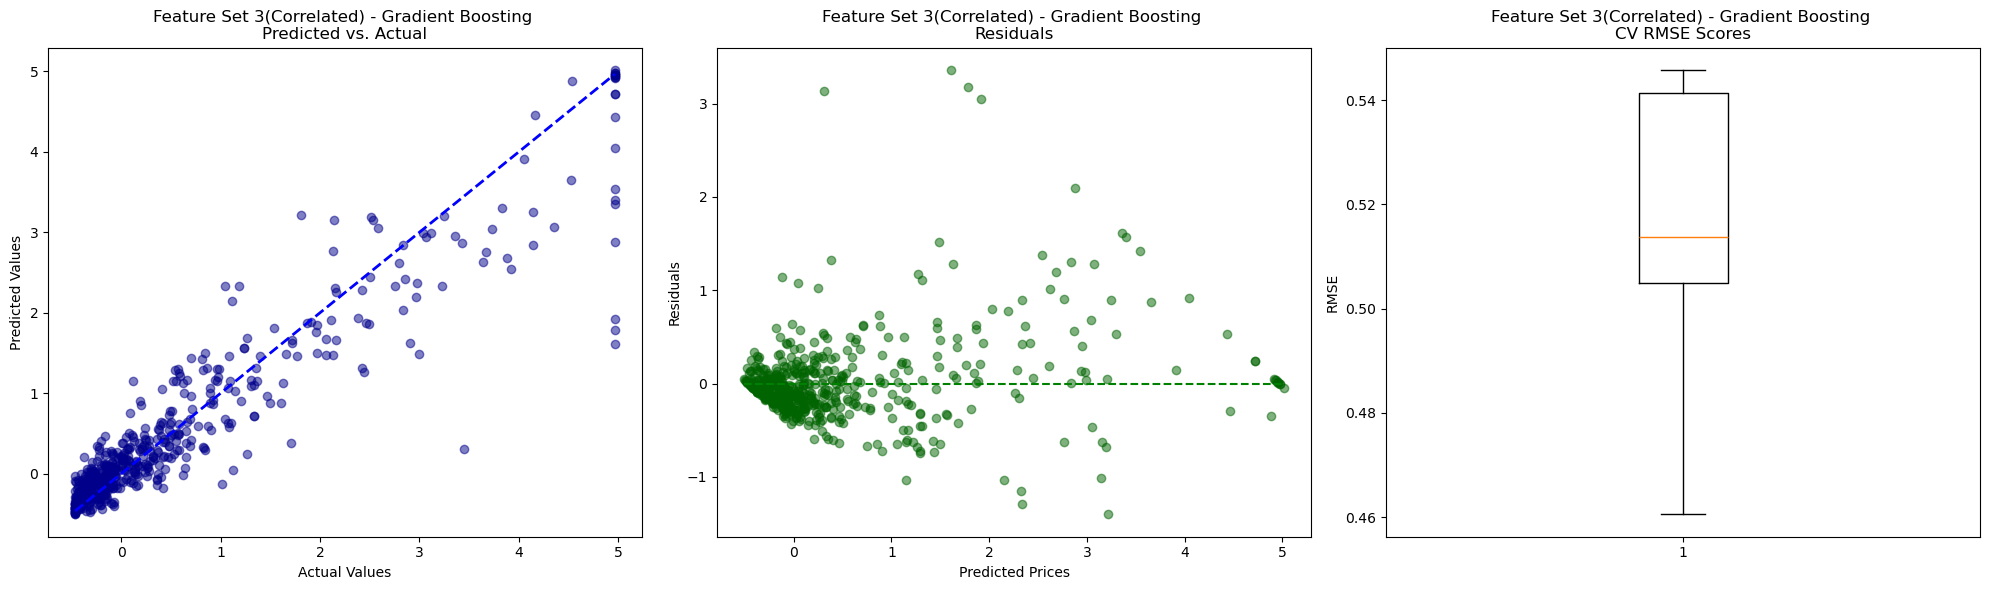

Plot saved to ../Results\Feature Set 3(Correlated)_Ridge Regression_plots.png


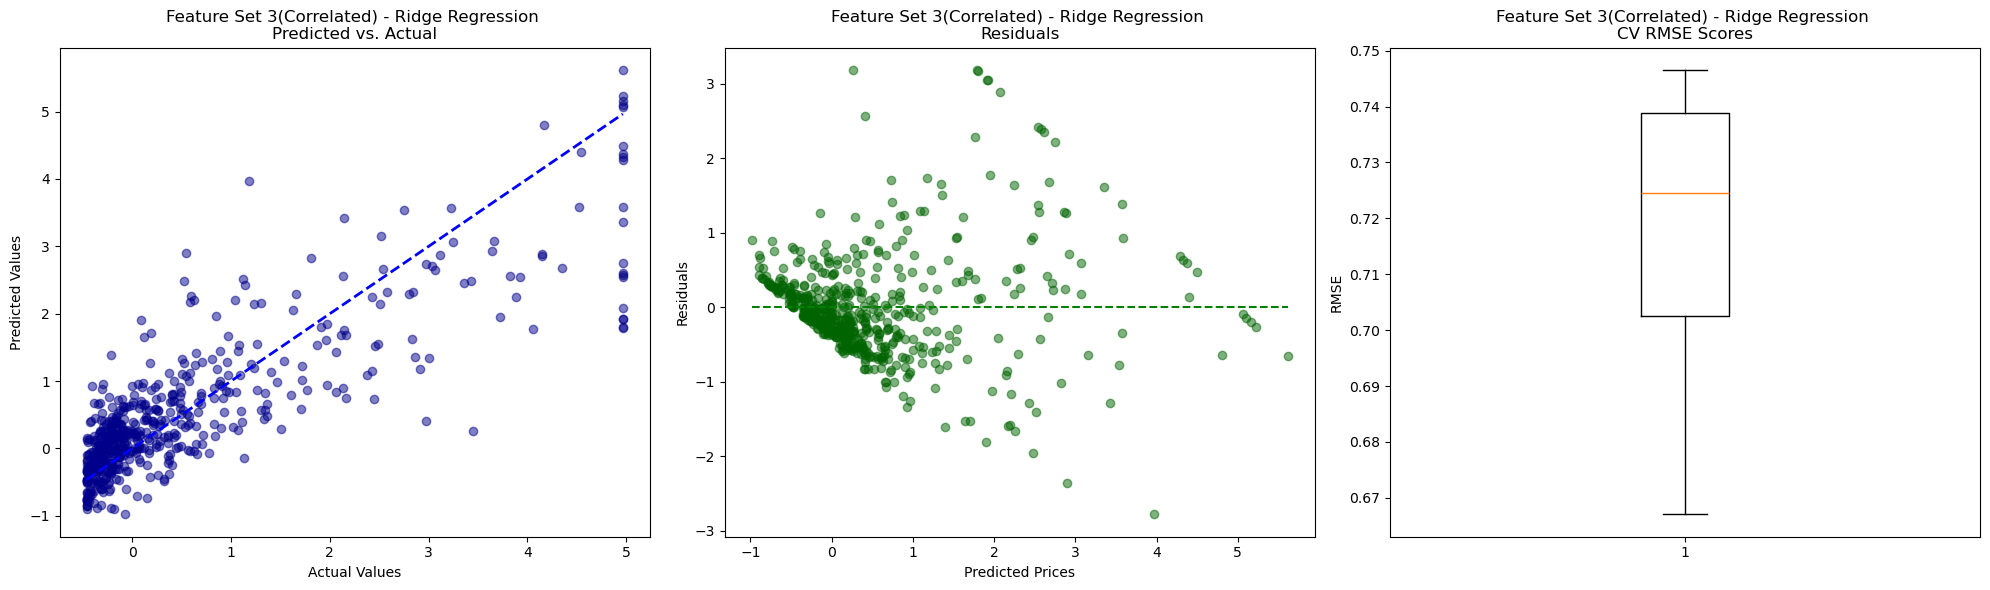

Plot saved to ../Results\Feature Set 3(Correlated)_Linear Regression_plots.png


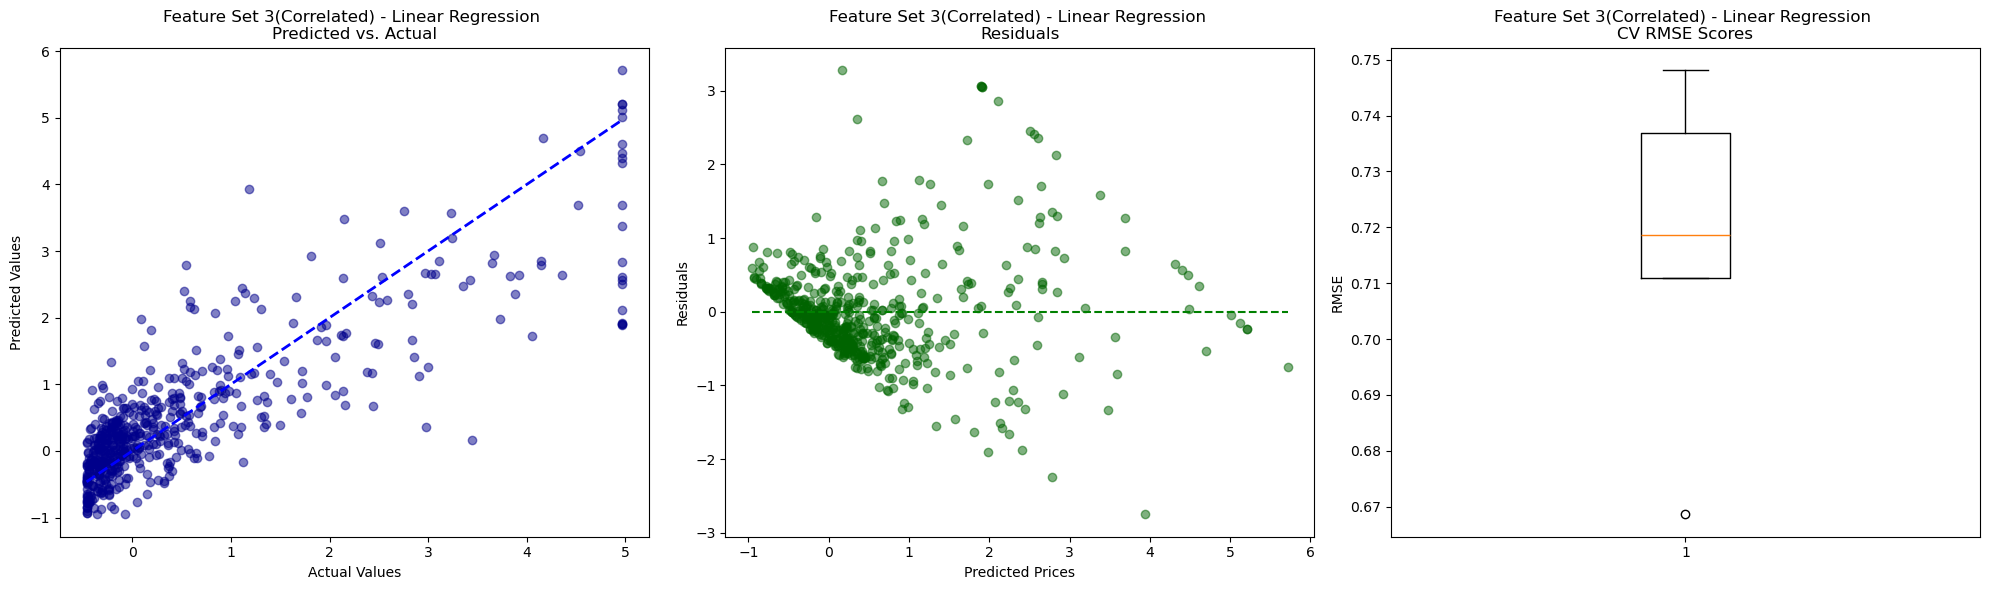

Plot saved to ../Results\Feature Set 4(Boosted IGA)_Random Forest_plots.png


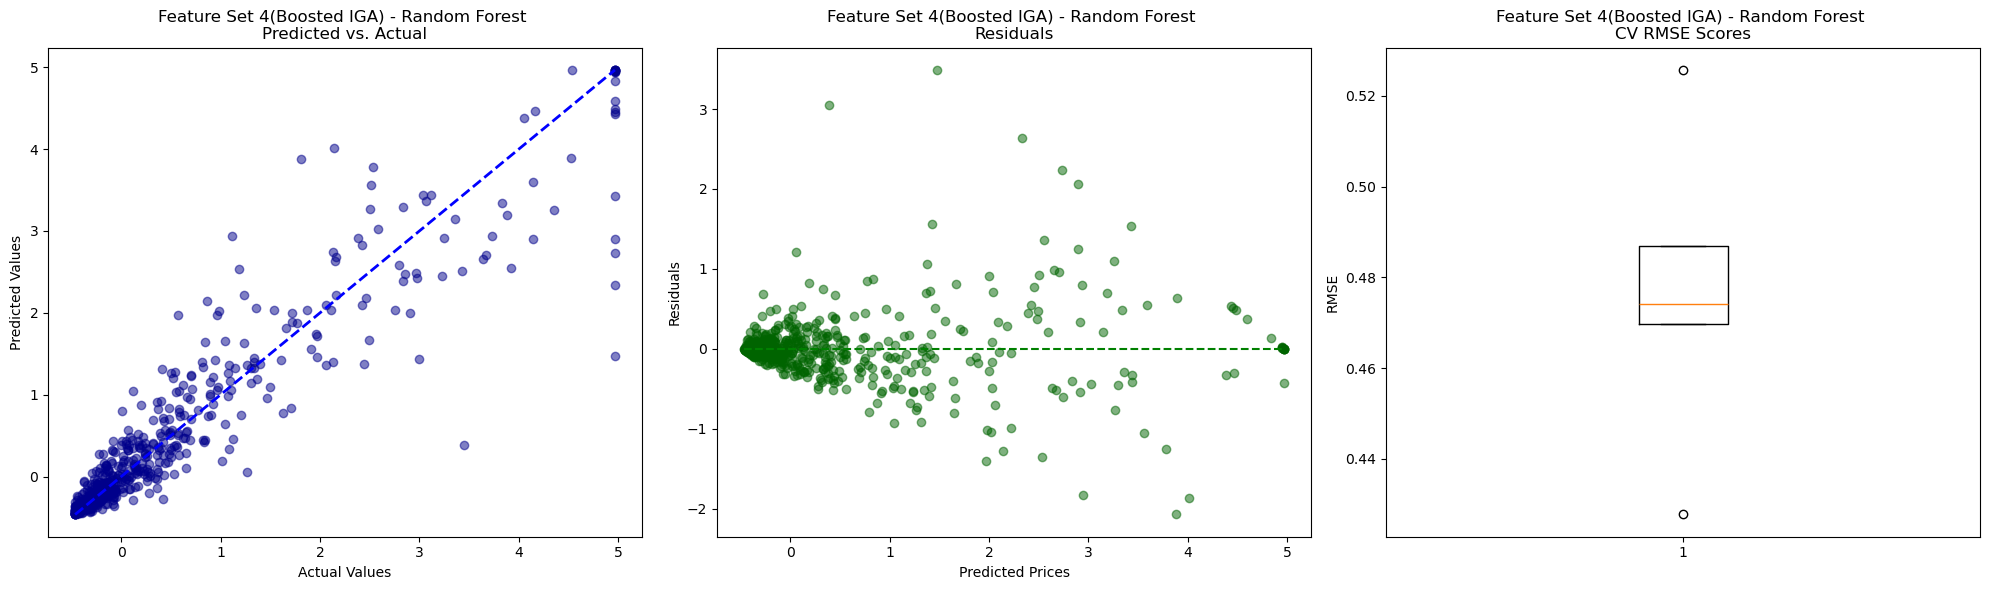

Plot saved to ../Results\Feature Set 4(Boosted IGA)_Gradient Boosting_plots.png


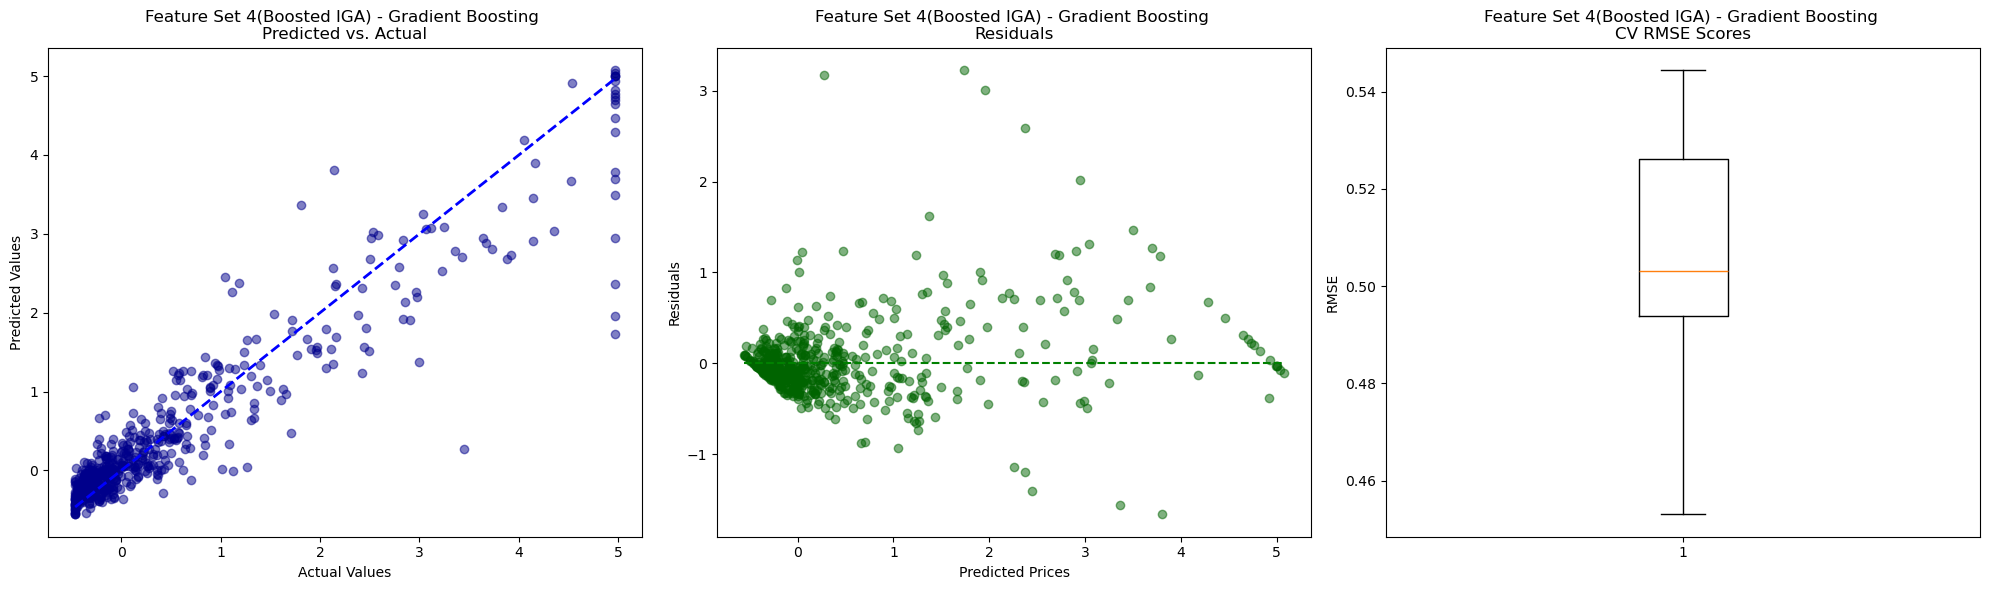

Plot saved to ../Results\Feature Set 4(Boosted IGA)_Ridge Regression_plots.png


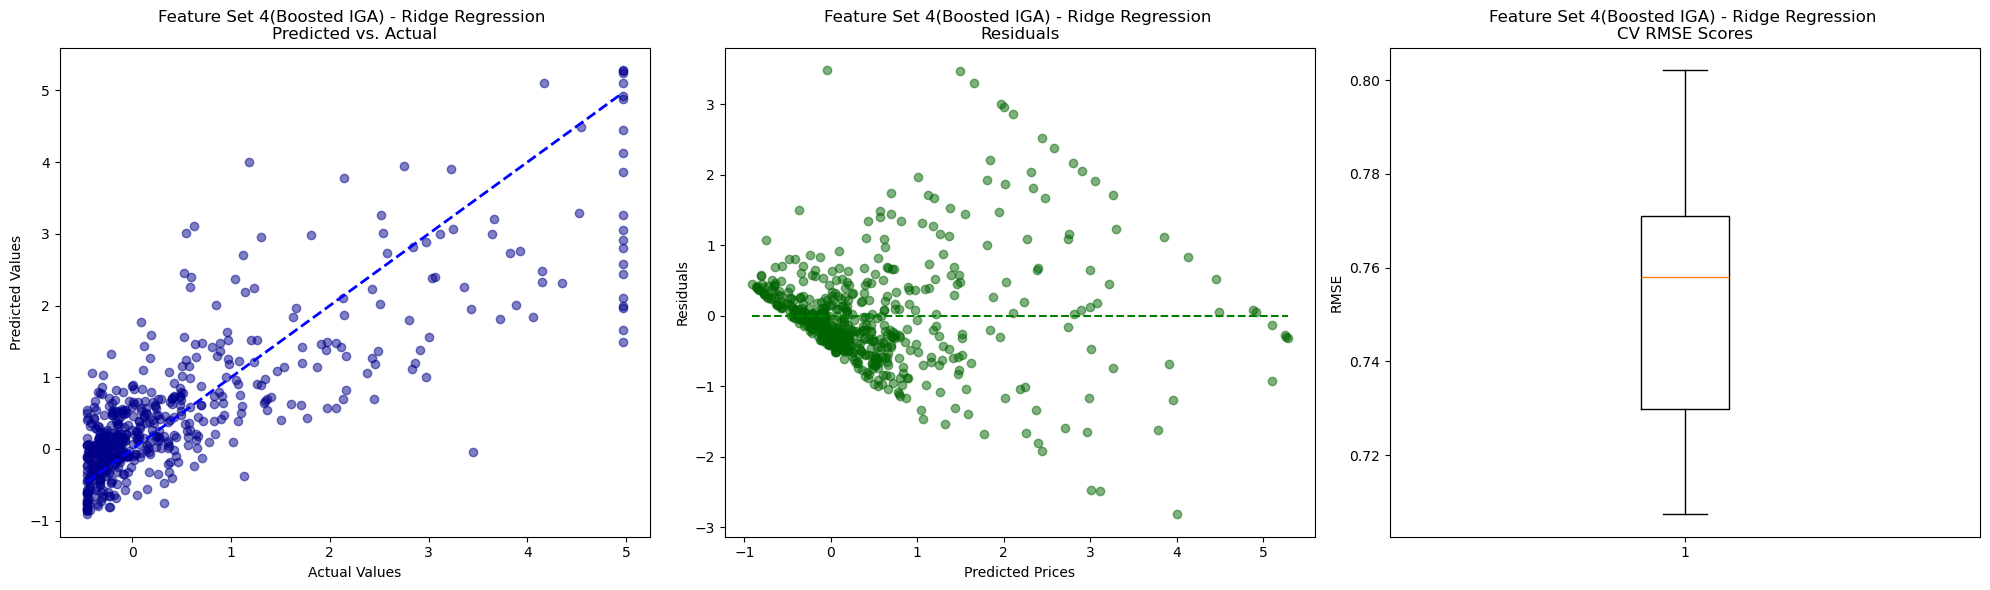

Plot saved to ../Results\Feature Set 4(Boosted IGA)_Linear Regression_plots.png


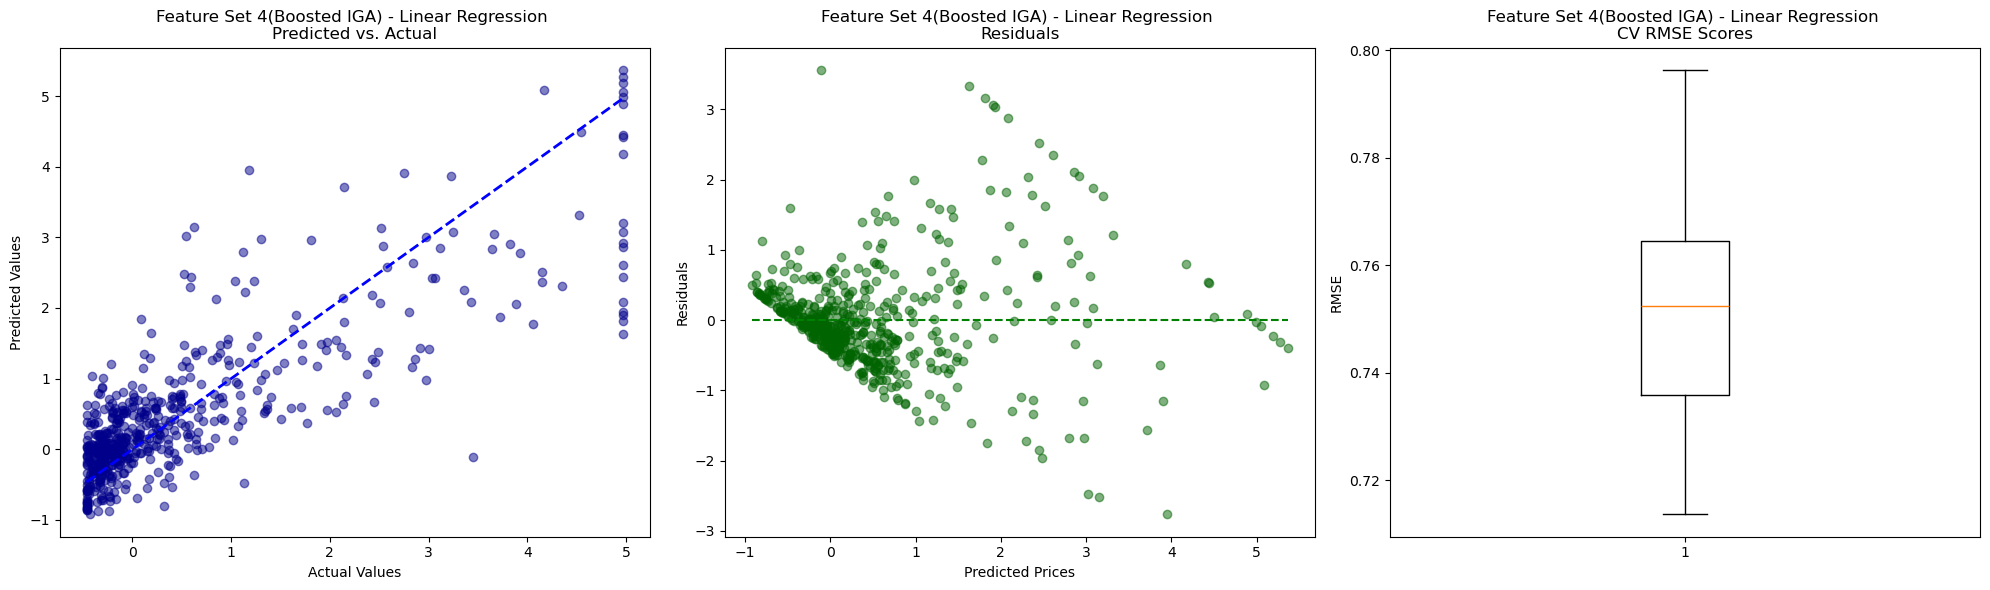

In [23]:

# Plotting and save graphs in a specified directory
def plot_model_comparisons(all_xgb_results,  results_folder='../Results'):
    """
    The visualizations include scatter plots of predicted
    vs. actual values, residual plots, and box plots of cross-validation RMSE scores.
    """ 
   
    for feature_set_name, results in all_results.items():
        for model_name, result in results.items():
            fig, axs = plt.subplots(1, 3, figsize=(20, 6))
            y_test = result['y_test']
            y_pred = result['y_pred']
            font_size = 14
            title_font_size = 16

            # Plotting Predicted vs Actual
            axs[0].scatter(y_test, y_pred, alpha=0.5, color='darkblue')
            axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b--', lw=2)
            axs[0].set_title(f'{feature_set_name} - {model_name} \nPredicted vs. Actual')
            axs[0].set_xlabel('Actual Values')
            axs[0].set_ylabel('Predicted Values')

            # Plotting Residuals
            residuals = y_test - y_pred
            axs[1].scatter(y_pred, residuals, alpha=0.5, color='darkgreen')
            axs[1].hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), linestyles='dashed', color='green')
            axs[1].set_title(f'{feature_set_name} - {model_name} \nResiduals')
            axs[1].set_xlabel('Predicted Prices')
            axs[1].set_ylabel('Residuals')

            # Plotting CV RMSE Scores
            rmse_cv_scores = result['rmse_cv_scores']
            axs[2].boxplot(rmse_cv_scores)
            axs[2].set_title(f'{feature_set_name} - {model_name} \nCV RMSE Scores')
            axs[2].set_ylabel('RMSE')
            
            # Adjusting layout to prevent overlap
            fig.tight_layout()

            # Generating and formatting the filename for saving the plot
            plot_filename = os.path.join(results_folder, f"{feature_set_name}_{model_name}_plots.png")
            fig.savefig(plot_filename, format='png', dpi=300)
            print(f"Plot saved to {plot_filename}")
            plt.show()
            # Close the plot to free memory
            plt.close(fig)

plot_model_comparisons(all_xgb_results)

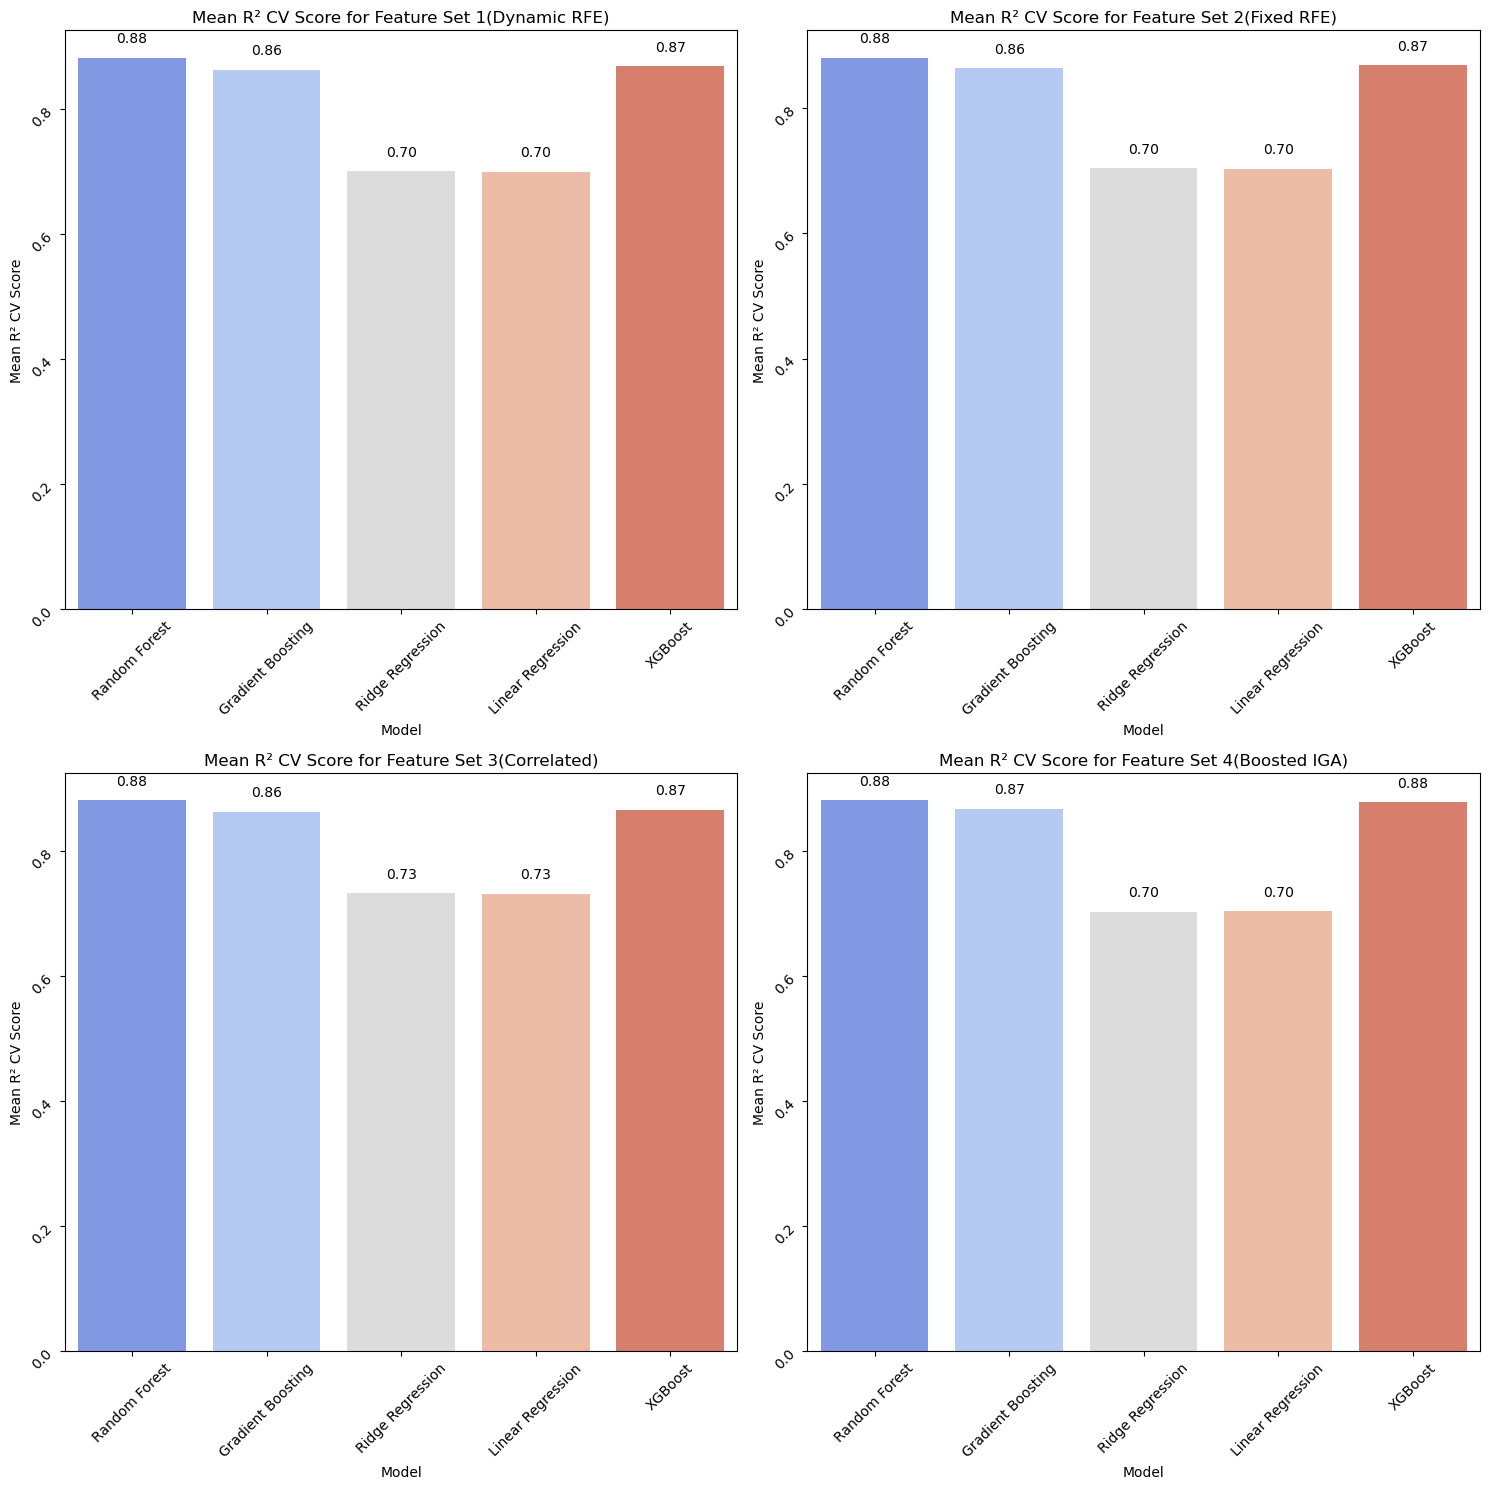

In [24]:

# Defining keys to keep
keys_to_keep = ['mean_mae_cv_score', 'mean_mse_cv_score', 'mean_rmse_cv_score', 
                'mean_r2_cv_score', 'mae', 'mse', 'rmse', 'r2']

def filter_results(results):
    return {key: value for key, value in results.items() if key in keys_to_keep}

def prepare_data_for_excel(results_dict):
    excel_data = []
    for feature_set_name, models in results_dict.items():
        for model_name, results in models.items():
            filtered = filter_results(results)
            filtered['Feature Set'] = feature_set_name
            filtered['Model'] = model_name
            excel_data.append(filtered)
    return pd.DataFrame(excel_data)

# Creating DataFrame for each results dictionary
df_all_results = prepare_data_for_excel(all_results)
df_all_xgb_results = prepare_data_for_excel(all_xgb_results)

# Combining DataFrames
df_comparison_data = pd.concat([df_all_results, df_all_xgb_results], ignore_index=True)

df = df_comparison_data[['Feature Set', 'Model', 'mean_r2_cv_score']]

# Setting up the matplotlib figure and axes
fig, axes = plt.subplots(2, 2, figsize=(15, 15))  
axes = axes.flatten()  

unique_feature_sets = df['Feature Set'].unique()
if len(unique_feature_sets) > len(axes):
    print("Not enough subplots for the number of feature sets")
else:
    # Plotting each feature set in its own subplot
    for i, feature_set in enumerate(sorted(unique_feature_sets)):
        # Filtering data for the specific feature set
        subset = df[df['Feature Set'] == feature_set]
# Creating bar chart
        ax = axes[i]
        sns.barplot(data=subset, x='Model', y='mean_r2_cv_score', ax=ax, palette='coolwarm')

        # Annotating each bar with the mean R² CV score
        for bar in ax.patches:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{height:.2f}',
                    ha='center', va='bottom', fontsize=10)

        # Setting titles and labels
        ax.set_title(f'Mean R² CV Score for {feature_set}')
        ax.set_ylabel('Mean R² CV Score')
        ax.set_xlabel('Model')
        ax.tick_params(labelrotation=45)  # Rotate labels to prevent overlap

    # Adjusting layout to prevent overlap
    plt.tight_layout()

    # Saving the plot as an image file with the title as the filename
    title = "comparison_of_r2_scores for base 5 models"
    plt.savefig(f'../Results/{title}.png', dpi=300, bbox_inches='tight')

    plt.show()

## Dynamic RFE + correlated feature

In [25]:

def RFE_feature_selection_process(X_train, y_train, results_folder='../Results'):
    """
    Performs feature selection using Recursive Feature Elimination (RFE) with a Random Forest model.
    
    Parameters:
    X_train (pd.DataFrame): Training data features.
    y_train (pd.Series): Training data target variable.
    
    Returns:
    selected_features (pd.Index): The final set of features selected by RFE.
    """
    # Initializing and train a Random Forest model
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)

    # Extracting feature importances from the trained model and sort them
    feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

    # Printing initial feature importance
    print("Initial Feature Importances:")
    for feature, importance in feature_importances.items():
        print(f"{feature}: {importance:.4f}")

    # Calculating cumulative importance
    cumulative_importance = np.cumsum(feature_importances)
    threshold = 0.95 # Setting the cumulative importance threshold to 95%
    initial_feature_count = np.where(cumulative_importance >= threshold)[0][0] + 1

    # Identifying the top features based on cumulative importance
    top_features = feature_importances.index[:initial_feature_count]

    print("\nTop Features based on Cumulative Importance Threshold:")
    print(top_features)
    print("\nCumulative Importances:")
    print(cumulative_importance[top_features])

    # Evaluating model performance using different subsets of top features
    feature_counts = [
        initial_feature_count // 4, 
        initial_feature_count // 2, 
        3 * initial_feature_count // 4,
        initial_feature_count
    ]

    best_score = 0
    optimal_features_count = 0
    
    # Looping through the selected subset sizes and evaluating their performance
    for count in feature_counts:
        # Selecting the top 'count' features
        subset_features = top_features[:count]
        X_subset = X_train[subset_features]
        
        # Performing cross-validation with the subset of features
        scores = cross_val_score(rf_model, X_subset, y_train, cv=5, scoring='r2')
        mean_score = np.mean(scores)
        
        print(f"\nEvaluating top {count} features:")
        print(f"Selected Features: {subset_features}")
        print(f"Cross-Validation R2 Score: {mean_score}")
        
        # Updating the best score and optimal feature count if the current subset performs better
        if mean_score > best_score:
            best_score = mean_score
            optimal_features_count = count

    # Output the optimal number of features based on cross-validation performance
    print(f"\nOptimal number of features: {optimal_features_count} with R^2 score: {best_score}")

     # Applying Recursive Feature Elimination (RFE) using the optimal number of features
    X_top_features = X_train[top_features[:optimal_features_count]]
    rfe = RFE(estimator=rf_model, n_features_to_select=optimal_features_count, step=1)
    rfe.fit(X_top_features, y_train)

    # Getting the features selected by RFE and print them
    selected_features = X_top_features.columns[rfe.support_]
    print(f"\nSelected features using RFE: {selected_features}")
    print(f"\nFeature Importances for selected features:\n {pd.Series(rfe.estimator_.feature_importances_, index=selected_features)}")
    # Generating a Series that combines selected features with their importance scores
    feature_importances = pd.Series(rfe.estimator_.feature_importances_, index=selected_features)

    return feature_importances

# Correlated Feature Selection Process
def correlated_features_selection(X_train, y_train, threshold=0.5):
    """
    Select features that are highly correlated with the target variable ('Price') based on a specified threshold.
    
    Parameters:
    X_train (pd.DataFrame): Training data features.
    y_train (pd.Series): Training data target variable.
    threshold (float): The minimum absolute correlation value required for a feature to be selected.
    
    Returns:
    pd.Series: A series of selected feature names that have a correlation with the target variable above the threshold.
    """
    # Combining X_train and y_train into a single DataFrame for correlation computation
    combined_df = X_train.copy()
    combined_df['Price'] = y_train

    # Computing the correlation matrix for the combined DataFrame
    correlation_matrix = combined_df.corr()
    
    # Extracting the correlations of all features with the target variable 'Price'
    correlation_with_target = correlation_matrix['Price'].sort_values(ascending=False)
    
    # Excluding 'Price' itself and filter features with correlation above the specified threshold
    correlated_features = correlation_with_target.drop('Price')
    selected_features = correlated_features[correlated_features.abs() >= threshold]
    
    # Printing the selected features along with their correlation values
    print("\nSelected Features from Correlated Process:")
    for feature, corr in selected_features.items():
        print(f"{feature}: {corr}")
    
    return selected_features


# Selecting features based on correlation with a lower threshold
selected_features_correlated = correlated_features_selection(X_train, y_train, threshold=0.1)

# Performing feature selection using the AdaBoost-based process
selected_features_RFE = RFE_feature_selection_process(X_train, y_train)



Selected Features from Correlated Process:
Level 4 qualifications and above: 0.530738021374415
20-40: 0.521151030121772
One Bedroom Rent: 0.5148268089343055
All categories Rent: 0.49415724555131263
Two Bedrooms Rent: 0.4931809762543267
FlatPrice: 0.49053239454127573
Duration: 0.48806470791873846
Rental price (£): 0.4670330923629423
Three Bedrooms Rent: 0.4638096691507966
SemiDetachedPrice: 0.46213783072885267
TerracedPrice: 0.4592958110483385
Number of those aged 16+ who are unemployed: 0.4583383831487758
Number of those aged 16+ in employment who are employees: 0.4535350979122419
Four or more Bedrooms Rent: 0.43726192180068374
FlatPrice_log: 0.4224490094761568
Number of those aged 16+ in employment who are self-employed: 0.4140495176860368
DetachedPrice: 0.4131371922917252
SemiDetachedPrice_log: 0.39085509942328855
TerracedPrice_log: 0.3812067480504357
Qualification index score: 0.36611064162208323
DetachedPrice_log: 0.3613884428784465
Estimated number of households with at least 1 e

Initial Feature Importances:
One Bedroom Rent: 0.1863
20-40: 0.0797
Area (sq km): 0.0779
All categories Rent: 0.0583
FlatPrice: 0.0516
FlatPrice_log: 0.0489
Local authority code: 0.0439
Three Bedrooms Rent: 0.0435
HGV total: 0.0380
Rental price (£): 0.0334
Deprivation Average Score: 0.0300
Level 4 qualifications and above: 0.0280
Level 3 qualifications: 0.0127
Buses total: 0.0119
0-20: 0.0117
60+: 0.0099
40-60: 0.0099
Number of those aged 16+ who are unemployed: 0.0099
Number of those aged 16+ in employment who are self-employed: 0.0098
Detached_Flat_Ratio: 0.0092
Detached_Terraced_Ratio: 0.0092
Female population: 0.0091
Number of those aged 16+ in employment who are employees: 0.0091
GDHI: 0.0086
NewPrice: 0.0080
1m%Change: 0.0069
Detached_SemiDetached_Ratio: 0.0064
SemiDetachedPrice: 0.0061
Qualification index rank (1 to 331): 0.0061
LPG LGV total: 0.0059
Annual change (%): 0.0051
OldSalesVolume: 0.0046
SalesVolume_log: 0.0042
SemiDetachedPrice_log: 0.0041
MortgageIndex: 0.0038
Month


Evaluating top 12 features:
Selected Features: Index(['One Bedroom Rent', '20-40', 'Area (sq km)', 'All categories Rent',
       'FlatPrice', 'FlatPrice_log', 'Local authority code',
       'Three Bedrooms Rent', 'HGV total', 'Rental price (£)',
       'Deprivation Average Score', 'Level 4 qualifications and above'],
      dtype='object')
Cross-Validation R2 Score: 0.8745433727342297



Evaluating top 25 features:
Selected Features: Index(['One Bedroom Rent', '20-40', 'Area (sq km)', 'All categories Rent',
       'FlatPrice', 'FlatPrice_log', 'Local authority code',
       'Three Bedrooms Rent', 'HGV total', 'Rental price (£)',
       'Deprivation Average Score', 'Level 4 qualifications and above',
       'Level 3 qualifications', 'Buses total', '0-20', '60+', '40-60',
       'Number of those aged 16+ who are unemployed',
       'Number of those aged 16+ in employment who are self-employed',
       'Detached_Flat_Ratio', 'Detached_Terraced_Ratio', 'Female population',
       'Number of those aged 16+ in employment who are employees', 'GDHI',
       'NewPrice'],
      dtype='object')
Cross-Validation R2 Score: 0.8776766031357575



Evaluating top 37 features:
Selected Features: Index(['One Bedroom Rent', '20-40', 'Area (sq km)', 'All categories Rent',
       'FlatPrice', 'FlatPrice_log', 'Local authority code',
       'Three Bedrooms Rent', 'HGV total', 'Rental price (£)',
       'Deprivation Average Score', 'Level 4 qualifications and above',
       'Level 3 qualifications', 'Buses total', '0-20', '60+', '40-60',
       'Number of those aged 16+ who are unemployed',
       'Number of those aged 16+ in employment who are self-employed',
       'Detached_Flat_Ratio', 'Detached_Terraced_Ratio', 'Female population',
       'Number of those aged 16+ in employment who are employees', 'GDHI',
       'NewPrice', '1m%Change', 'Detached_SemiDetached_Ratio',
       'SemiDetachedPrice', 'Qualification index rank (1 to 331)',
       'LPG LGV total', 'Annual change (%)', 'OldSalesVolume',
       'SalesVolume_log', 'SemiDetachedPrice_log', 'MortgageIndex', 'Month',
       'SalesVolume'],
      dtype='object')
Cross-Validation


Evaluating top 50 features:
Selected Features: Index(['One Bedroom Rent', '20-40', 'Area (sq km)', 'All categories Rent',
       'FlatPrice', 'FlatPrice_log', 'Local authority code',
       'Three Bedrooms Rent', 'HGV total', 'Rental price (£)',
       'Deprivation Average Score', 'Level 4 qualifications and above',
       'Level 3 qualifications', 'Buses total', '0-20', '60+', '40-60',
       'Number of those aged 16+ who are unemployed',
       'Number of those aged 16+ in employment who are self-employed',
       'Detached_Flat_Ratio', 'Detached_Terraced_Ratio', 'Female population',
       'Number of those aged 16+ in employment who are employees', 'GDHI',
       'NewPrice', '1m%Change', 'Detached_SemiDetached_Ratio',
       'SemiDetachedPrice', 'Qualification index rank (1 to 331)',
       'LPG LGV total', 'Annual change (%)', 'OldSalesVolume',
       'SalesVolume_log', 'SemiDetachedPrice_log', 'MortgageIndex', 'Month',
       'SalesVolume', 'Diesel LGV total', 'Two Bedrooms Rent'


Selected features using RFE: Index(['One Bedroom Rent', '20-40', 'Area (sq km)', 'All categories Rent',
       'FlatPrice', 'FlatPrice_log', 'Local authority code',
       'Three Bedrooms Rent', 'HGV total', 'Rental price (£)',
       'Deprivation Average Score', 'Level 4 qualifications and above',
       'Level 3 qualifications', 'Buses total', '0-20', '60+', '40-60',
       'Number of those aged 16+ who are unemployed',
       'Number of those aged 16+ in employment who are self-employed',
       'Detached_Flat_Ratio', 'Detached_Terraced_Ratio', 'Female population',
       'Number of those aged 16+ in employment who are employees', 'GDHI',
       'NewPrice', '1m%Change', 'Detached_SemiDetached_Ratio',
       'SemiDetachedPrice', 'Qualification index rank (1 to 331)',
       'LPG LGV total', 'Annual change (%)', 'OldSalesVolume',
       'SalesVolume_log', 'SemiDetachedPrice_log', 'MortgageIndex', 'Month',
       'SalesVolume'],
      dtype='object')

Feature Importances for selected 

In [26]:
selected_features_RFE

One Bedroom Rent                                                0.190350
20-40                                                           0.080631
Area (sq km)                                                    0.083335
All categories Rent                                             0.059442
FlatPrice                                                       0.047351
FlatPrice_log                                                   0.059638
Local authority code                                            0.045911
Three Bedrooms Rent                                             0.044627
HGV total                                                       0.041766
Rental price (£)                                                0.035955
Deprivation Average Score                                       0.033790
Level 4 qualifications and above                                0.028170
Level 3 qualifications                                          0.013664
Buses total                                        

In [27]:
def combine_and_deduplicate_features_1(correlated_features, RFE_features):
    """
    Combines correlated and boosted features, deduplicate them,
    and retain the higher importance score in case of common features.
    
    Parameters:
    correlated_features (pd.Series): Correlated features with their importance scores (correlation values).
    boosted_features (pd.Series): Boosted features with their importance scores (from model).

    Returns:
    combined_features (pd.Series): Combined features with their highest importance scores.
    """
    # Combining correlated and boosted features into a single DataFrame using an outer join on indices
    combined_features = pd.concat([correlated_features, RFE_features], axis=1, join='outer')
    
    # Renaming the columns to reflect the source of importance scores for clarity
    combined_features.columns = ['Importance_Corr', 'Importance_RFE']
    
    # Handling missing values: replace missing correlated scores with -inf and missing boosted scores with 0
    combined_features['Importance_Corr'].fillna(-np.inf, inplace=True)
    combined_features['Importance_RFE'].fillna(0, inplace=True)
    
    # For features present in both sets, retaining the higher of the two importance scores
    combined_features['Final_Importance'] = combined_features[['Importance_Corr', 'Importance_RFE']].apply(
        lambda x: max(x['Importance_Corr'], x['Importance_RFE']), axis=1
    )
    
    # Replacing any -inf values in the final importance with 0 to ensure all scores are non-negative
    combined_features['Final_Importance'] = combined_features['Final_Importance'].replace(-np.inf, 0)
    
    # Sorting the combined features by their final importance scores in descending order
    combined_features = combined_features['Final_Importance'].sort_values(ascending=False)
    
    # Printing the final selected features along with their importance scores
    print("\nCombined Selected Features with their Importance Scores:")
    for feature, importance in combined_features.items():
        print(f"{feature}: {importance:.4f}")
    
    return combined_features

# Combining correlated and boosted features into a final feature set with deduplication
combined_features_1_3 = combine_and_deduplicate_features_1(selected_features_correlated, selected_features_RFE)



Combined Selected Features with their Importance Scores:
Level 4 qualifications and above: 0.5307
20-40: 0.5212
One Bedroom Rent: 0.5148
All categories Rent: 0.4942
Two Bedrooms Rent: 0.4932
FlatPrice: 0.4905
Duration: 0.4881
Rental price (£): 0.4670
Three Bedrooms Rent: 0.4638
SemiDetachedPrice: 0.4621
TerracedPrice: 0.4593
Number of those aged 16+ who are unemployed: 0.4583
Number of those aged 16+ in employment who are employees: 0.4535
Four or more Bedrooms Rent: 0.4373
FlatPrice_log: 0.4224
Number of those aged 16+ in employment who are self-employed: 0.4140
DetachedPrice: 0.4131
SemiDetachedPrice_log: 0.3909
TerracedPrice_log: 0.3812
Qualification index score: 0.3661
DetachedPrice_log: 0.3614
Estimated number of households with at least 1 early-years or school age child: 0.3590
FTBPrice: 0.3568
Female population: 0.3510
Local authority code: 0.3502
All ages: 0.3465
Male population: 0.3416
FlatPrice_PctChange: 0.3408
SemiDetachedPrice_PctChange: 0.3404
0-20: 0.3389
Other qualific

In [28]:
# Converting the final_combined_features Series to a DataFrame
combined_features_df_1_3 = combined_features_1_3.reset_index()

# Renaming the columns to 'Feature' and 'Importance' for clarity
combined_features_df_1_3.columns = ['Feature', 'Importance']

# Filtering out features with an Importance score of 0 to retain only significant features
combined_features_df_1_3 = combined_features_df_1_3[combined_features_df_1_3['Importance'] > 0]

# Displaying the resulting DataFrame of significant features with their importance scores
combined_features_df_1_3
info_logger.info("Obtained Combined Feature set with Feature selection method 1 and 3")

### Model testing with combined feature set 1

In [29]:
# Extracting the final selected features as a list for use in model training
combined_features_1_3 = combined_features_df_1_3['Feature'].tolist()

# Subsetting the training data using only the final selected features
X_train_combined_1_3 = X_train[combined_features_1_3]
# Subsetting the testing data using only the final selected features
X_test_combined_1_3 = X_test[combined_features_1_3]

# Function to evaluate the model's performance on the test set
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Fit the model on the training data, predict on the test data, and calculate evaluation metrics.
    
    Parameters:
    model (sklearn estimator): The machine learning model to be evaluated.
    X_train (pd.DataFrame): Training data features.
    y_train (pd.Series): Training data target variable.
    X_test (pd.DataFrame): Testing data features.
    y_test (pd.Series): Testing data target variable.
    
    Returns:
    tuple: Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R² score.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'y_test': y_test, 'y_pred': y_pred}

# Function to compare the performance of Random Forest model using cross-validation and test set evaluation on Combined feature set
def compare_models(X_train, y_train, X_test, y_test):
    """
    Compare the Random Forest model's performance using cross-validation and evaluate it on the test set.
    
    Parameters:
    X_train (pd.DataFrame): Training data features.
    y_train (pd.Series): Training data target variable.
    X_test (pd.DataFrame): Testing data features.
    y_test (pd.Series): Testing data target variable.
    
    Returns:
    dict: A dictionary containing performance metrics for the Random Forest model.
    """
    models = {
        'Random Forest': RandomForestRegressor(random_state=42)
    }
    results = {}
    for model_name, model in models.items():
        # Performing cross-validation to assess model performance
        mae_cv_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
        mse_cv_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        rmse_cv_scores = np.sqrt(-cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
        r2_cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        
        # Evaluating the model on the test set
        eval_results = evaluate_model(model, X_train, y_train, X_test, y_test)
        results[model_name] = {
            'mean_mae_cv_score': mae_cv_scores.mean(),
            'mean_mse_cv_score': mse_cv_scores.mean(),
            'mean_rmse_cv_score': rmse_cv_scores.mean(),
            'mean_r2_cv_score': r2_cv_scores.mean(),
            'mae_cv_scores': mae_cv_scores,
            'mse_cv_scores': mse_cv_scores,
            'rmse_cv_scores': rmse_cv_scores,
            'r2_cv_scores': r2_cv_scores,
            'mae': eval_results['mae'],
            'mse': eval_results['mse'],
            'rmse': eval_results['rmse'],
            'r2': eval_results['r2'],
            'y_test': eval_results['y_test'],
            'y_pred': eval_results['y_pred']
        }
    
    return results

# Function to evaluate multiple feature sets using the defined models
def test_feature_sets(feature_sets, y_train, y_test):
    """
    Tests different feature sets by comparing model performance on each set.
    
    Parameters:
    feature_sets (dict): A dictionary where keys are feature set names and values are (X_train, X_test) tuples.
    y_train (pd.Series): Training data target variable.
    y_test (pd.Series): Testing data target variable.
    
    Returns:
    dict: A dictionary containing the performance results for each feature set and model.
    """
    results = {}
    for feature_set_name, feature_data in feature_sets.items():
        X_train, X_test = feature_data
        print(f"Testing feature set: {feature_set_name}")
        results[feature_set_name] = compare_models(X_train, y_train, X_test, y_test)
    return results

# Defining the final feature set for model evaluation
feature_sets = {
    'Combined Features_1_3': (X_train_combined_1_3, X_test_combined_1_3)
}

# Evaluating models on each feature set and collect results
final_results = test_feature_sets(feature_sets, y_train, y_test)

# Printing the performance results for each model on the final feature set
for feature_set_name, results in final_results.items():
    print(f"Results for {feature_set_name}:")
    for model_name, result in results.items():
        print(f"{model_name} - Cross-Validation Scores:")
        print(f"  Mean MAE CV Score: {result['mean_mae_cv_score']}, CV Scores: {result['mae_cv_scores']}")
        print(f"  Mean MSE CV Score: {result['mean_mse_cv_score']}, CV Scores: {result['mse_cv_scores']}")
        print(f"  Mean RMSE CV Score: {result['mean_rmse_cv_score']}, CV Scores: {result['rmse_cv_scores']}")
        print(f"  Mean R² CV Score: {result['mean_r2_cv_score']}, CV Scores: {result['r2_cv_scores']}")
        print(f"Test Performance:")
        print(f"  MAE: {result['mae']}, MSE: {result['mse']}, RMSE: {result['rmse']}, R²: {result['r2']}\n")


Testing feature set: Combined Features_1_3


Results for Combined Features_1_3:
Random Forest - Cross-Validation Scores:
  Mean MAE CV Score: 0.23917569165701386, CV Scores: [0.22780588 0.24500631 0.24481595 0.23553881 0.2427115 ]
  Mean MSE CV Score: 0.2277233970034, CV Scores: [0.23148488 0.22225419 0.26354369 0.18314358 0.23819064]
  Mean RMSE CV Score: 0.47638656291268455, CV Scores: [0.48112876 0.47143843 0.51336507 0.42795277 0.48804779]
  Mean R² CV Score: 0.8812909871899441, CV Scores: [0.87737973 0.89905681 0.86848155 0.88708075 0.8744561 ]
Test Performance:
  MAE: 0.22923852557314547, MSE: 0.1922005252144247, RMSE: 0.43840680333957494, R²: 0.8884368647577539



In [30]:
r2_combined_model1 = None  # Initializing the variable to store the R² score

for feature_set_name, results in final_results.items():
    for model_name, result in results.items():
        r2_combined_model1 = result['r2']

print("R² score for Combined Model 1:", r2_combined_model1)


R² score for Combined Model 1: 0.8884368647577539


## correlated + boosted feature

In [31]:

# Boosted Feature Selection Process
def ada_feature_selection_process(X_train, y_train, X_test, y_test):
    """
    Perform feature selection using AdaBoost, Improved Garson Algorithm (IGA), and Gradient Boosting 
    with permutation importance for interaction gain.
    
    Parameters:
    X_train (pd.DataFrame): Training data features.
    y_train (pd.Series): Training data target variable.
    X_test (pd.DataFrame): Testing data features.
    y_test (pd.Series): Testing data target variable.
    
    Returns:
    pd.Series: The final set of selected features based on interaction gain.
    """
    # Training an AdaBoost model on the training data
    ada_model = AdaBoostRegressor(random_state=42)
    ada_model.fit(X_train, y_train)

    # Extracting feature importances from the AdaBoost model and sort them
    ada_importances = pd.Series(ada_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

    # Filtering and retaining only features with non-zero importance
    important_features = ada_importances[ada_importances > 0]
    X_train_important = X_train[important_features.index]
    X_test_important = X_test[important_features.index]

    # Re-training AdaBoost using only the important features for sensitivity analysis
    ada_model_selected = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100, random_state=42)
    ada_model_selected.fit(X_train_important, y_train)

    # Applying Improved Garson Algorithm (IGA) to refine feature importances
    iga_importances = pd.Series(ada_model_selected.feature_importances_, index=important_features.index).sort_values(ascending=False)

    # Selecting features based on IGA importances (those with non-zero importance)
    selected_features_iga = iga_importances[iga_importances > 0]
    X_train_iga = X_train_important[selected_features_iga.index]
    X_test_iga = X_test_important[selected_features_iga.index]

    # Training a Gradient Boosting model using the IGA-selected features
    gb_model = GradientBoostingRegressor(random_state=42)
    gb_model.fit(X_train_iga, y_train)

    # Calculating permutation importance to assess the interaction gain of the selected features
    perm_importance = permutation_importance(gb_model, X_test_iga, y_test, n_repeats=10, random_state=42)
    interaction_gain = pd.Series(perm_importance.importances_mean, index=selected_features_iga.index).sort_values(ascending=False)

    # Final feature selection based on interaction gain (keeping those with non-zero gain)
    final_selected_features = interaction_gain[interaction_gain > 0]
    
    # Printing the final selected features and their interaction gain scores
    print("\nFinal Selected Features from Boosted Process based on Interaction Gain:")
    for feature, importance in final_selected_features.items():
        print(f"{feature}: {importance:.4f}")

    return final_selected_features

# Correlated Feature Selection Process
def correlated_features_selection(X_train, y_train, threshold=0.5):
    """
    Selects features that are highly correlated with the target variable ('Price') based on a specified threshold.
    
    Parameters:
    X_train (pd.DataFrame): Training data features.
    y_train (pd.Series): Training data target variable.
    threshold (float): The minimum absolute correlation value required for a feature to be selected.
    
    Returns:
    pd.Series: A series of selected feature names that have a correlation with the target variable above the threshold.
    """
    # Combining X_train and y_train into a single DataFrame for correlation computation
    combined_df = X_train.copy()
    combined_df['Price'] = y_train

    # Computing the correlation matrix for the combined DataFrame
    correlation_matrix = combined_df.corr()
    
    # Extracting the correlations of all features with the target variable 'Price'
    correlation_with_target = correlation_matrix['Price'].sort_values(ascending=False)
    
    # Excluding 'Price' itself and filter features with correlation above the specified threshold
    correlated_features = correlation_with_target.drop('Price')
    selected_features = correlated_features[correlated_features.abs() >= threshold]
    
    # Printing the selected features along with their correlation values
    print("\nSelected Features from Correlated Process:")
    for feature, corr in selected_features.items():
        print(f"{feature}: {corr}")
    
    return selected_features

# Selecting features based on correlation with a lower threshold
selected_features_correlated = correlated_features_selection(X_train, y_train, threshold=0.1)

# Performing feature selection using the AdaBoost-based process
selected_features_boosted = ada_feature_selection_process(X_train, y_train, X_test, y_test)



Selected Features from Correlated Process:
Level 4 qualifications and above: 0.530738021374415
20-40: 0.521151030121772
One Bedroom Rent: 0.5148268089343055
All categories Rent: 0.49415724555131263
Two Bedrooms Rent: 0.4931809762543267
FlatPrice: 0.49053239454127573
Duration: 0.48806470791873846
Rental price (£): 0.4670330923629423
Three Bedrooms Rent: 0.4638096691507966
SemiDetachedPrice: 0.46213783072885267
TerracedPrice: 0.4592958110483385
Number of those aged 16+ who are unemployed: 0.4583383831487758
Number of those aged 16+ in employment who are employees: 0.4535350979122419
Four or more Bedrooms Rent: 0.43726192180068374
FlatPrice_log: 0.4224490094761568
Number of those aged 16+ in employment who are self-employed: 0.4140495176860368
DetachedPrice: 0.4131371922917252
SemiDetachedPrice_log: 0.39085509942328855
TerracedPrice_log: 0.3812067480504357
Qualification index score: 0.36611064162208323
DetachedPrice_log: 0.3613884428784465
Estimated number of households with at least 1 e


Final Selected Features from Boosted Process based on Interaction Gain:
Area (sq km): 0.2011
20-40: 0.1108
All categories Rent: 0.1007
One Bedroom Rent: 0.0906
GDHI: 0.0558
Local authority code: 0.0317
Level 4 qualifications and above: 0.0295
Level 3 qualifications: 0.0249
Buses total: 0.0209
Qualification index score: 0.0183
Number of those aged 16+ who are unemployed: 0.0163
Qualification index rank (1 to 331): 0.0157
Petrol cars total: 0.0155
HGV total: 0.0154
OldPrice: 0.0146
FlatPrice: 0.0143
Petrol LGV total: 0.0115
Number of those aged 16+ in employment who are self-employed: 0.0083
Number of those aged 16+ in employment who are employees: 0.0078
AveragePrice_PctChange: 0.0066
60+: 0.0055
Deprivation Average Score: 0.0051
LPG LGV total: 0.0050
Month: 0.0045
40-60: 0.0031
Property Type: 0.0031
Annual change (%): 0.0030
0-20: 0.0026
Four or more Bedrooms Rent: 0.0025
Apprenticeship: 0.0024
Rental price (£): 0.0024
TerracedPrice_PctChange: 0.0022
Detached_SemiDetached_Ratio: 0.002

In [32]:
def combine_and_deduplicate_features(correlated_features, boosted_features):
    """
    Combines correlated and boosted features, deduplicate them,
    and retain the higher importance score in case of common features.
    
    Parameters:
    correlated_features (pd.Series): Correlated features with their importance scores (correlation values).
    boosted_features (pd.Series): Boosted features with their importance scores (from model).

    Returns:
    combined_features (pd.Series): Combined features with their highest importance scores.
    """
    # Combining correlated and boosted features into a single DataFrame using an outer join on indices
    combined_features = pd.concat([correlated_features, boosted_features], axis=1, join='outer')
    
    # Renaming the columns to reflect the source of importance scores for clarity
    combined_features.columns = ['Importance_Corr', 'Importance_Boosted']
    
    # Handling missing values: replace missing correlated scores with -inf and missing boosted scores with 0
    combined_features['Importance_Corr'].fillna(-np.inf, inplace=True)
    combined_features['Importance_Boosted'].fillna(0, inplace=True)
    
    # For features present in both sets, retaining the higher of the two importance scores
    combined_features['Final_Importance'] = combined_features[['Importance_Corr', 'Importance_Boosted']].apply(
        lambda x: max(x['Importance_Corr'], x['Importance_Boosted']), axis=1
    )
    
    # Replacing any -inf values in the final importance with 0 to ensure all scores are non-negative
    combined_features['Final_Importance'] = combined_features['Final_Importance'].replace(-np.inf, 0)
    
    # Sorting the combined features by their final importance scores in descending order
    combined_features = combined_features['Final_Importance'].sort_values(ascending=False)
    
    # Printing the final selected features along with their importance scores
    print("\nFinal Combined Selected Features with their Importance Scores:")
    for feature, importance in combined_features.items():
        print(f"{feature}: {importance:.4f}")
    
    return combined_features

# Combining correlated and boosted features into a final feature set with deduplication
final_combined_features = combine_and_deduplicate_features(selected_features_correlated, selected_features_boosted)



Final Combined Selected Features with their Importance Scores:
Level 4 qualifications and above: 0.5307
20-40: 0.5212
One Bedroom Rent: 0.5148
All categories Rent: 0.4942
Two Bedrooms Rent: 0.4932
FlatPrice: 0.4905
Duration: 0.4881
Rental price (£): 0.4670
Three Bedrooms Rent: 0.4638
SemiDetachedPrice: 0.4621
TerracedPrice: 0.4593
Number of those aged 16+ who are unemployed: 0.4583
Number of those aged 16+ in employment who are employees: 0.4535
Four or more Bedrooms Rent: 0.4373
FlatPrice_log: 0.4224
Number of those aged 16+ in employment who are self-employed: 0.4140
DetachedPrice: 0.4131
SemiDetachedPrice_log: 0.3909
TerracedPrice_log: 0.3812
Qualification index score: 0.3661
DetachedPrice_log: 0.3614
Estimated number of households with at least 1 early-years or school age child: 0.3590
FTBPrice: 0.3568
Female population: 0.3510
Local authority code: 0.3502
All ages: 0.3465
Male population: 0.3416
FlatPrice_PctChange: 0.3408
SemiDetachedPrice_PctChange: 0.3404
0-20: 0.3389
Other qu

In [33]:
# Converting the final_combined_features Series to a DataFrame
final_combined_features_df = final_combined_features.reset_index()

# Renaming the columns to 'Feature' and 'Importance' for clarity
final_combined_features_df.columns = ['Feature', 'Importance']

# Filtering out features with an Importance score of 0 to retain only significant features
final_combined_features_df = final_combined_features_df[final_combined_features_df['Importance'] > 0]

# Saving the final_combined_features_df DataFrame to an Excel file
final_combined_features_df.to_excel("../Data/Output/final_combined_features.xlsx", index=False)
final_combined_features_df.to_csv("../Results/final_combined_features.csv", index=False)

print("Data saved to 'final_combined_features.xlsx'")

final_combined_features_df

info_logger.info("Obtained Combined Feature set with Feature selection method 3 and 4")

Data saved to 'final_combined_features.xlsx'


## saved final job 
### Model testing with combined feature set 2

In [34]:
# Extracting the final selected features as a list for use in model training
final_features = final_combined_features_df['Feature'].tolist()

# Subsetting the training data using only the final selected features
X_train_final = X_train[final_features]

# Subsetting the testing data using only the final selected features
X_test_final = X_test[final_features]


In [35]:

# Function to evaluate the model's performance on the test set
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Fit the model on the training data, predict on the test data, and calculate evaluation metrics.
    
    Parameters:
    model (sklearn estimator): The machine learning model to be evaluated.
    X_train (pd.DataFrame): Training data features.
    y_train (pd.Series): Training data target variable.
    X_test (pd.DataFrame): Testing data features.
    y_test (pd.Series): Testing data target variable.
    
    Returns:
    tuple: Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R² score.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred) 
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'y_test': y_test, 'y_pred': y_pred}

# Function to compare the performance of Random Forest model using cross-validation and test set evaluation on Combined feature set
def compare_models(X_train, y_train, X_test, y_test):
    """
    Compare the Random Forest model's performance using cross-validation and evaluate it on the test set.
    
    Parameters:
    X_train (pd.DataFrame): Training data features.
    y_train (pd.Series): Training data target variable.
    X_test (pd.DataFrame): Testing data features.
    y_test (pd.Series): Testing data target variable.
    
    Returns:
    dict: A dictionary containing performance metrics for the Random Forest model.
    """
    models = {
        'Random Forest': RandomForestRegressor(random_state=42)
    }
    results = {}
    for model_name, model in models.items():
        # Performing cross-validation to assess model performance
        mae_cv_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
        mse_cv_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        rmse_cv_scores = np.sqrt(-cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
        r2_cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        
        # Evaluating the model on the test set
        eval_results = evaluate_model(model, X_train, y_train, X_test, y_test)
        results[model_name] = {
            'mean_mae_cv_score': mae_cv_scores.mean(),
            'mean_mse_cv_score': mse_cv_scores.mean(),
            'mean_rmse_cv_score': rmse_cv_scores.mean(),
            'mean_r2_cv_score': r2_cv_scores.mean(),
            'mae_cv_scores': mae_cv_scores,
            'mse_cv_scores': mse_cv_scores,
            'rmse_cv_scores': rmse_cv_scores,
            'r2_cv_scores': r2_cv_scores,
            'mae': eval_results['mae'],
            'mse': eval_results['mse'],
            'rmse': eval_results['rmse'],
            'r2': eval_results['r2'],
            'y_test': eval_results['y_test'],
            'y_pred': eval_results['y_pred']
        }
    
        # Saving the trained Random Forest model to a file
        joblib.dump(model, '../Models/RandomForest_house_price_prediction_model.pkl')
    return results

# Function to evaluate multiple feature sets using the defined models
def test_feature_sets(feature_sets, y_train, y_test):
    """
    Tests different feature sets by comparing model performance on each set.
    
    Parameters:
    feature_sets (dict): A dictionary where keys are feature set names and values are (X_train, X_test) tuples.
    y_train (pd.Series): Training data target variable.
    y_test (pd.Series): Testing data target variable.
    
    Returns:
    dict: A dictionary containing the performance results for each feature set and model.
    """
    results = {}
    for feature_set_name, feature_data in feature_sets.items():
        X_train, X_test = feature_data
        print(f"Testing feature set: {feature_set_name}")
        results[feature_set_name] = compare_models(X_train, y_train, X_test, y_test)
    return results

# Defining the final feature set for model evaluation
feature_sets = {
    'Final Combined Features': (X_train_final, X_test_final)
}

# Evaluating models on each feature set and collecting results
final_results = test_feature_sets(feature_sets, y_train, y_test)

# Printing the performance results for each model on the final feature set
for feature_set_name, results in final_results.items():
    print(f"Results for {feature_set_name}:")
    for model_name, result in results.items():
        print(f"{model_name} - Cross-Validation Scores:")
        print(f"  Mean MAE CV Score: {result['mean_mae_cv_score']}, CV Scores: {result['mae_cv_scores']}")
        print(f"  Mean MSE CV Score: {result['mean_mse_cv_score']}, CV Scores: {result['mse_cv_scores']}")
        print(f"  Mean RMSE CV Score: {result['mean_rmse_cv_score']}, CV Scores: {result['rmse_cv_scores']}")
        print(f"  Mean R² CV Score: {result['mean_r2_cv_score']}, CV Scores: {result['r2_cv_scores']}")
        print(f"Test Performance:")
        print(f"  MAE: {result['mae']}, MSE: {result['mse']}, RMSE: {result['rmse']}, R²: {result['r2']}\n")


info_logger.info("Identified and saved final model- Random forest with Feature set method 3 and 4")

Testing feature set: Final Combined Features


Results for Final Combined Features:
Random Forest - Cross-Validation Scores:
  Mean MAE CV Score: 0.23782853089887723, CV Scores: [0.22351749 0.24194119 0.24674789 0.23504486 0.24189123]
  Mean MSE CV Score: 0.2275241234751327, CV Scores: [0.22164676 0.22216636 0.27168018 0.18188693 0.24024039]
  Mean RMSE CV Score: 0.47599875636261857, CV Scores: [0.47079376 0.47134526 0.52122949 0.42648204 0.49014323]
  Mean R² CV Score: 0.8814680418824935, CV Scores: [0.8825911  0.8990967  0.86442113 0.88785555 0.87337573]
Test Performance:
  MAE: 0.23056858521536944, MSE: 0.18811765764743027, RMSE: 0.4337253251165192, R²: 0.8908067724676554



In [36]:
r2_combined_model2 = None  # Initializing the variable to store the R² score

for feature_set_name, results in final_results.items():
    for model_name, result in results.items():
        r2_combined_model2 = result['r2']

print("R² score for Combined Model 2:", r2_combined_model2)


R² score for Combined Model 2: 0.8908067724676554


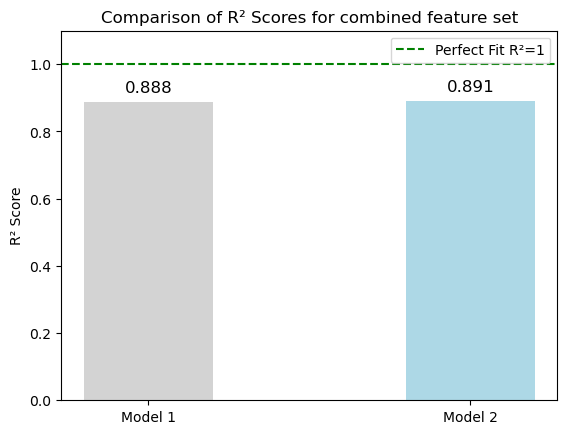

In [37]:
# Creating a bar chart for the R² scores
fig, ax = plt.subplots()
models = ['Model 1', 'Model 2']
r2_scores = [r2_combined_model1, r2_combined_model2]

# Bar chart
bars = ax.bar(models, r2_scores, color=['lightgrey', 'lightblue'], width=0.4)  # Adjust color and width as needed

# Annotating each bar with the R² score
for bar, r2 in zip(bars, r2_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{r2:.3f}', ha='center', va='bottom', fontsize=12)

# Line at R²=1 for reference
ax.axhline(y=1, color='green', linestyle='--', label='Perfect Fit R²=1')

# Customizing the plot
ax.set_ylim(0, 1.1)  # Extending y-axis to show the line clearly
ax.set_ylabel('R² Score')
ax.set_title('Comparison of R² Scores for combined feature set')
ax.legend() 

# Save the plot as an image file
plt.savefig('../Results/combined_feature_set_comparison.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


Plot saved to ../Results\Final Combined Features_Random Forest_plots.png


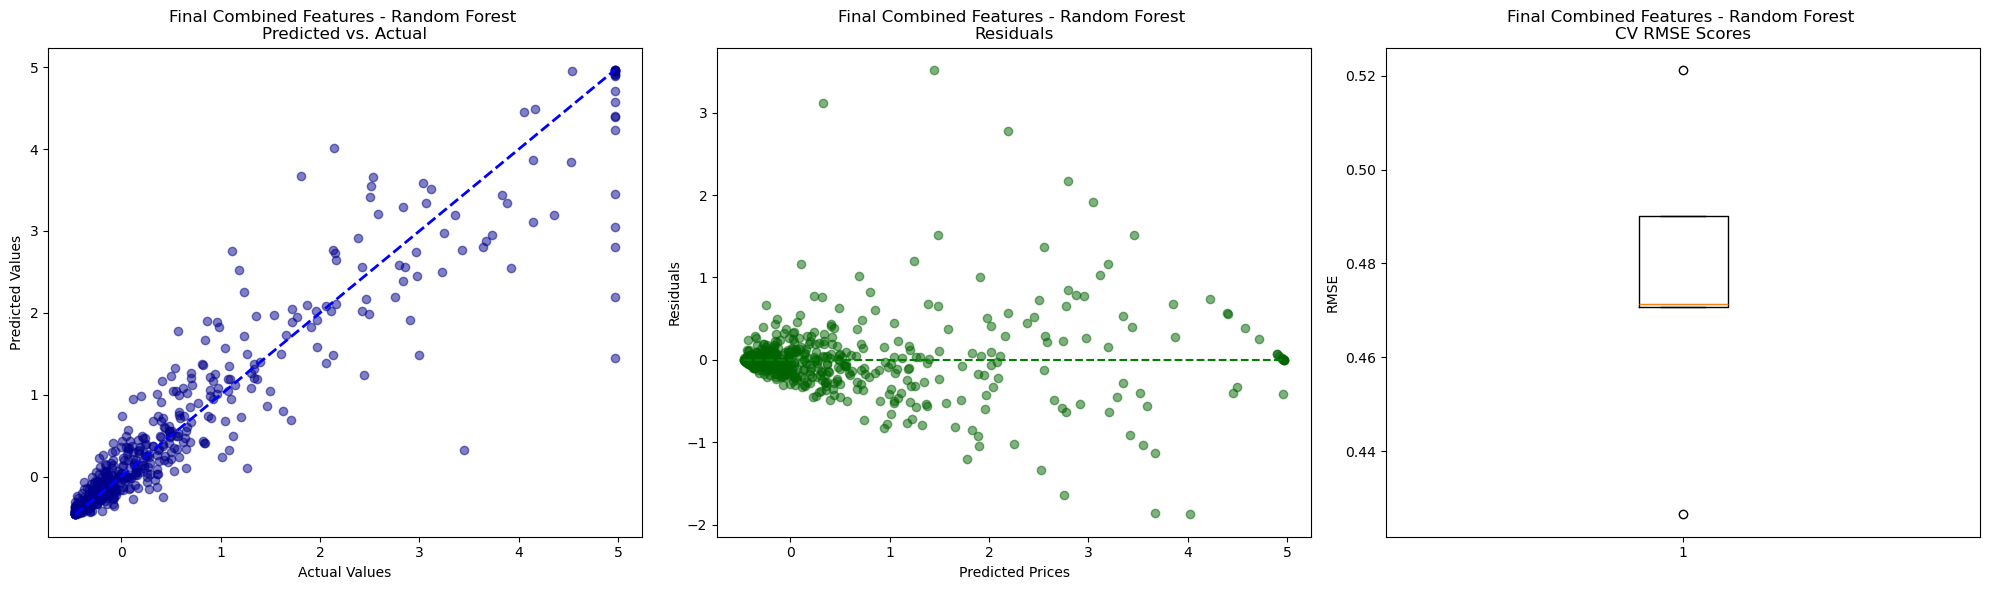

In [38]:

# Plotting and save graphs in a specified directory
def plot_model_comparisons(final_results,  results_folder='../Results'):
    """
    The visualizations include scatter plots of predicted
    vs. actual values, residual plots, and box plots of cross-validation RMSE scores.
    """ 
   
    for feature_set_name, results in final_results.items():
        for model_name, result in results.items():
            fig, axs = plt.subplots(1, 3, figsize=(20, 6))
            y_test = result['y_test']
            y_pred = result['y_pred']
            font_size = 14
            title_font_size = 16

            # Plotting Predicted vs Actual
            axs[0].scatter(y_test, y_pred, alpha=0.5, color='darkblue')
            axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b--', lw=2)
            axs[0].set_title(f'{feature_set_name} - {model_name} \nPredicted vs. Actual')
            axs[0].set_xlabel('Actual Values')
            axs[0].set_ylabel('Predicted Values')

            # Plotting Residuals
            residuals = y_test - y_pred
            axs[1].scatter(y_pred, residuals, alpha=0.5, color='darkgreen')
            axs[1].hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), linestyles='dashed', color='green')
            axs[1].set_title(f'{feature_set_name} - {model_name} \nResiduals')
            axs[1].set_xlabel('Predicted Prices')
            axs[1].set_ylabel('Residuals')

            # Plotting CV RMSE Scores
            rmse_cv_scores = result['rmse_cv_scores']
            axs[2].boxplot(rmse_cv_scores)
            axs[2].set_title(f'{feature_set_name} - {model_name} \nCV RMSE Scores')
            axs[2].set_ylabel('RMSE')
            
            # Adjusting layout to prevent overlap
            fig.tight_layout()

            # Generating and formatting the filename for saving the plot
            plot_filename = os.path.join(results_folder, f"{feature_set_name}_{model_name}_plots.png")
            fig.savefig(plot_filename, format='png', dpi=300)
            print(f"Plot saved to {plot_filename}")
            plt.show()
            # Close the plot to free memory
            plt.close(fig)

plot_model_comparisons(final_results)

In [39]:

# Defining keys to keep
keys_to_keep = ['mean_mae_cv_score', 'mean_mse_cv_score', 'mean_rmse_cv_score', 
                'mean_r2_cv_score', 'mae', 'mse', 'rmse', 'r2']

def filter_results(results):
    return {key: value for key, value in results.items() if key in keys_to_keep}

def prepare_data_for_excel(results_dict):
    excel_data = []
    for feature_set_name, models in results_dict.items():
        for model_name, results in models.items():
            filtered = filter_results(results)
            filtered['Feature Set'] = feature_set_name
            filtered['Model'] = model_name
            excel_data.append(filtered)
    return pd.DataFrame(excel_data)

# Creating DataFrame for each results dictionary
df_final_results = prepare_data_for_excel(final_results)

# Combining DataFrames
df_combined_data = pd.concat([df_all_results, df_all_xgb_results, df_final_results], ignore_index=True)

excel_file_path = '../Results/combined_model_comparison_results.xlsx'

# Writing the DataFrame to an Excel file
df_combined_data.to_excel(excel_file_path, index=False)
print(f"Combined results saved to {excel_file_path}")


Combined results saved to ../Results/combined_model_comparison_results.xlsx


## Data validation

## unseen data validation

In [40]:

info_logger.info("Beginning with Unseen data validation")
# Creating a copy of the test dataset to preserve the original data integrity
unseen_df = test_df.copy()

# Loading the complete preprocessing and transformation pipeline from the saved model file
full_stage_pipeline = joblib.load('../Models/full_pipeline.pkl')

# Applying the loaded preprocessing pipeline to the unseen test data
unseen_full_stage_output = full_stage_pipeline.transform(unseen_df)


In [41]:
# Specific imports from the transformed script
from data_transformations_3 import apply_imputations, prepare_data

# Using the function from the script to perform imputations
unseen_full_stage_output = apply_imputations(unseen_full_stage_output)

# Preparing data by splitting into features and targets and performing a train-test split
unseen_full_stage_output, unseen_X_test, unseen_y_test, X_train, X_test, y_train, y_test = prepare_data(unseen_full_stage_output)

In [42]:
unseen_full_stage_output.head()

Property Type  Duration  PPD Category Type  Region code  \
0            4.0       0.0                0.0   12000009.0   
1            0.0       0.0                0.0   12000006.0   
2            4.0       0.0                0.0   12000002.0   
3            4.0       0.0                0.0   12000002.0   
4            4.0       0.0                0.0   12000009.0   

   Local authority code  AveragePrice     Index  1m%Change  SalesVolume  \
0             7000041.0     -0.046645 -0.263014  -0.235950    -0.192440   
1             7000009.0      0.210811  0.755383   1.512927    -0.733677   
2             7000123.0     -1.382713 -1.106112   1.440057    -0.252577   
3             7000125.0     -1.206381  0.922333  -0.017340    -0.778179   
4             6000022.0      0.774857 -0.012588  -0.235950     0.589347   

   DetachedPrice  ...  DetachedPrice_PctChange  SemiDetachedPrice_PctChange  \
0       0.285072  ...                 0.008153                    -0.029295   
1      -0.026515  ...                -0.181777                    -0.123397   
2      -0.521442  ...                -0.352883                    -0.425430   
3      -0.530180  ...                -0.009628                     0.056188   
4       0.668249  ...                 1.333274                     1.266976   

   TerracedPrice_PctChange  FlatPrice_PctChange  SalesVolume_log  \
0                 0.031465            -0.056762         4.663439   
1                -0.074842            -0.050682         4.110874   
2                -0.551101            -0.497506         4.615121   
3                 0.140941             0.371656         4.048269   
4                 1.585374             1.302770         5.141664   

   DetachedPrice_log  SemiDetachedPrice_log  TerracedPrice_log  FlatPrice_log  \
0          13.287624              12.811074          12.619546      12.124678   
1          13.087004              12.679374          12.541755      12.072667   
2          12.651777              12.125242          11.740802      11.384501   
3          12.642103              12.179908          11.872654      11.700516   
4          13.489373              12.998352          12.822520      12.534624   

   AveragePrice_log  
0         12.680367  
1         12.770949  
2         12.003050  
3         12.123348  
4         12.944673  

[5 rows x 79 columns]

In [43]:

# Creating a copy of the fully preprocessed unseen data for validation purposes
unseen_validation_output = unseen_full_stage_output.copy()

# Subsetting the unseen validation data to include only the selected features
unseen_X_test = unseen_validation_output[final_features] 

# Loading the pre-trained Random Forest model from the saved file
rf_model = joblib.load('../Models/RandomForest_house_price_prediction_model.pkl')

# Predicting house prices on the unseen test data using the Finalized loaded Random Forest model
predictions = rf_model.predict(unseen_X_test)

# Displaying the predictions made by the model
print("Predictions:")
print(predictions)

# Calculating and evaluating the model's performance metrics on the unseen test data
mae = mean_absolute_error(unseen_y_test, predictions)
mse = mean_squared_error(unseen_y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(unseen_y_test, predictions)

# Output the evaluation results, including MAE, MSE, RMSE, and R²
print(f"Test MAE: {mae}")
print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")
print(f"Test R²: {r2}")

info_logger.info("Predicted price for validation on preprocessed unseen data using saved final feature set and final model")

Predictions:
[ 1.83647906e+00 -1.35135243e-01  1.00833727e+00 -4.50665454e-01
  1.06315740e+00 -3.06499009e-01  7.33947092e-02  1.30945911e+00
  1.21730490e+00  9.26865269e-01 -2.52221526e-01 -2.52086118e-02
  5.25064746e-01  4.54030490e-01 -3.80247451e-01  4.90062345e-01
  2.72456638e-01 -2.62306659e-03  1.04397379e+00  3.44207178e-01
  2.65736710e-01  4.50414169e+00  5.42903260e-01  4.01246968e-01
  1.51367011e-02 -2.09379591e-01 -1.19859820e-01 -3.99204128e-01
 -4.58639172e-01  2.35212833e-01  2.66995672e+00  2.15209862e+00
  6.63999239e-01  3.69342674e-01 -3.60125063e-01 -1.39080761e-01
 -4.27585585e-01  3.42350731e+00 -6.87033997e-02 -3.02189182e-01
  3.13826685e+00 -9.30267354e-02 -3.94130891e-01  1.54373530e+00
 -3.26813586e-01  2.86664032e+00  1.63604809e+00  4.70397870e-01
 -1.64786650e-01 -7.48200809e-02  4.51785010e-01 -3.66926700e-01
 -3.34031919e-01 -3.57104458e-01 -1.80125999e-01  4.56038067e+00
  4.45247447e+00 -1.96343937e-01 -3.13516970e-01  7.00654467e-02
 -3.78279028

In [44]:
# Calculating the range of the target variable to contextualize error metrics
range_of_target = unseen_y_test.max() - unseen_y_test.min()
if range_of_target == 0:
    raise ValueError("Range of target is zero, can't compute percentages.")

# Calculating Mean Absolute Error (MAE) as a percentage of the target variable's range
mae_percentage = (mae / range_of_target) * 100
# Calculating Root Mean Squared Error (RMSE) as a percentage of the target variable's range
rmse_percentage = (rmse / range_of_target) * 100

# Determining the minimum and maximum values of the target variable for reference
min_target = unseen_y_test.min()
max_target = unseen_y_test.max()

# Creating a DataFrame for the evaluation results
evaluation_data = {
    "Metric": ["MAE", "MSE", "RMSE", "R2", "MAE Percentage", "RMSE Percentage"],
    "Value": [mae, mse, rmse, r2, mae_percentage, rmse_percentage]
}

df_evaluation = pd.DataFrame(evaluation_data)

evaluation_file_path = '../Results/unseen_validation_evaluation.xlsx'
df_evaluation.to_excel(evaluation_file_path, index=False)
print(f"Evaluation results saved to {evaluation_file_path}")

# Displaying the minimum and maximum target values, and the percentage error metrics
print("Minimum Target Value:", min_target)
print("Maximum Target Value:", max_target)
print("MAE as Percentage of Range:", mae_percentage)
print("RMSE as Percentage of Range:", rmse_percentage)

Evaluation results saved to ../Results/unseen_validation_evaluation.xlsx
Minimum Target Value: -0.44664621978241664
Maximum Target Value: 4.402948373141246
MAE as Percentage of Range: 4.611316196991281
RMSE as Percentage of Range: 8.692163582918058


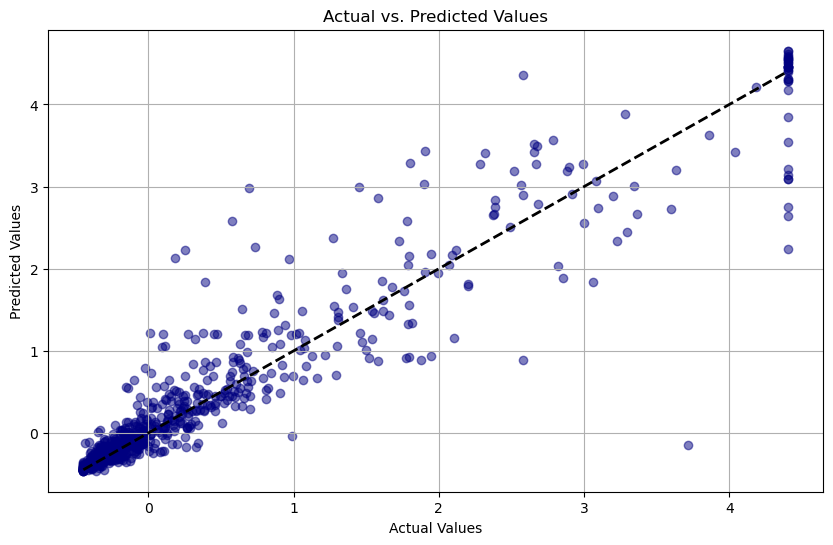

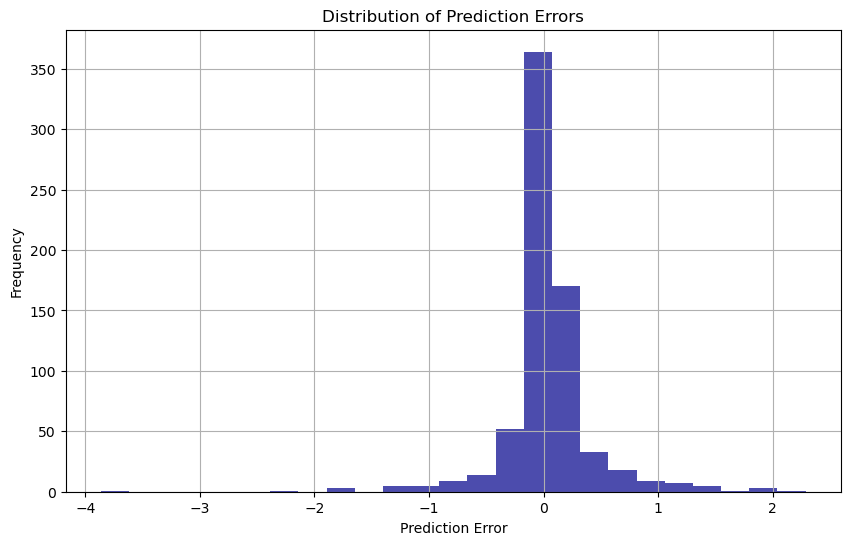

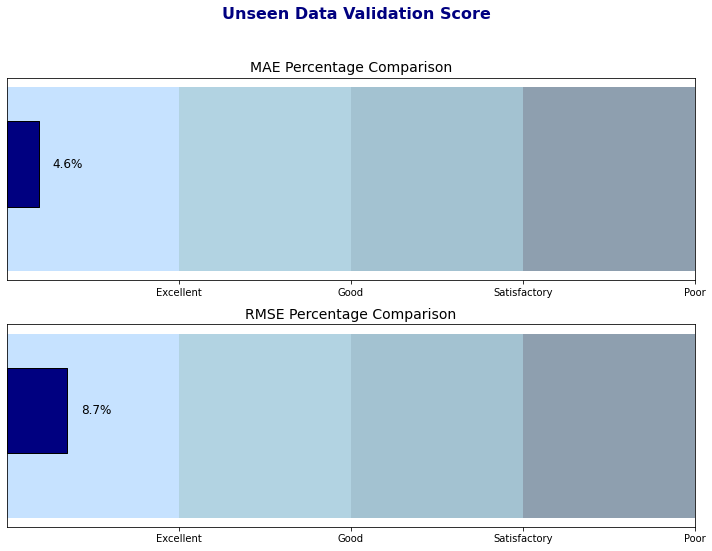

Evaluation results saved successfully to PDF at '../Results/Unseen_data_model_performance_visualizations.pdf'


In [45]:

# Calculating the errors
errors = predictions - unseen_y_test

with PdfPages('../Results/Unseen_data_model_performance_visualizations.pdf') as pdf:
    # Actual vs Predicted Values
    plt.figure(figsize=(10, 6))
    plt.scatter(unseen_y_test, predictions, alpha=0.5, color='navy')
    plt.plot([unseen_y_test.min(), unseen_y_test.max()], [unseen_y_test.min(), unseen_y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs. Predicted Values')
    plt.grid(True)
    pdf.savefig()  
    plt.show() 
    plt.close()

    # Error Distribution
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=25, color='darkblue', alpha=0.7)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors')
    plt.grid(True)
    pdf.savefig()
    plt.show()  
    plt.close()

    def draw_bullet_chart(ax, value, target, ranges, labels, title):
        """
        Draws a bullet chart on the given axes.
        
        Parameters:
        ax (matplotlib.axes.Axes): The axes on which to draw the bullet chart.
        value (float): The actual value to display.
        target (float): The target or goal value to compare against.
        ranges (list of tuple): The qualitative ranges in the form of (start, end).
        labels (list of str): Labels for the qualitative ranges.
        title (str): The title of the chart.
        """
        
        colors = ['#C6E2FF', '#B2D3E2', '#A3C2D1', '#8E9FAF']  # Colors for each range
        for i, r in enumerate(ranges):
            ax.broken_barh([(r[0], r[1] - r[0])], (0.45, 0.43), facecolors=colors[i]) 
        
        # Drawing the actual value as a bar
        ax.broken_barh([(0, value)], (0.6, 0.2), facecolors='navy', edgecolor='black')
        
        # Adding the actual percentage value as text on the bar
        ax.text(value + 2, 0.7, f'{value:.1f}%', fontsize=12, va='center', color='black')

        # Setting labels for the x-axis
        ax.set_xticks([r[1] for r in ranges])
        ax.set_xticklabels(labels)
        
        # Setting the limits of the x-axis to the min and max of the ranges
        ax.set_xlim(0, ranges[-1][1])
        
        # Removing y-axis and ticks
        ax.yaxis.set_visible(False)
        ax.xaxis.tick_bottom()
        
        # Setting the title of the plot
        ax.set_title(title, fontsize=14)
    
    target = 85 
    
    # Defining the ranges and labels for the bullet charts
    ranges = [(0, 25), (25, 50), (50, 75), (75, 100)]  # ranges adjusted for correct intervals
    labels = ['Excellent', 'Good', 'Satisfactory', 'Poor']
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
    # Drawing MAE and RMSE bullet charts
    draw_bullet_chart(ax1, mae_percentage, target, ranges, labels, 'MAE Percentage Comparison')
    draw_bullet_chart(ax2, rmse_percentage, target, ranges, labels, 'RMSE Percentage Comparison')
        
    # Setting an overall title
    fig.suptitle('Unseen Data Validation Score', fontsize=16, fontweight='bold', color='navy')
    
    pdf.savefig()  # Saving the current figure to a PDF page
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
    plt.show()
    plt.close()
    
print("Evaluation results saved successfully to PDF at '../Results/Unseen_data_model_performance_visualizations.pdf'")
info_logger.info("Completed validation")